<a href="https://colab.research.google.com/github/vgarcialopezm/ABC-SMC/blob/main/ABCSMCIMPEUL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import numpy as np
from scipy.stats import norm, uniform, multivariate_normal
from scipy.optimize import minimize
from scipy.optimize import fsolve
from scipy.special import logsumexp
from scipy import sparse as sp
import sys,ast
from math import exp,log
from random import choices,seed,random
from tqdm import tqdm
#import p_tqdm
from functools import partial
import os
import matplotlib.pyplot as plt
import scipy.sparse.linalg as spl



In [33]:
epsilons=[350.0,250.0,180.0,130.0,110.0,100.0,90.0] #200.0,150.0,125.0,115.0] #105.0] #,100.0,94.0,90.0,87.0]
#epsilons=[50000.0,40000.0,30000.0,25000.0,20000]
#epsilons=[16.0,12.0,11.8,11.3,10.6,7.1,5.2]


#PARAMETERS INVOLVED IN THE GLIOBLASTOMA MODEL

params_tumor = [ # list of parameters used in the glioblastoma model 
    {'name' : 'Dn', 'lower_limit':0.000001,'upper_limit':0.01},# Population of cells Diffusion coefficient
    {'name' : 'Dc','lower_limit':10.0,'upper_limit':150.0},# Oxygen Diffusion coefficient 
    {'name' : 'am','lower_limit':20000.0,'upper_limit':29000.0},# term involved in the calculation of a(G1/S)
    {'name' : 'k1','lower_limit':1.0,'upper_limit':10.0}, #Oxygen consumption rate,
    {'name' : 'betaf','lower_limit':20.0,'upper_limit':50.0} #flow of oxygen at right boundary

]

In [34]:
taup=4800   #*deltat  #*deltat
beta1=2.5
a3H0=0.0085
d1=0.2
a0=0.45185
a1=0.51
a2=1
d2=0.1
e2f=1
beta=0.4980
#value of p6/p3 set to 1
p6p3=1
#c critico
# Calculate the value of c_cr using the parameters above and the expression given in the document
ccr=1.0-((1.0/beta1)*np.log((1/a3H0)*(a1+((a2*d2)/(d1*e2f))*(1-1/(1-a0/((p6p3)*(p6p3)))))));
nu=0.00001097


In [35]:
#spatial grid
L=191
dx=0.4819 #0.4819 #J/(L)
J=dx*L
x_grid=np.linspace(0,J,L)
#time grid
T=3*24*3600 #3 #final time (3 days)
dt=1000
N=round((1/dt)*T) #300  #501  #NUMBER OF TIME STEPS
 #time step (it is almost every 130 secs. 2 minutes approximately)
t_grid=np.linspace(0,T,N)
#k1=1.45773318
k2=0.0942

#parameters involved in Newton Raphson method:
max_iter=20
tolerance=0.00001

In [36]:
datos = np.loadtxt('doblaredia3.txt', delimiter=',')
len(datos)

191

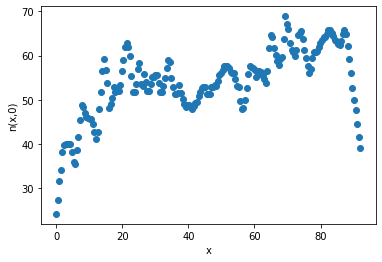

In [37]:
U=datos
plt.plot(x_grid, U,'o')
plt.xlabel('x')
plt.ylabel('n(x,0)')
plt.show()

In [40]:
datosdia6 = np.loadtxt('datosdia6.txt', delimiter=',')
len(datosdia6)

191

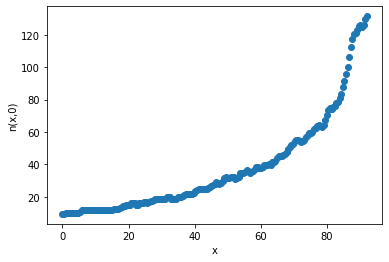

In [41]:
plt.plot(x_grid, datosdia6,'o')
plt.xlabel('x')
plt.ylabel('n(x,0)')
plt.show()

In [42]:
datosdia9=np.loadtxt('datosdia9.txt', delimiter=',')

In [10]:
def newton_raps(c,am):
    #print('c',c)
    if c>ccr:
      aG1S=am*(c/ccr-1)**(-beta)
    else:
      aG1S=10000000000
    #print(aG1S)
    #print('ag1s',aG1S)
    #Expression of the function to obtain the value of lambda
    f=lambda lam:log(taup)-log(2)+lam*aG1S+nu*aG1S+log(lam+nu+1/taup)
  
    #Fist derivative of th previos function 
    Df=lambda lam: aG1S+1/(lam+nu+1/taup)
    #tabla = []
    section = abs(2*tolerance)
    xi = 0
    while (section>=tolerance):
        xnew = xi - f(xi)/Df(xi)
        section  = abs(xnew-xi)
        #tabla.append([xi,xnew,section])
        xi = xnew
    return xi
#xi=newton_raps(c)


In [9]:
def crank_nic(Dn,Dc,a_m,U,L,k1,betaf):
    sigma_u=Dn*dt/(dx**2)
    sigma_v=Dc*dt/(dx**2)
    c_est=Dc*betaf/(L*(k1*np.mean(U)+k2))
    aux=np.zeros(L)
    aux[-1]= 4*dx*betaf*sigma_v
    
    V = np.array([c_est for i in range (0,L)])
    aux=np.zeros(L)
    aux[-1]= 4*dx*betaf*sigma_v
    #Matrices for Crank Nicholson in equation of population of cells
    #diagonals=[L*[2.+2.*sigma_u] ,[-2.*sigma_u,(L-2)*[-sigma_u]],[(L-2)*[-sigma_u],-2*sigma_u]]
    #A_n=sparse.diags(diagonals,[0,1,-1]).toarray()
    A_n = np.diagflat([-sigma_u for i in range(L-2)]+[-2*sigma_u], -1) +\
      np.diagflat([2.+2.*sigma_u for i in range(L)]) +\
      np.diagflat([-2.*sigma_u]+[-sigma_u for i in range(L-2)], 1)
    A_n=sp.csr_matrix(A_n)
    B_n = np.diagflat([sigma_u for i in range(L-2)]+[2.*sigma_u], -1) +\
      np.diagflat([2.-2.*sigma_u for i in range(L)]) +\
      np.diagflat([2.*sigma_u]+[sigma_u for i in range(L-2)], 1)
    B_n=sp.csr_matrix(A_n)
    #Matrices for Crank Nicholson in equation of oxygen
    A_c = np.diagflat([-sigma_v for i in range(L-2)]+[-2*sigma_v], -1) +\
      np.diagflat([2.+2.*sigma_v for i in range(L)]) +\
      np.diagflat([-2.*sigma_v]+[-sigma_v for i in range(L-2)], 1)
    A_c=sp.csr_matrix(A_c)
    B_c = np.diagflat([sigma_v for i in range(L-2)]+[2.*sigma_v], -1) +\
      np.diagflat([2.-2.*sigma_v for i in range(L)]) +\
      np.diagflat([2.*sigma_v]+[sigma_v for i in range(L-2)], 1)
    B_c=sp.csr_matrix(B_c) 
  
    
    for ti in range(1,N):
        lamda_vect=np.zeros(L)
        for i in range(L):
            xi=newton_raps(V[i],a_m)
            lamda_vect[i]=xi #np.longfloat(xi)
        #print('step',ti)
        U_new = spl.spsolve(A_n, (B_n @ U + dt*lamda_vect*U))
        V_new = spl.spsolve(A_c, (B_c@V +dt*(-k1*U*V-k2*V+aux)))
        lamda_vect=np.zeros(L)
        V = V_new
        #print(V_new)
        #for i in range(L):
        #    xi=newton_rapsi(V[i],a_m,nu)
        #    lamda_vect[i]=np.longfloat(xi)
        #print(lamda_vect)
        U = U_new
        #print(U_new)
    #print(V_new)
    return U,V 

In [11]:
def valores(Dc,k1,k2,betaf):
  c_est=Dc*betaf/(L*(k1*np.mean(datos)+k2))
  x0=np.zeros(382)
  for i in range (0,len(datos)):
     x0[i]=datos[i]
  for j in range(len(datos),382):
     x0[j]=c_est
  return x0

In [27]:
from scipy.interpolate.interpolate import interp2d
from numpy.lib.function_base import iterable
def eval_function(x,Dn,Dc,c1,am,betaf):
  #c2=(9.42*10**(-2))
  #x=valores(Dc,c1,c2)
  iter=np.zeros(382)
  sigma_n=Dn/(dx**2)
  sigma_c=Dc/(dx**2)
  iter[0]=(sigma_n)*(2*x[1]-2*x[0])+newton_raps(x[191],am)*x[0]
  for i in range (1,190):
    iter[i]=(sigma_n)*(x[i-1]-2*x[i]+x[i+1])+newton_raps(x[i+190],am)*x[i]
  iter[190]=(sigma_n)*(2*x[189]-2*x[190])+newton_raps(x[381],am)*x[190]
  iter[191]= (sigma_c)*(2*x[192]-2*x[191])-c1*x[0]*x[191]-k2*x[191]
  for j in range(192,381):
        iter[j]= (sigma_c)*(x[j-1]-2*x[j]+x[j+1])-c1*x[j-192]*x[j]-k2*x[j]
  iter[381]=(sigma_c)*((2*x[380]-2*x[381])+2*betaf*dx)-c1*x[190]*x[381]-k2*x[381]

  return iter      



In [17]:
#h=0.4819
#c2=(9.42*10**(-2))
def euler_imp(Dn,Dc,am,k1,betaf):
  x0=valores(Dc,k1,k2,betaf)
  prev_iter=x0
  x=x0
  #dt=1000 #TIME STEP IN SECONDS
  sol=np.zeros(382)
  #T=259200; #NUMBER OF SECONDS IN THREE DAYS


  #nsteps=round((1/dt)*T); #%VOY A DAR 867 pasos

  func=lambda x: x-dt*eval_function(x,Dn,Dc,k1,am,betaf)-prev_iter

  for i in range(0,N):
    sol=fsolve(func,prev_iter)
    prev_iter=sol
  return(sol)


In [106]:
data_prev=euler_imp(0.06,60.0,8250,1.45773318,40.012)

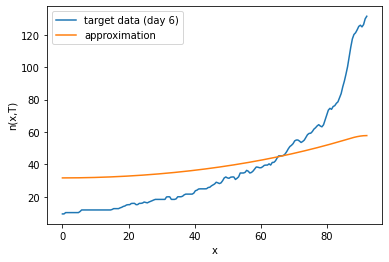

In [107]:
plt.figure()
plt.plot(x_grid,datosdia6,label='target data (day 6)')
plt.plot(x_grid,data_prev[0:191],label='approximation')
plt.xlabel('x')
plt.ylabel('n(x,T)')
plt.legend(loc="upper left")
plt.show()

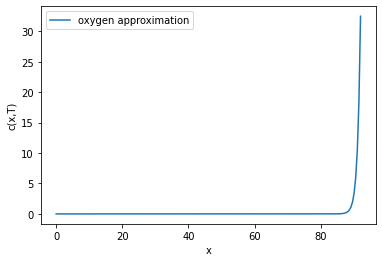

In [108]:
plt.figure()
plt.plot(x_grid,data_prev[191:],label='oxygen approximation')
plt.xlabel('x')
plt.ylabel('c(x,T)')
plt.legend(loc="upper left")
plt.show()

In [44]:
def euc_disti(data1, data2):
    if np.shape(data1) != np.shape(data2):
        print ("\n the dimensions of the datasets are different (%s v.s. %s)\n" % (len(data1), len(data2)))
        sys.exit()
    else:
        distance = np.linalg.norm(data1 - data2)
        #print('dist',data1 - data2)

    if distance < 0:
        return [None]
    else:
        return distance


In [45]:
def euc_dist(data1, data2):
    if np.shape(data1) != np.shape(data2):
        print ("\n the dimensions of the datasets are different (%s v.s. %s)\n" % (len(data1), len(data2)))
        sys.exit()
    else:
        z=np.array((data1 - data2)**2)
        distance = np.sum(z)
        #print('dist',data1 - data2)

    if distance < 0:
        return [None]
    elif np.isnan(distance):
        distance=100000
        return distance
    else:
        return distance


In [20]:
def prior():
### Generate a random parameter inside the limits stablished. The shape of the distribution can be changed if required
    prior = []
    for ipar,par in enumerate(params_tumor):
        prior.append(uniform.rvs(loc = par['lower_limit'],
                                 scale = par['upper_limit']-par['lower_limit'])) #par['upper_limit']))
        
       
    return prior


In [21]:
#function that given the values of the parameters, calculates the 

def evaluate_prev_pru(params):
    print('parameters',params)
    l=len(params)
    prior = 1
    for ipar,par in enumerate(params_tumor):
    #for i in range(l):
        prior *= uniform.pdf(params[ipar],loc = par['lower_limit'],
                                 scale = par['upper_limit']-par['lower_limit'])
        if prior==0:
            break   
      #  print('params i', params[i])
       # print('prior',prior)
    return prior


In [22]:
#function that, given a list of parameters sampled, perturbs it by applying a multivariate normal kernel
def perturb(listaprev,s):
    print(listaprev)
    lista=np.asarray(listaprev) #.tolist()
    #mean_vec=np.mean(lista)
    cov_matrix=2.0*np.cov(lista.T)  #the covariance matrix for the multivariate normal perturbation kernel is given by this expression
    print(cov_matrix)
    kernel=multivariate_normal(cov=cov_matrix,allow_singular=True)
    pert=s+kernel.rvs() # here we obtain the list of perturbed parameters
    pertur=pert.tolist()
    return pertur


In [23]:
#function that gives the denominator used to calculate the weights of every particle.
def weighting(i,j,N,sam,wei,sampre):
     denom=0
     #ker=1
     samprev=np.asarray(sampre)
     cov_matrix=2.0*np.cov(samprev)
     kernel=multivariate_normal(cov=cov_matrix,allow_singular=True)
     for k in range(N):
            #print('sample i j',type(sam[k]),sam[k])
           # print('sample i-1,j',type(sampre[k]),sampre[k])
            sampre[k]=np.array(sampre[k])
            #print('sampre',sampre[k])
            #cov_matrix=2.0*np.cov((sampre[k]).T)  #the covariance matrix for the multivariate normal perturbation kernel is given by this expression
            #print('cov',cov_matrix)
            #kernel=multivariate_normal(cov=cov_matrix)
            # print('wei',wei[i-1,k])
            #print('sam[j]',sam[j])
            #print('sampre[k]',sampre[k])
            ker=kernel.pdf(sam[j]-sampre[k])
            #print('ker',ker)
            #kerne=np.prod(ker)  #here we are obtaining the joint probability of the parameter vector obtained when applying the kernel
            denom+=wei[k]*ker #kerne
            #print('kernel',kernel.cdf(sam[k]-sampre[k]))
     #print('den',denom)      
     return denom


In [24]:
#function used to normalize the weights
def normalize(wei):
    #normalized=wei/np.linalg.norm(wei)
    normalized=wei/np.sum(wei)
    return normalized  



In [25]:
def principal(epsilons,listaparametros,N,data1):
   # accepted_distances = np.loadtxt('smc/distances_{}_{}_{}_{}.out'.format(model,sto,gamma,prior_label))
    T=len(epsilons)
    weight=np.zeros((T,N),float)
    dist=np.zeros((T,N),float)
    sample=np.zeros((T,N),list)
    #X0=[Ui,Vi]
    #t=np.linspace(0.,10,10)
    for i in range(T):
        count=0
        counti=0
        label=i
        print("SMC step with target distance: {}".format(epsilons[i]))
        if i==0:
            for j in range (N):
                dist[i,j]=epsilons[i]+1
                while dist[i,j]>epsilons[i]:
                    sample[i,j]=prior()
                    #sample[i,j]=np.array(prior())
                    sample[i,j]=np.asarray(sample[i,j])
                    print(sample[i,j][0])
                    print(sample[i,j][1])
                    print(sample[i,j][2])
                    print(sample[i,j][3])
                    print(sample[i,j][4])
                    #print(sample[i,j][5])
                    data2= euler_imp(sample[i,j][0],sample[i,j][1],sample[i,j][2],sample[i,j][3],sample[i,j][4])#,sample[i,j][5])
                    oxi=np.zeros(191)
                    oxi=data2[191:]
                    print('oxigeno',oxi)
                    data_2=np.zeros(191)
                    data_2=np.array(data2[0:191])
                    print('data2',data_2)
                    print('data1',data1)
                    #print('data2',data2)
                    #data2=np.array(data2, dtype=np.float64)
                    dist[i,j]=euc_disti(data1,data_2)
                    print('distcondata2',dist[i,j])
                    plt.plot(x_grid,datosdia6)
                    plt.plot(x_grid,data_2)
                    plt.xlabel('x')
                    plt.ylabel('n(x,T)')
                    plt.legend(loc="upper left")
                    plt.show()
                count+=1
                print(count)
       
        else:
        
            for j in range (N):
                dist[i,j]=epsilons[i]+1
                while dist[i,j]>epsilons[i]:
                    seed()
                    np.random.seed()
                    choose = choices(sample[i-1,:], weights = weight[i-1,:],k=1)[0] # select a point from the previous sample
                    sample[i,j]=choose
                    #print("before perturb",type(sample[i,j]))
                    #print("before perturb",list(sample[i-1,:]))
                    sample[i,j] = perturb(list(sample[i-1,:]),sample[i,j]) # and perturb it
                    print("after perturb", sample[i,j])
                    #print("after perturb", type(sample[i,j]))
                    evaluation=evaluate_prev_pru(sample[i,j]) 
                    if evaluation>0:
                        data2= np.array(euler_imp(sample[i,j][0],sample[i,j][1],sample[i,j][2],sample[i,j][3],sample[i,j][4])).T #,sample[i,j][5])).T
                        oxi=np.zeros(191)
                        oxi=data2[191:]
                        print('oxigeno',oxi)
                        data_2=np.zeros(191)
                        data_2=np.array(data2[0:191])
                        print('data2',data_2)
                        print('data1',data1)
                        dist[i,j]=euc_disti(data1,data_2)
                        print('distendata2',dist[i,j])
                        plt.plot(x_grid,datosdia6)
                        plt.plot(x_grid,data_2)
                        plt.xlabel('x')
                        plt.ylabel('n(x,T)')
                        plt.legend(loc="upper left")
                        plt.show()
                counti+=1
                print(counti)
        for j in range(N):
            if i==0:
                weight[i,j]=1
               # print(weight[i,j])
            elif i==T-1:
              break
            else:
                denom=weighting(i,j,N,sample[i,:],weight[i-1,:],list(sample[i-1,:]))
                weight[i,j]=evaluate_prev_pru(sample[i,j])/denom
        #print('weight[i,:]',weight[i,:])
        if i!=0:
           weight[i,:]=normalize(weight[i,:])
           #print('weight[i,:] normalized',weight[i,:])
        #pars = np.loadtxt('smc_van/pars_{}.out'.format(i))
        #weights = np.loadtxt('smc_van/weights_{}.out'.format(i))
        #np.savetxt('smc_van/pars_{}.out'.format(i), sample[T-1,:])
        #np.savetxt('smc_van/weights_{}.out'.format(i), weight[T-1,:])
      #  np.savetxt('smc/distances_{}.out'.format(label), accepted_distances)
    #print('sample',sample[T-1,N-1])
    #print('weight',weight[T-1])
    #print('dist',dist[T-1])
    return sample, weight, dist,data2


In [20]:
def principal_cr(epsilons,listaparametros,N,data1):
   # accepted_distances = np.loadtxt('smc/distances_{}_{}_{}_{}.out'.format(model,sto,gamma,prior_label))
    T=len(epsilons)
    weight=np.zeros((T,N),float)
    dist=np.zeros((T,N),float)
    sample=np.zeros((T,N),list)
    #X0=[Ui,Vi]
    #t=np.linspace(0.,10,10)
    for i in range(T):
        count=0
        counti=0
        label=i
        print("SMC step with target distance: {}".format(epsilons[i]))
        if i==0:
            for j in range (N):
                dist[i,j]=epsilons[i]+1
                while dist[i,j]>epsilons[i]:
                    sample[i,j]=prior()
                    #sample[i,j]=np.array(prior())
                    sample[i,j]=np.asarray(sample[i,j])
                    print(sample[i,j][0])
                    print(sample[i,j][1])
                    print(sample[i,j][2])
                    print(sample[i,j][3])
                    print(sample[i,j][4])
                    #print(sample[i,j][5])
                    data2= np.array(crank_nic(sample[i,j][0],sample[i,j][1],sample[i,j][2],U,L,sample[i,j][3],sample[i,j][4])).T#,sample[i,j][5])).T
                    print('oxigeno',data2[:,1])
                    data2=np.array(data2[:,0])
                    print('data2',data2)
                    print('data1',data1)
                    #print('data2',data2)
                    #data2=np.array(data2, dtype=np.float64)
                    dist[i,j]=euc_disti(data1,data2)
                    print('distcondata2',dist[i,j])
                    plt.plot(x_grid,datosdia6,'o')
                    plt.plot(x_grid,data2)
                    plt.xlabel('x')
                    plt.ylabel('n(x,T)')
                    plt.show()
                count+=1
                print(count)
       
        else:
        
            for j in range (N):
                dist[i,j]=epsilons[i]+1
                while dist[i,j]>epsilons[i]:
                    seed()
                    np.random.seed()
                    choose = choices(sample[i-1,:], weights = weight[i-1,:],k=1)[0] # select a point from the previous sample
                    sample[i,j]=choose
                    #print("before perturb",type(sample[i,j]))
                    #print("before perturb",list(sample[i-1,:]))
                    sample[i,j] = perturb(list(sample[i-1,:]),sample[i,j]) # and perturb it
                    print("after perturb", sample[i,j])
                    #print("after perturb", type(sample[i,j]))
                    evaluation=evaluate_prev_pru(sample[i,j]) 
                    if evaluation>0:
                        data2= np.array(crank_nic(sample[i,j][0],sample[i,j][1],sample[i,j][2],U,L,sample[i,j][3],sample[i,j][4])).T #,sample[i,j][5])).T
                        print('oxigeno',data2[:,1])
                        data2=np.array(data2[:,0])
                        print('data2',data2)
                        print('data1',data1)
                        dist[i,j]=euc_disti(data1,data2)
                        print('distendata2',dist[i,j])
                        plt.plot(x_grid,datosdia6,'o')
                        plt.plot(x_grid,data2)
                        plt.xlabel('x')
                        plt.ylabel('n(x,T)')
                        plt.show()
                counti+=1
                print(counti)
        for j in range(N):
            if i==0:
                weight[i,j]=1
               # print(weight[i,j])
            elif i==T-1:
              break
            else:
                denom=weighting(i,j,N,sample[i,:],weight[i-1,:],list(sample[i-1,:]))
                weight[i,j]=evaluate_prev_pru(sample[i,j])/denom
        #print('weight[i,:]',weight[i,:])
        if i!=0:
           weight[i,:]=normalize(weight[i,:])
           #print('weight[i,:] normalized',weight[i,:])
        #pars = np.loadtxt('smc_van/pars_{}.out'.format(i))
        #weights = np.loadtxt('smc_van/weights_{}.out'.format(i))
        #np.savetxt('smc_van/pars_{}.out'.format(i), sample[T-1,:])
        #np.savetxt('smc_van/weights_{}.out'.format(i), weight[T-1,:])
      #  np.savetxt('smc/distances_{}.out'.format(label), accepted_distances)
    #print('sample',sample[T-1,N-1])
    #print('weight',weight[T-1])
    #print('dist',dist[T-1])
    return sample, weight, dist,data2


SMC step with target distance: 350.0
0.006690597512894311
143.5945512116497
27138.141164357796
7.410285716872271
47.43759262598273


oxigeno [7.98496247e-34 8.23904573e-34 9.01746550e-34 1.03698196e-33
 1.23823843e-33 1.51836971e-33 1.89528934e-33 2.39313554e-33
 3.04384490e-33 3.88924093e-33 4.98377796e-33 6.39812656e-33
 8.22384430e-33 1.05794514e-32 1.36183292e-32 1.75389873e-32
 2.25984139e-32 2.91294421e-32 3.75633563e-32 4.84593366e-32
 6.25428432e-32 8.07556906e-32 1.04321431e-31 1.34830798e-31
 1.74353471e-31 2.25584396e-31 2.92035538e-31 3.78287414e-31
 4.90319372e-31 6.35943707e-31 8.25376878e-31 1.07199190e-30
 1.39331047e-30 1.81231274e-30 2.35916820e-30 3.07352607e-30
 4.00754931e-30 5.22993873e-30 6.83127691e-30 8.93113356e-30
 1.16875252e-29 1.53095255e-29 2.00740983e-29 2.63485966e-29
 3.46208782e-29 4.55396703e-29 5.99687498e-29 7.90597720e-29
 1.04350311e-28 1.37896040e-28 1.82449196e-28 2.41699936e-28
 3.20603229e-28 4.25822316e-28 5.66331286e-28 7.54235189e-28
 1.00588808e-27 1.34341982e-27 1.79682463e-27 2.40682307e-27
 3.22879080e-27 4.33816135e-27 5.83786951e-27 7.86862496e-27
 1.06231187e-26 

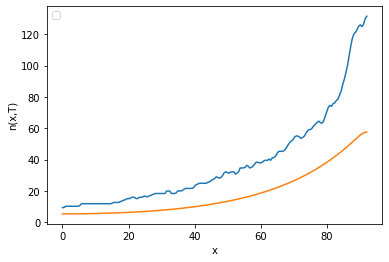

1
0.001740187292551307
110.56671586761692
27463.41851906869
1.3357786457473235
32.812925254886515


oxigeno [1.27174704e-24 1.27734027e-24 1.29416913e-24 1.32238258e-24
 1.36223160e-24 1.41407164e-24 1.47836603e-24 1.55569050e-24
 1.64673877e-24 1.75232939e-24 1.87341375e-24 2.01108555e-24
 2.16659161e-24 2.34134439e-24 2.53693620e-24 2.75515528e-24
 2.99800410e-24 3.26771989e-24 3.56679781e-24 3.89801698e-24
 4.26446977e-24 4.66959465e-24 5.11721302e-24 5.61157068e-24
 6.15738421e-24 6.75989320e-24 7.42491883e-24 8.15892970e-24
 8.96911592e-24 9.86347242e-24 1.08508928e-23 1.19412750e-23
 1.31456406e-23 1.44762697e-23 1.59468527e-23 1.75726627e-23
 1.93707502e-23 2.13601642e-23 2.35622028e-23 2.60006981e-23
 2.87023397e-23 3.16970441e-23 3.50183746e-23 3.87040217e-23
 4.27963518e-23 4.73430342e-23 5.23977617e-23 5.80210753e-23
 6.42813130e-23 7.12557020e-23 7.90316156e-23 8.77080256e-23
 9.73971799e-23 1.08226544e-22 1.20341053e-22 1.33905726e-22
 1.49108703e-22 1.66164792e-22 1.85319596e-22 2.06854344e-22
 2.31091546e-22 2.58401627e-22 2.89210713e-22 3.24009811e-22
 3.63365622e-22 

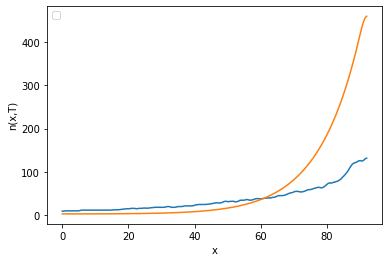

0.0026656009385339977
52.635305623030355
28200.332259832656
3.748095135708792
23.552165820912705


oxigeno [2.23141170e-31 2.28978199e-31 2.46794663e-31 2.77523228e-31
 3.22773492e-31 3.84916918e-31 4.67212115e-31 5.73977177e-31
 7.10818358e-31 8.84927354e-31 1.10546326e-30 1.38403979e-30
 1.73534427e-30 2.17792180e-30 2.73516758e-30 3.43658134e-30
 4.31935274e-30 5.43036479e-30 6.82872580e-30 8.58896981e-30
 1.08051033e-29 1.35957234e-29 1.71104942e-29 2.15383442e-29
 2.71178473e-29 3.41503748e-29 4.30167654e-29 5.41984658e-29
 6.83043522e-29 8.61047805e-29 1.08574833e-28 1.36949280e-28
 1.72792465e-28 2.18087225e-28 2.75348097e-28 3.47765531e-28
 4.39389726e-28 5.55365140e-28 7.02229828e-28 8.88297824e-28
 1.12414795e-27 1.42324913e-27 1.80276100e-27 2.28455973e-27
 2.89655338e-27 3.67437026e-27 4.66352748e-27 5.92221913e-27
 7.52490414e-27 9.56692770e-27 1.21704795e-26 1.54922831e-26
 1.97335296e-26 2.51527240e-26 3.20823153e-26 4.09502492e-26
 5.23079313e-26 6.68665491e-26 8.55443073e-26 1.09527929e-25
 1.40352828e-25 1.80007763e-25 2.31071607e-25 2.96892344e-25
 3.81821642e-25 

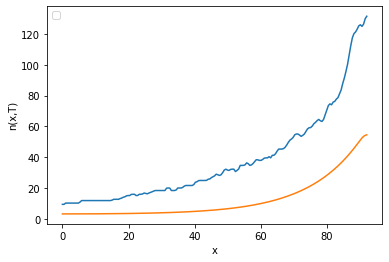

0.0025487402127746606
32.31428332907974
26740.509657374547
2.682455134069053
41.682936687791845


oxigeno [4.87938952e-35 5.02807851e-35 5.48320743e-35 6.27252950e-35
 7.44420440e-35 9.06975599e-35 1.12484698e-34 1.41135042e-34
 1.78400972e-34 2.26563809e-34 2.88574823e-34 3.68237953e-34
 4.70445739e-34 6.01483354e-34 7.69419984e-34 9.84612367e-34
 1.26035256e-33 1.61370129e-33 2.06656021e-33 2.64705207e-33
 3.39129766e-33 4.34570466e-33 5.56991704e-33 7.14061719e-33
 9.15643001e-33 1.17442511e-32 1.50674167e-32 1.93362577e-32
 2.48217404e-32 3.18731058e-32 4.09406959e-32 5.26055069e-32
 6.76174781e-32 8.69451300e-32 1.11839959e-31 1.43920032e-31
 1.85278587e-31 2.38625216e-31 3.07469556e-31 3.96360458e-31
 5.11197652e-31 6.59638220e-31 8.51627152e-31 1.10009050e-30
 1.42184172e-30 1.83876801e-30 2.37938437e-30 3.08087170e-30
 3.99175206e-30 5.17540421e-30 6.71468808e-30 8.71803477e-30
 1.13274754e-29 1.47292387e-29 1.91677548e-29 2.49641839e-29
 3.25409622e-29 4.24543593e-29 5.54377215e-29 7.24589839e-29
 9.47972663e-29 1.24145030e-28 1.62744525e-28 2.13570304e-28
 2.80573747e-28 

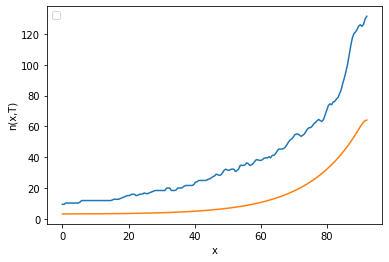

0.009406472343101952
84.7185028749444
28185.762312009185
9.883347527326556
30.42281985474868


oxigeno [2.29866662e-37 2.44054266e-37 2.88368422e-37 3.68281089e-37
 4.93663944e-37 6.80012297e-37 9.50367945e-37 1.33818135e-36
 1.89147138e-36 2.67880428e-36 3.79784267e-36 5.38754052e-36
 7.64552164e-36 1.08528377e-35 1.54092409e-35 2.18834484e-35
 3.10847944e-35 4.41654086e-35 6.27659885e-35 8.92238577e-35
 1.26870064e-34 1.80453825e-34 2.56749227e-34 3.65422866e-34
 5.20275366e-34 7.41018836e-34 1.05582312e-33 1.50496547e-33
 2.14606508e-33 3.06159528e-33 4.36967146e-33 6.23955331e-33
 8.91393656e-33 1.27410301e-32 1.82207466e-32 2.60712649e-32
 3.73250201e-32 5.34672375e-32 7.66360206e-32 1.09911575e-31
 1.57734618e-31 2.26512167e-31 3.25495398e-31 4.68052814e-31
 6.73518430e-31 9.69877028e-31 1.39766925e-30 2.01567594e-30
 2.90920029e-30 4.20214678e-30 6.07465492e-30 8.78886812e-30
 1.27266296e-29 1.84446831e-29 2.67555926e-29 3.88464933e-29
 5.64535504e-29 8.21185463e-29 1.19566687e-28 1.74263537e-28
 2.54236978e-28 3.71291741e-28 5.42806193e-28 7.94393770e-28
 1.16385007e-27 

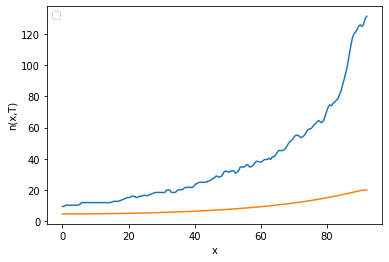

0.006081594440856987
103.57842587050168
28698.06327873779
3.142165278673934
49.01968952000638


oxigeno [3.52201208e-31 3.59729700e-31 3.82637026e-31 4.21904759e-31
 4.79219346e-31 5.57046558e-31 6.58740782e-31 7.88694237e-31
 9.52533132e-31 1.15737000e-30 1.41212418e-30 1.72792574e-30
 2.11862228e-30 2.60141298e-30 3.19764108e-30 3.93378335e-30
 4.84268580e-30 5.96510714e-30 7.35164772e-30 9.06516177e-30
 1.11837765e-29 1.38046742e-29 1.70488337e-29 2.10669824e-29
 2.60470725e-29 3.22236851e-29 3.98898696e-29 4.94120663e-29
 6.12489372e-29 7.59751558e-29 9.43114970e-29 1.17162942e-28
 1.45666993e-28 1.81255011e-28 2.25730183e-28 2.81366760e-28
 3.51036541e-28 4.38370285e-28 5.47963994e-28 6.85642915e-28
 8.58799854e-28 1.07682940e-27 1.35168601e-27 1.69860242e-27
 2.13701570e-27 2.69176308e-27 3.39462816e-27 4.28634372e-27
 5.41918979e-27 6.86036971e-27 8.69640420e-27 1.10388600e-26
 1.40318315e-26 1.78617279e-26 2.27701000e-26 2.90704791e-26
 3.71705243e-26 4.76012034e-26 6.10553141e-26 7.84384291e-26
 1.00936401e-25 1.30104982e-25 1.67989039e-25 2.17281444e-25
 2.81535279e-25 

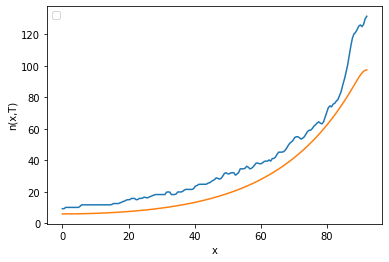

2
0.009586801779256936
126.16741667203476
27206.961641385715
8.14256789101552
41.78380485354319


oxigeno [1.13411801e-34 1.18444580e-34 1.33989587e-34 1.61427356e-34
 2.03196395e-34 2.63011544e-34 3.46197101e-34 4.60165075e-34
 6.15082176e-34 8.24786538e-34 1.10803828e-33 1.49021892e-33
 2.00563654e-33 2.70065019e-33 3.63790382e-33 4.90206493e-33
 6.60760527e-33 8.90935518e-33 1.20168282e-32 1.62136743e-32
 2.18841141e-32 2.95488833e-32 3.99141423e-32 5.39380734e-32
 7.29216290e-32 9.86322804e-32 1.33472898e-31 1.80712403e-31
 2.44801041e-31 3.31801679e-31 4.49980319e-31 6.10615322e-31
 8.29107308e-31 1.12650285e-30 1.53158819e-30 2.08376887e-30
 2.83703431e-30 3.86542118e-30 5.27055020e-30 7.19203349e-30
 9.82186125e-30 1.34243102e-29 1.83635236e-29 2.51417604e-29
 3.44525020e-29 4.72542716e-29 6.48733652e-29 8.91469863e-29
 1.22622918e-28 1.68838404e-28 2.32710155e-28 3.21080437e-28
 4.43482711e-28 6.13216493e-28 8.48858322e-28 1.17638866e-27
 1.63218990e-27 2.26727817e-27 3.15328511e-27 4.39092532e-27
 6.12200006e-27 8.54643882e-27 1.19465295e-26 1.67214220e-26
 2.34363355e-26 

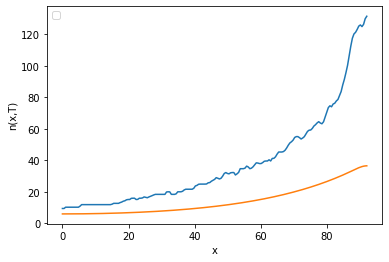

0.0006913063078641862
19.29882973907335
21260.084156868314
6.713801100011831
34.46974929104436


oxigeno [2.95069809e-51 3.28575860e-51 4.36703434e-51 6.44013033e-51
 9.97605955e-51 1.57784525e-50 2.51665898e-50 4.02760941e-50
 6.45460804e-50 1.03504348e-49 1.66030686e-49 2.66388363e-49
 4.27490898e-49 6.86156279e-49 1.10156012e-48 1.76883983e-48
 2.84099620e-48 4.56416597e-48 7.33444981e-48 1.17895039e-47
 1.89562198e-47 3.04889366e-47 4.90538439e-47 7.89495553e-47
 1.27109383e-46 2.04720795e-46 3.29843272e-46 5.31641966e-46
 8.57237579e-46 1.38279427e-45 2.23147589e-45 3.60253870e-45
 5.81848928e-45 9.40156142e-45 1.51977983e-44 2.45784684e-44
 3.97671683e-44 6.43712935e-44 1.04245972e-43 1.68899099e-43
 2.73777447e-43 4.43988131e-43 7.20359434e-43 1.16931621e-42
 1.89897814e-42 3.08541424e-42 5.01548088e-42 8.15675021e-42
 1.32717126e-41 2.16043693e-41 3.51852377e-41 5.73301386e-41
 9.34562443e-41 1.52417773e-40 2.48693188e-40 4.05968302e-40
 6.63008696e-40 1.08328828e-39 1.77078329e-39 2.89589050e-39
 4.73797767e-39 7.75526853e-39 1.26996705e-38 2.08055267e-38
 3.41000115e-38 

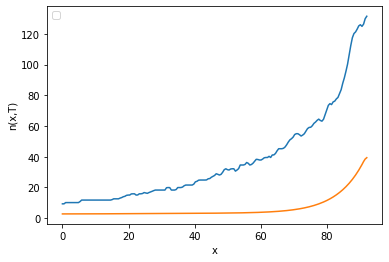

0.006423711068461726
139.61992915609667
25009.02415192865
2.226190407125345
27.75217468642419


oxigeno [5.36351346e-28 5.44551500e-28 5.69402703e-28 6.11667756e-28
 6.72648625e-28 7.54228416e-28 8.58932426e-28 9.90010422e-28
 1.15154305e-27 1.34857619e-27 1.58728797e-27 1.87519471e-27
 2.22140294e-27 2.63691711e-27 3.13501407e-27 3.73169861e-27
 4.44625693e-27 5.30192939e-27 6.32672834e-27 7.55443268e-27
 9.02579851e-27 1.07900336e-26 1.29065953e-26 1.54473840e-26
 1.84994238e-26 2.21681390e-26 2.65813674e-26 3.18942772e-26
 3.82954014e-26 4.60140513e-26 5.53294344e-26 6.65818840e-26
 8.01867054e-26 9.66512718e-26 1.16596158e-25 1.40781304e-25
 1.70138439e-25 2.05811335e-25 2.49205836e-25 3.02052122e-25
 3.66482324e-25 4.45127408e-25 5.41238271e-25 6.58837358e-25
 8.02908748e-25 9.79636847e-25 1.19670657e-24 1.46368147e-24
 1.79248073e-24 2.19798201e-24 2.69878433e-24 3.31817528e-24
 4.08535934e-24 5.03702021e-24 6.21931163e-24 7.69039853e-24
 9.52370623e-24 1.18120826e-23 1.46731389e-23 1.82561163e-23
 2.27507294e-23 2.83985776e-23 3.55078982e-23 4.44726751e-23
 5.57974393e-23 

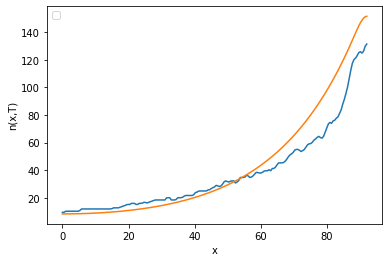

3
0.0015027509750462737
149.83065633774316
24063.244748065932
4.92750287056919
42.26529878536149


oxigeno [1.76580364e-29 1.78580680e-29 1.84626946e-29 1.94856294e-29
 2.09500950e-29 2.28893577e-29 2.53474942e-29 2.83804081e-29
 3.20571215e-29 3.64613714e-29 4.16935499e-29 4.78730337e-29
 5.51409594e-29 6.36635112e-29 7.36358000e-29 8.52864278e-29
 9.88828490e-29 1.14737658e-28 1.33215960e-28 1.54743998e-28
 1.79819264e-28 2.09022331e-28 2.43030701e-28 2.82635035e-28
 3.28758144e-28 3.82477250e-28 4.45050064e-28 5.17945362e-28
 6.02878838e-28 7.01855170e-28 8.17217397e-28 9.51704903e-28
 1.10852154e-27 1.29141572e-27 1.50477462e-27 1.75373502e-27
 2.04431391e-27 2.38356228e-27 2.77974654e-27 3.24256261e-27
 3.78338858e-27 4.41558344e-27 5.15484025e-27 6.01960409e-27
 7.03156723e-27 8.21625602e-27 9.60372739e-27 1.12293959e-26
 1.31350171e-26 1.53698574e-26 1.79920877e-26 2.10704454e-26
 2.46862178e-26 2.89356127e-26 3.39325948e-26 3.98122828e-26
 4.67350243e-26 5.48912888e-26 6.45075517e-26 7.58533794e-26
 8.92499719e-26 1.05080479e-25 1.23802475e-25 1.45963070e-25
 1.72217238e-25 

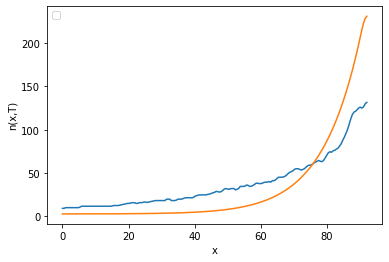

0.0009697782623889602
108.50374062839137
24863.00761641912
9.091814032421873
30.870183291724175


oxigeno [8.39899873e-33 8.63306969e-33 9.34832917e-33 1.05846581e-32
 1.24110158e-32 1.49293031e-32 1.82800732e-32 2.26504155e-32
 2.82844567e-32 3.54970736e-32 4.46915961e-32 5.63825041e-32
 7.12244078e-32 9.00489606e-32 1.13911807e-31 1.44152245e-31
 1.82469007e-31 2.31016506e-31 2.92527047e-31 3.70466032e-31
 4.69229073e-31 5.94392361e-31 7.53030744e-31 9.54121874e-31
 1.20905982e-30 1.53230791e-30 1.94222878e-30 2.46213978e-30
 3.12165542e-30 3.95839512e-30 5.02015625e-30 6.36767978e-30
 8.07817097e-30 1.02497823e-29 1.30073228e-29 1.65095315e-29
 2.09583448e-29 2.66107083e-29 3.37936349e-29 4.29234062e-29
 5.45300640e-29 6.92886563e-29 8.80591138e-29 1.11937152e-28
 1.42319265e-28 1.80985742e-28 2.30206728e-28 2.92877760e-28
 3.72693050e-28 4.74367055e-28 6.03917921e-28 7.69030166e-28
 9.79518934e-28 1.24792446e-27 1.59027353e-27 2.02705524e-27
 2.58447177e-27 3.29604241e-27 4.20466138e-27 5.36523888e-27
 6.84809225e-27 8.74330222e-27 1.11663114e-26 1.42651228e-26
 1.82295606e-26 

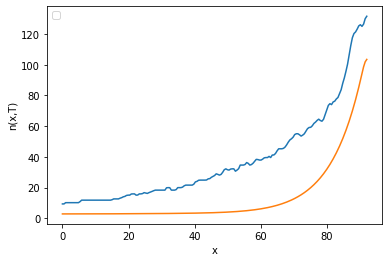

0.0029727689178327622
51.06427465467499
21644.464560206517
1.9801053653032716
31.629283076056012


oxigeno [3.01340873e-31 3.06087159e-31 3.20475531e-31 3.44960229e-31
 3.80315825e-31 4.27662392e-31 4.88502003e-31 5.64767852e-31
 6.58887649e-31 7.73863516e-31 9.13371140e-31 1.08188167e-30
 1.28481060e-30 1.52869902e-30 1.82143349e-30 2.17251262e-30
 2.59336984e-30 3.09776417e-30 3.70225327e-30 4.42676616e-30
 5.29529714e-30 6.33674663e-30 7.58594103e-30 9.08487034e-30
 1.08841913e-29 1.30450542e-29 1.56413258e-29 1.87622950e-29
 2.25159706e-29 2.70331043e-29 3.24721016e-29 3.90250248e-29
 4.69249371e-29 5.64548959e-29 6.79589801e-29 8.18558236e-29
 9.86552443e-29 1.18978700e-28 1.43584482e-28 1.73398780e-28
 2.09554032e-28 2.53436336e-28 3.06744122e-28 3.71560877e-28
 4.50445385e-28 5.46543882e-28 6.63729610e-28 8.06776742e-28
 9.81577443e-28 1.19541316e-27 1.45729426e-27 1.77838573e-27
 2.17254193e-27 2.65697891e-27 3.25312167e-27 3.98767304e-27
 4.89396508e-27 6.01367016e-27 7.39897152e-27 9.11532171e-27
 1.12449545e-26 1.38913647e-26 1.71850329e-26 2.12907568e-26
 2.64170566e-26 

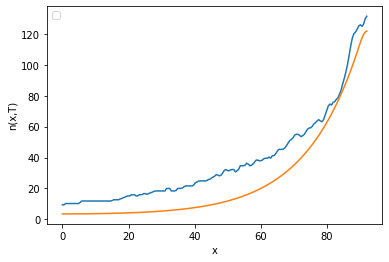

4
0.0028742087907904787
72.6501668977127
21012.649258010802
6.429882738728861
26.29560366533692


oxigeno [1.83972379e-35 1.90038618e-35 2.08637387e-35 2.40995901e-35
 2.89250568e-35 3.56588977e-35 4.47461997e-35 5.67880295e-35
 7.25815291e-35 9.31731704e-35 1.19928780e-34 1.54625097e-34
 1.99569102e-34 2.57753272e-34 3.33057410e-34 4.30510914e-34
 5.56633569e-34 7.19878452e-34 9.31207669e-34 1.20484105e-33
 1.55923010e-33 2.01832563e-33 2.61322819e-33 3.38433820e-33
 4.38415836e-33 5.68094811e-33 7.36349202e-33 9.54732501e-33
 1.23828644e-32 1.60660395e-32 2.08521938e-32 2.70742806e-32
 3.51666923e-32 4.56964899e-32 5.94043613e-32 7.72583755e-32
 1.00524586e-31 1.30859837e-31 1.70433848e-31 2.22089956e-31
 2.89556913e-31 3.77728230e-31 4.93030905e-31 6.43912606e-31
 8.41485958e-31 1.10038143e-30 1.43987744e-30 1.88539943e-30
 2.47051028e-30 3.23955606e-30 4.25118678e-30 5.58304674e-30
 7.33803025e-30 9.65263519e-30 1.27081313e-29 1.67455105e-29
 2.20855252e-29 2.91555820e-29 3.85258836e-29 5.09580669e-29
 6.74707493e-29 8.94279885e-29 1.18658842e-28 1.57619204e-28
 2.09611203e-28 

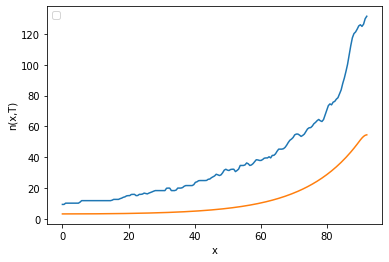

0.0022769002820613596
121.77387887470971
27210.386813296947
7.812780949331726
44.59228453982923


oxigeno [3.30875296e-33 3.38517072e-33 3.61795381e-33 4.01786263e-33
 4.60339645e-33 5.40165682e-33 6.44961409e-33 7.79583740e-33
 9.50277054e-33 1.16496625e-32 1.43362932e-32 1.76876724e-32
 2.18599397e-32 2.70477486e-32 3.34934936e-32 4.14988277e-32
 5.14390329e-32 6.37809459e-32 7.91053201e-32 9.81347254e-32
 1.21768370e-31 1.51125569e-31 1.87600040e-31 2.32927739e-31
 2.89271663e-31 3.59327899e-31 4.46458344e-31 5.54856844e-31
 6.89757327e-31 8.57694674e-31 1.06683189e-30 1.32737065e-30
 1.65206694e-30 2.05687879e-30 2.56178101e-30 3.19179014e-30
 3.97825526e-30 4.96048454e-30 6.18779665e-30 7.72210993e-30
 9.64121305e-30 1.20429000e-29 1.50502027e-29 1.88180177e-29
 2.35415077e-29 2.94667617e-29 3.69043358e-29 4.62464694e-29
 5.79889976e-29 7.27592720e-29 9.13517742e-29 1.14773595e-28
 1.44302580e-28 1.81561757e-28 2.28614722e-28 2.88088046e-28
 3.63328549e-28 4.58605654e-28 5.79372099e-28 7.32600297e-28
 9.27216939e-28 1.17466535e-27 1.48963426e-27 1.89100373e-27
 2.40307487e-27 

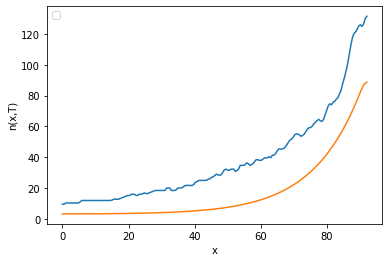

5
SMC step with target distance: 250.0
[array([6.69059751e-03, 1.43594551e+02, 2.71381412e+04, 7.41028572e+00,
       4.74375926e+01]), array([6.08159444e-03, 1.03578426e+02, 2.86980633e+04, 3.14216528e+00,
       4.90196895e+01]), array([6.42371107e-03, 1.39619929e+02, 2.50090242e+04, 2.22619041e+00,
       2.77521747e+01]), array([2.97276892e-03, 5.10642747e+01, 2.16444646e+04, 1.98010537e+00,
       3.16292831e+01]), array([2.27690028e-03, 1.21773879e+02, 2.72103868e+04, 7.81278095e+00,
       4.45922845e+01])]
[[ 8.75918980e-06  9.02511901e-02  4.46595081e+00 -1.84522266e-03
   4.70209018e-03]
 [ 9.02511901e-02  2.82033159e+03  1.31541096e+05  1.13258711e+02
   1.87867647e+02]
 [ 4.46595081e+00  1.31541096e+05  1.49873393e+07  8.44580482e+03
   4.34906360e+04]
 [-1.84522266e-03  1.13258711e+02  8.44580482e+03  1.64035257e+01
   3.67739430e+01]
 [ 4.70209018e-03  1.87867647e+02  4.34906360e+04  3.67739430e+01
   1.88901315e+02]]
after perturb [0.004875423710646073, 114.2960442973094

oxigeno [3.10120567e-34 3.18916515e-34 3.45803317e-34 3.92308127e-34
 4.61075959e-34 5.56022470e-34 6.82560708e-34 8.47915365e-34
 1.06154334e-33 1.33568591e-33 1.68608586e-33 2.13291299e-33
 2.70195453e-33 3.42614330e-33 4.34751771e-33 5.51973512e-33
 7.01129505e-33 8.90967429e-33 1.13266348e-32 1.44050414e-32
 1.83276243e-32 2.33282520e-32 2.97064417e-32 3.78460575e-32
 4.82394227e-32 6.15184432e-32 7.84948189e-32 1.00212045e-31
 1.28012729e-31 1.63625816e-31 2.09279737e-31 2.67849329e-31
 3.43046820e-31 4.39670368e-31 5.63927860e-31 7.23859259e-31
 9.29888128e-31 1.19554272e-30 1.53839993e-30 1.98132252e-30
 2.55408282e-30 3.29549643e-30 4.25622989e-30 5.50250004e-30
 7.12095528e-30 9.22512522e-30 1.19639549e-29 1.55331143e-29
 2.01900068e-29 2.62737186e-29 3.42315744e-29 4.46545444e-29
 5.83245278e-29 7.62775987e-29 9.98887438e-29 1.30985587e-28
 1.72001275e-28 2.26180374e-28 2.97856635e-28 3.92828410e-28
 5.18866949e-28 6.86405917e-28 9.09478488e-28 1.20699336e-27
 1.60447567e-27 

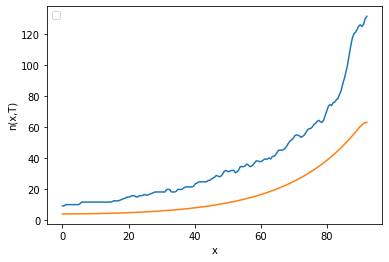

[array([6.69059751e-03, 1.43594551e+02, 2.71381412e+04, 7.41028572e+00,
       4.74375926e+01]), array([6.08159444e-03, 1.03578426e+02, 2.86980633e+04, 3.14216528e+00,
       4.90196895e+01]), array([6.42371107e-03, 1.39619929e+02, 2.50090242e+04, 2.22619041e+00,
       2.77521747e+01]), array([2.97276892e-03, 5.10642747e+01, 2.16444646e+04, 1.98010537e+00,
       3.16292831e+01]), array([2.27690028e-03, 1.21773879e+02, 2.72103868e+04, 7.81278095e+00,
       4.45922845e+01])]
[[ 8.75918980e-06  9.02511901e-02  4.46595081e+00 -1.84522266e-03
   4.70209018e-03]
 [ 9.02511901e-02  2.82033159e+03  1.31541096e+05  1.13258711e+02
   1.87867647e+02]
 [ 4.46595081e+00  1.31541096e+05  1.49873393e+07  8.44580482e+03
   4.34906360e+04]
 [-1.84522266e-03  1.13258711e+02  8.44580482e+03  1.64035257e+01
   3.67739430e+01]
 [ 4.70209018e-03  1.87867647e+02  4.34906360e+04  3.67739430e+01
   1.88901315e+02]]
after perturb [0.0019789869768580635, 83.5145000524343, 32963.106008235896, 4.932950871166073

oxigeno [5.30405681e-31 5.39937248e-31 5.68874522e-31 6.18260551e-31
 6.89880428e-31 7.86328093e-31 9.11103854e-31 1.06874654e-30
 1.26500559e-30 1.50706009e-30 1.80379367e-30 2.16613655e-30
 2.60748886e-30 3.14424299e-30 3.79642674e-30 4.58849471e-30
 5.55030157e-30 6.71829940e-30 8.13701098e-30 9.86084394e-30
 1.19563262e-29 1.45048630e-29 1.76061395e-29 2.13823266e-29
 2.59832809e-29 3.15929856e-29 3.84375325e-29 4.67950289e-29
 5.70079051e-29 6.94982246e-29 8.47867504e-29 1.03516720e-28
 1.26483531e-28 1.54671847e-28 1.89302048e-28 2.31888458e-28
 2.84312415e-28 3.48914129e-28 4.28608275e-28 5.27029713e-28
 6.48717406e-28 7.99346930e-28 9.86024828e-28 1.21766185e-27
 1.50544691e-27 1.86345000e-27 2.30939016e-27 2.86561557e-27
 3.56035611e-27 4.42932713e-27 5.51778611e-27 6.88317485e-27
 8.59851982e-27 1.07568159e-26 1.34766883e-26 1.69097183e-26
 2.12499404e-26 2.67461762e-26 3.37180844e-26 4.25770860e-26
 5.38537003e-26 6.82333259e-26 8.66031719e-26 1.10113938e-25
 1.40261049e-25 

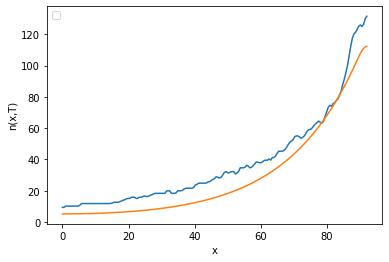

1
[array([6.69059751e-03, 1.43594551e+02, 2.71381412e+04, 7.41028572e+00,
       4.74375926e+01]), array([6.08159444e-03, 1.03578426e+02, 2.86980633e+04, 3.14216528e+00,
       4.90196895e+01]), array([6.42371107e-03, 1.39619929e+02, 2.50090242e+04, 2.22619041e+00,
       2.77521747e+01]), array([2.97276892e-03, 5.10642747e+01, 2.16444646e+04, 1.98010537e+00,
       3.16292831e+01]), array([2.27690028e-03, 1.21773879e+02, 2.72103868e+04, 7.81278095e+00,
       4.45922845e+01])]
[[ 8.75918980e-06  9.02511901e-02  4.46595081e+00 -1.84522266e-03
   4.70209018e-03]
 [ 9.02511901e-02  2.82033159e+03  1.31541096e+05  1.13258711e+02
   1.87867647e+02]
 [ 4.46595081e+00  1.31541096e+05  1.49873393e+07  8.44580482e+03
   4.34906360e+04]
 [-1.84522266e-03  1.13258711e+02  8.44580482e+03  1.64035257e+01
   3.67739430e+01]
 [ 4.70209018e-03  1.87867647e+02  4.34906360e+04  3.67739430e+01
   1.88901315e+02]]
after perturb [0.004664336316196857, 81.13403941855286, 23837.89046187527, 3.26856535936841

oxigeno [3.13169306e-32 3.19750711e-32 3.39771546e-32 3.74075099e-32
 4.24109272e-32 4.91989286e-32 5.80589587e-32 6.93669191e-32
 8.36036175e-32 1.01375891e-31 1.23443382e-31 1.50752207e-31
 1.84477112e-31 2.26074077e-31 2.77345899e-31 3.40523862e-31
 4.18369448e-31 5.14301027e-31 6.32551719e-31 7.78366238e-31
 9.58246494e-31 1.18025831e-30 1.45441477e-30 1.79315581e-30
 2.21194874e-30 2.73004102e-30 3.37140483e-30 4.16592349e-30
 5.15088341e-30 6.37285212e-30 7.89004528e-30 9.77531312e-30
 1.21199131e-29 1.50382816e-29 1.86740761e-29 2.32078366e-29
 2.88667123e-29 3.59368259e-29 4.47790130e-29 5.58488834e-29
 6.97224285e-29 8.71287522e-29 1.08991968e-28 1.36484910e-28
 1.71098080e-28 2.14728310e-28 2.69792925e-28 3.39376991e-28
 4.27423530e-28 5.38979639e-28 6.80515465e-28 8.60338306e-28
 1.08913110e-27 1.38065388e-27 1.75265916e-27 2.22808856e-27
 2.83663994e-27 3.61682356e-27 4.61866492e-27 5.90726428e-27
 7.56749366e-27 9.71020668e-27 1.24804650e-26 1.60684583e-26
 2.07240288e-26 

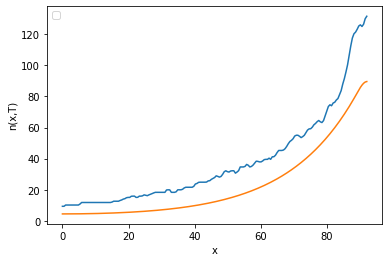

2
[array([6.69059751e-03, 1.43594551e+02, 2.71381412e+04, 7.41028572e+00,
       4.74375926e+01]), array([6.08159444e-03, 1.03578426e+02, 2.86980633e+04, 3.14216528e+00,
       4.90196895e+01]), array([6.42371107e-03, 1.39619929e+02, 2.50090242e+04, 2.22619041e+00,
       2.77521747e+01]), array([2.97276892e-03, 5.10642747e+01, 2.16444646e+04, 1.98010537e+00,
       3.16292831e+01]), array([2.27690028e-03, 1.21773879e+02, 2.72103868e+04, 7.81278095e+00,
       4.45922845e+01])]
[[ 8.75918980e-06  9.02511901e-02  4.46595081e+00 -1.84522266e-03
   4.70209018e-03]
 [ 9.02511901e-02  2.82033159e+03  1.31541096e+05  1.13258711e+02
   1.87867647e+02]
 [ 4.46595081e+00  1.31541096e+05  1.49873393e+07  8.44580482e+03
   4.34906360e+04]
 [-1.84522266e-03  1.13258711e+02  8.44580482e+03  1.64035257e+01
   3.67739430e+01]
 [ 4.70209018e-03  1.87867647e+02  4.34906360e+04  3.67739430e+01
   1.88901315e+02]]
after perturb [-0.003985111685831464, 91.67200305739294, 27343.532319459875, 15.94289213880

oxigeno [2.18602974e-30 2.23123156e-30 2.36870635e-30 2.60415397e-30
 2.94736090e-30 3.41261965e-30 4.01934387e-30 4.79290726e-30
 5.76574458e-30 6.97876558e-30 8.48314719e-30 1.03425877e-29
 1.26361288e-29 1.54616787e-29 1.89404046e-29 2.32222054e-29
 2.84925304e-29 3.49808759e-29 4.29713807e-29 5.28160462e-29
 6.49512450e-29 7.99183561e-29 9.83895819e-29 1.21200281e-28
 1.49389504e-28 1.84250871e-28 2.27396500e-28 2.80837420e-28
 3.47084850e-28 4.29277902e-28 5.31344800e-28 6.58206673e-28
 8.16035468e-28 1.01258081e-27 1.25758477e-27 1.56330883e-27
 1.94520443e-27 2.42276725e-27 3.02062721e-27 3.76994109e-27
 4.71017449e-27 5.89138521e-27 7.37715349e-27 9.24834818e-27
 1.16079745e-26 1.45874238e-26 1.83545436e-26 2.31240747e-26
 2.91711708e-26 3.68489414e-26 4.66112510e-26 5.90424019e-26
 7.48958428e-26 9.51447361e-26 1.21048133e-25 1.54237729e-25
 1.96831798e-25 2.51585109e-25 3.22086529e-25 4.13019993e-25
 5.30509792e-25 6.82578314e-25 8.79754036e-25 1.13588065e-24
 1.46919606e-24 

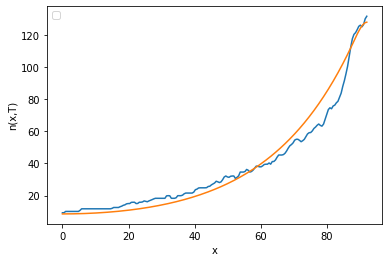

3
[array([6.69059751e-03, 1.43594551e+02, 2.71381412e+04, 7.41028572e+00,
       4.74375926e+01]), array([6.08159444e-03, 1.03578426e+02, 2.86980633e+04, 3.14216528e+00,
       4.90196895e+01]), array([6.42371107e-03, 1.39619929e+02, 2.50090242e+04, 2.22619041e+00,
       2.77521747e+01]), array([2.97276892e-03, 5.10642747e+01, 2.16444646e+04, 1.98010537e+00,
       3.16292831e+01]), array([2.27690028e-03, 1.21773879e+02, 2.72103868e+04, 7.81278095e+00,
       4.45922845e+01])]
[[ 8.75918980e-06  9.02511901e-02  4.46595081e+00 -1.84522266e-03
   4.70209018e-03]
 [ 9.02511901e-02  2.82033159e+03  1.31541096e+05  1.13258711e+02
   1.87867647e+02]
 [ 4.46595081e+00  1.31541096e+05  1.49873393e+07  8.44580482e+03
   4.34906360e+04]
 [-1.84522266e-03  1.13258711e+02  8.44580482e+03  1.64035257e+01
   3.67739430e+01]
 [ 4.70209018e-03  1.87867647e+02  4.34906360e+04  3.67739430e+01
   1.88901315e+02]]
after perturb [0.008465000345998706, 119.67607205840292, 26234.63596110849, 3.4485168878259

oxigeno [1.31796159e-31 1.35446168e-31 1.46598363e-31 1.65871397e-31
 1.94336118e-31 2.33576168e-31 2.85777854e-31 3.53854595e-31
 4.41613268e-31 5.53972320e-31 6.97244639e-31 8.79502110e-31
 1.11104380e-30 1.40499610e-30 1.77808141e-30 2.25160236e-30
 2.85270247e-30 3.61598126e-30 4.58556502e-30 5.81776346e-30
 7.38448073e-30 9.37759877e-30 1.19146150e-29 1.51459001e-29
 1.92640501e-29 2.45159493e-29 3.12183443e-29 3.97779739e-29
 5.07176119e-29 6.47097979e-29 8.26205732e-29 1.05566251e-28
 1.34987192e-28 1.72743788e-28 2.21241483e-28 2.83593825e-28
 3.63835358e-28 4.67199952e-28 6.00485130e-28 7.72529603e-28
 9.94839972e-28 1.28241432e-27 1.65482599e-27 2.13765177e-27
 2.76435637e-27 3.57878280e-27 4.63844794e-27 6.01891003e-27
 7.81956546e-27 1.01713540e-26 1.32470168e-26 1.72747725e-26
 2.25565825e-26 2.94925790e-26 3.86137925e-26 5.06260678e-26
 6.64690908e-26 8.73958596e-26 1.15079862e-25 1.51759869e-25
 2.00435881e-25 2.65134779e-25 3.51271104e-25 4.66137931e-25
 6.19575964e-25 

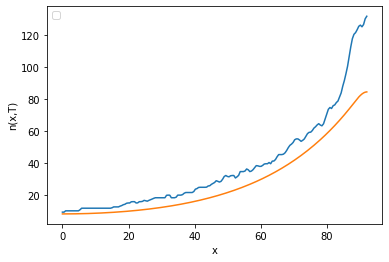

4
[array([6.69059751e-03, 1.43594551e+02, 2.71381412e+04, 7.41028572e+00,
       4.74375926e+01]), array([6.08159444e-03, 1.03578426e+02, 2.86980633e+04, 3.14216528e+00,
       4.90196895e+01]), array([6.42371107e-03, 1.39619929e+02, 2.50090242e+04, 2.22619041e+00,
       2.77521747e+01]), array([2.97276892e-03, 5.10642747e+01, 2.16444646e+04, 1.98010537e+00,
       3.16292831e+01]), array([2.27690028e-03, 1.21773879e+02, 2.72103868e+04, 7.81278095e+00,
       4.45922845e+01])]
[[ 8.75918980e-06  9.02511901e-02  4.46595081e+00 -1.84522266e-03
   4.70209018e-03]
 [ 9.02511901e-02  2.82033159e+03  1.31541096e+05  1.13258711e+02
   1.87867647e+02]
 [ 4.46595081e+00  1.31541096e+05  1.49873393e+07  8.44580482e+03
   4.34906360e+04]
 [-1.84522266e-03  1.13258711e+02  8.44580482e+03  1.64035257e+01
   3.67739430e+01]
 [ 4.70209018e-03  1.87867647e+02  4.34906360e+04  3.67739430e+01
   1.88901315e+02]]
after perturb [0.008367136133114619, 217.64323367327006, 30145.96057883217, 5.4147273961260

oxigeno [5.20726664e-32 5.32576691e-32 5.68666106e-32 6.30640374e-32
 7.21330159e-32 8.44883393e-32 1.00695941e-31 1.21499460e-31
 1.47855264e-31 1.80977637e-31 2.22396389e-31 2.74029727e-31
 3.38276031e-31 4.18129157e-31 5.17323087e-31 6.40513282e-31
 7.93504040e-31 9.83533577e-31 1.21963165e-30 1.51306844e-30
 1.87791837e-30 2.33176879e-30 2.89661160e-30 3.59996581e-30
 4.47629230e-30 5.56877842e-30 6.93159122e-30 8.63272536e-30
 1.07576060e-29 1.34136518e-29 1.67360601e-29 2.08951490e-29
 2.61056862e-29 3.26387558e-29 4.08368706e-29 5.11332393e-29
 6.40763631e-29 8.03614712e-29 1.00870749e-28 1.26724884e-28
 1.59349197e-28 2.00558602e-28 2.52666899e-28 3.18627562e-28
 4.02215355e-28 5.08260948e-28 6.42954432e-28 8.14238558e-28
 1.03231897e-27 1.31032728e-27 1.66518405e-27 2.11872378e-27
 2.69916378e-27 3.44302512e-27 4.39764905e-27 5.62449896e-27
 7.20350047e-27 9.23875609e-27 1.18660829e-26 1.52629728e-26
 1.96617777e-26 2.53671964e-26 3.27795097e-26 4.24255126e-26
 5.49997728e-26 

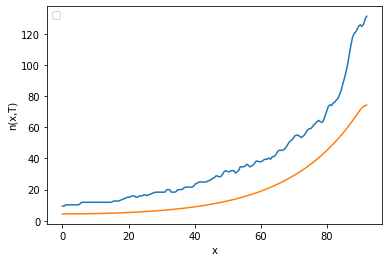

[array([6.69059751e-03, 1.43594551e+02, 2.71381412e+04, 7.41028572e+00,
       4.74375926e+01]), array([6.08159444e-03, 1.03578426e+02, 2.86980633e+04, 3.14216528e+00,
       4.90196895e+01]), array([6.42371107e-03, 1.39619929e+02, 2.50090242e+04, 2.22619041e+00,
       2.77521747e+01]), array([2.97276892e-03, 5.10642747e+01, 2.16444646e+04, 1.98010537e+00,
       3.16292831e+01]), array([2.27690028e-03, 1.21773879e+02, 2.72103868e+04, 7.81278095e+00,
       4.45922845e+01])]
[[ 8.75918980e-06  9.02511901e-02  4.46595081e+00 -1.84522266e-03
   4.70209018e-03]
 [ 9.02511901e-02  2.82033159e+03  1.31541096e+05  1.13258711e+02
   1.87867647e+02]
 [ 4.46595081e+00  1.31541096e+05  1.49873393e+07  8.44580482e+03
   4.34906360e+04]
 [-1.84522266e-03  1.13258711e+02  8.44580482e+03  1.64035257e+01
   3.67739430e+01]
 [ 4.70209018e-03  1.87867647e+02  4.34906360e+04  3.67739430e+01
   1.88901315e+02]]
after perturb [0.004847481691940912, -8.654083615047284, 21524.51282450732, -1.36580521667689

oxigeno [5.29836612e-29 5.41241886e-29 5.75948729e-29 6.35454658e-29
 7.22332843e-29 8.40346367e-29 9.94615959e-29 1.19184904e-28
 1.44064090e-28 1.75186220e-28 2.13915127e-28 2.61953475e-28
 3.21420645e-28 3.94950217e-28 4.85811813e-28 5.98063283e-28
 7.36740782e-28 9.08096223e-28 1.11989406e-27 1.38178249e-27
 1.70575796e-27 2.10674718e-27 2.60333662e-27 3.21868814e-27
 3.98168901e-27 4.92839797e-27 6.10386535e-27 7.56442638e-27
 9.38059384e-27 1.16407107e-26 1.44555676e-26 1.79642465e-26
 2.23415250e-26 2.78072690e-26 3.46383619e-26 4.31838734e-26
 5.38843733e-26 6.72965515e-26 8.41246432e-26 1.05260594e-25
 1.31835459e-25 1.65285275e-25 2.07435577e-25 2.60610014e-25
 3.27770104e-25 4.12695324e-25 5.20215506e-25 6.56511167e-25
 8.29502216e-25 1.04935177e-24 1.32912017e-24 1.68561534e-24
 2.14049998e-24 2.72173566e-24 3.46546916e-24 4.41850059e-24
 5.64151787e-24 7.21334265e-24 9.23651333e-24 1.18446385e-23
 1.52120990e-23 1.95668711e-23 2.52075040e-23 3.25256386e-23
 4.20359280e-23 

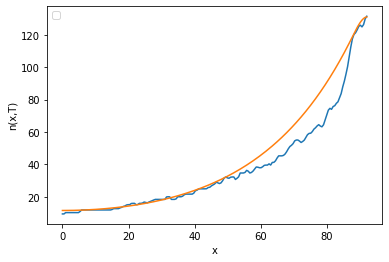

5
parameters [0.005016825084947657, 71.52913353745596, 21675.844909437394, 2.118595654471621, 31.46594353356737]
parameters [0.004664336316196857, 81.13403941855286, 23837.89046187527, 3.2685653593684125, 37.71238117752385]
parameters [0.0071835675835412, 98.46609330567307, 26929.9491820901, 2.021006784449663, 44.50288492603316]
parameters [0.008465000345998706, 119.67607205840292, 26234.63596110849, 3.448516887825983, 43.86700395931948]
parameters [0.00875082315366287, 147.38872420435902, 26218.902568353253, 2.371358673435046, 34.749240564879436]
SMC step with target distance: 180.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


[[0.005016825084947657, 71.52913353745596, 21675.844909437394, 2.118595654471621, 31.46594353356737], [0.004664336316196857, 81.13403941855286, 23837.89046187527, 3.2685653593684125, 37.71238117752385], [0.0071835675835412, 98.46609330567307, 26929.9491820901, 2.021006784449663, 44.50288492603316], [0.008465000345998706, 119.67607205840292, 26234.63596110849, 3.448516887825983, 43.86700395931948], [0.00875082315366287, 147.38872420435902, 26218.902568353253, 2.371358673435046, 34.749240564879436]]
[[7.23226781e-06 1.07693048e-01 6.79243975e+00 8.57912962e-05
  9.07490612e-03]
 [1.07693048e-01 1.86775089e+03 9.80172681e+04 3.50582216e+00
  6.72559406e+01]
 [6.79243975e+00 9.80172681e+04 9.56657315e+06 2.39747262e+02
  1.89665896e+04]
 [8.57912962e-05 3.50582216e+00 2.39747262e+02 8.87909969e-01
  2.40241550e+00]
 [9.07490612e-03 6.72559406e+01 1.89665896e+04 2.40241550e+00
  6.44988220e+01]]
after perturb [0.008196635106484006, 162.40869418838662, 24844.42330055753, 0.1498658725995874, 

oxigeno [9.15690493e-31 9.35098015e-31 9.94143241e-31 1.09533451e-30
 1.24297988e-30 1.44337538e-30 1.70508124e-30 2.03929869e-30
 2.46036483e-30 2.98638872e-30 3.64005821e-30 4.44965571e-30
 5.45033088e-30 6.68569104e-30 8.20978545e-30 1.00895798e-29
 1.24080409e-29 1.52679840e-29 1.87968724e-29 2.31528089e-29
 2.85320218e-29 3.51782242e-29 4.33943270e-29 5.35571104e-29
 6.61356190e-29 8.17142495e-29 1.01021757e-28 1.24967734e-28
 1.54688546e-28 1.91605219e-28 2.37496498e-28 2.94591136e-28
 3.65684627e-28 4.54287021e-28 5.64810339e-28 7.02806486e-28
 8.75269649e-28 1.09102115e-27 1.36119991e-27 1.69988823e-27
 2.12491154e-27 2.65886154e-27 3.33040732e-27 4.17597767e-27
 5.24192284e-27 6.58729655e-27 8.28744146e-27 1.04386172e-26
 1.31639831e-26 1.66213448e-26 2.10132001e-26 2.65997870e-26
 3.37160606e-26 4.27938164e-26 5.43905694e-26 6.92273166e-26
 8.82380003e-26 1.12634411e-25 1.43991501e-25 1.84359730e-25
 2.36413279e-25 3.03645941e-25 3.90630514e-25 5.03362946e-25
 6.49719775e-25 

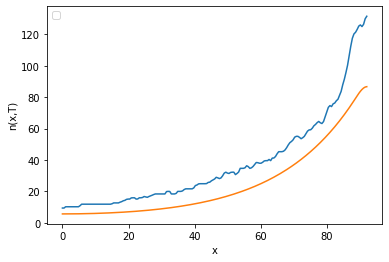

[[0.005016825084947657, 71.52913353745596, 21675.844909437394, 2.118595654471621, 31.46594353356737], [0.004664336316196857, 81.13403941855286, 23837.89046187527, 3.2685653593684125, 37.71238117752385], [0.0071835675835412, 98.46609330567307, 26929.9491820901, 2.021006784449663, 44.50288492603316], [0.008465000345998706, 119.67607205840292, 26234.63596110849, 3.448516887825983, 43.86700395931948], [0.00875082315366287, 147.38872420435902, 26218.902568353253, 2.371358673435046, 34.749240564879436]]
[[7.23226781e-06 1.07693048e-01 6.79243975e+00 8.57912962e-05
  9.07490612e-03]
 [1.07693048e-01 1.86775089e+03 9.80172681e+04 3.50582216e+00
  6.72559406e+01]
 [6.79243975e+00 9.80172681e+04 9.56657315e+06 2.39747262e+02
  1.89665896e+04]
 [8.57912962e-05 3.50582216e+00 2.39747262e+02 8.87909969e-01
  2.40241550e+00]
 [9.07490612e-03 6.72559406e+01 1.89665896e+04 2.40241550e+00
  6.44988220e+01]]
after perturb [0.010293255384916376, 161.87713350130605, 30799.88856939833, 1.030223620273211, 4

oxigeno [1.55278193e-28 1.57978191e-28 1.66172082e-28 1.80145763e-28
 2.00388343e-28 2.27609949e-28 2.62767715e-28 3.07100976e-28
 3.62177047e-28 4.29949427e-28 5.12830736e-28 6.13783347e-28
 7.36431379e-28 8.85198655e-28 1.06547831e-27 1.28384114e-27
 1.54829142e-27 1.86858105e-27 2.25659564e-27 2.72682892e-27
 3.29696664e-27 3.98860539e-27 4.82813867e-27 5.84784999e-27
 7.08726305e-27 8.59481103e-27 1.04299029e-26 1.26654838e-26
 1.53912125e-26 1.87174071e-26 2.27799535e-26 2.77464167e-26
 3.38236620e-26 4.12673676e-26 5.03939178e-26 6.15952893e-26
 7.53577101e-26 9.22850794e-26 1.13128403e-25 1.38822843e-25
 1.70534419e-25 2.09718951e-25 2.58196583e-25 3.18246123e-25
 3.92724661e-25 4.85219469e-25 6.00241202e-25 7.43469990e-25
 9.22069433e-25 1.14508786e-24 1.42397193e-24 1.77322516e-24
 2.21125364e-24 2.76145399e-24 3.45361537e-24 4.32572930e-24
 5.42633010e-24 6.81752673e-24 8.57893751e-24 1.08128058e-23
 1.36506636e-23 1.72620265e-23 2.18657631e-23 2.77449860e-23
 3.52665974e-23 

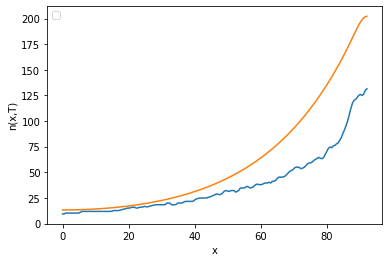

[[0.005016825084947657, 71.52913353745596, 21675.844909437394, 2.118595654471621, 31.46594353356737], [0.004664336316196857, 81.13403941855286, 23837.89046187527, 3.2685653593684125, 37.71238117752385], [0.0071835675835412, 98.46609330567307, 26929.9491820901, 2.021006784449663, 44.50288492603316], [0.008465000345998706, 119.67607205840292, 26234.63596110849, 3.448516887825983, 43.86700395931948], [0.00875082315366287, 147.38872420435902, 26218.902568353253, 2.371358673435046, 34.749240564879436]]
[[7.23226781e-06 1.07693048e-01 6.79243975e+00 8.57912962e-05
  9.07490612e-03]
 [1.07693048e-01 1.86775089e+03 9.80172681e+04 3.50582216e+00
  6.72559406e+01]
 [6.79243975e+00 9.80172681e+04 9.56657315e+06 2.39747262e+02
  1.89665896e+04]
 [8.57912962e-05 3.50582216e+00 2.39747262e+02 8.87909969e-01
  2.40241550e+00]
 [9.07490612e-03 6.72559406e+01 1.89665896e+04 2.40241550e+00
  6.44988220e+01]]
after perturb [0.0045688674410533, 66.34244284695795, 24591.92293373773, 1.6195039589911917, 38.

oxigeno [3.17930360e-30 3.22619363e-30 3.36824682e-30 3.60966996e-30
 3.95763899e-30 4.42252263e-30 5.01820730e-30 5.76253453e-30
 6.67786580e-30 7.79179428e-30 9.13802836e-30 1.07574778e-29
 1.26995810e-29 1.50239206e-29 1.78021855e-29 2.11205509e-29
 2.50825629e-29 2.98126352e-29 3.54602886e-29 4.22052932e-29
 5.02639107e-29 5.98964778e-29 7.14166272e-29 8.52025110e-29
 1.01710477e-28 1.21491748e-28 1.45212796e-28 1.73680245e-28
 2.07871361e-28 2.48971416e-28 2.98419541e-28 3.57965071e-28
 4.29736864e-28 5.16328703e-28 6.20904659e-28 7.47329251e-28
 9.00328470e-28 1.08568928e-27 1.31050713e-27 1.58349350e-27
 1.91535867e-27 2.31928866e-27 2.81154070e-27 3.41218766e-27
 4.14605025e-27 5.04386626e-27 6.14375963e-27 7.49308914e-27
 9.15077893e-27 1.11902616e-26 1.37032011e-26 1.68042111e-26
 2.06368446e-26 2.53812130e-26 3.12636945e-26 3.85693289e-26
 4.76576719e-26 5.89831155e-26 7.31209813e-26 9.08010968e-26
 1.12951087e-25 1.40752305e-25 1.75712252e-25 2.19758526e-25
 2.75360991e-25 

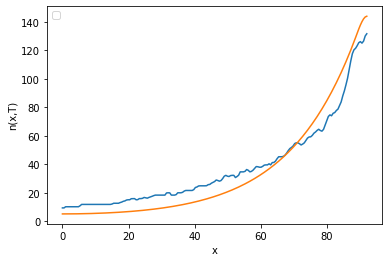

1
[[0.005016825084947657, 71.52913353745596, 21675.844909437394, 2.118595654471621, 31.46594353356737], [0.004664336316196857, 81.13403941855286, 23837.89046187527, 3.2685653593684125, 37.71238117752385], [0.0071835675835412, 98.46609330567307, 26929.9491820901, 2.021006784449663, 44.50288492603316], [0.008465000345998706, 119.67607205840292, 26234.63596110849, 3.448516887825983, 43.86700395931948], [0.00875082315366287, 147.38872420435902, 26218.902568353253, 2.371358673435046, 34.749240564879436]]
[[7.23226781e-06 1.07693048e-01 6.79243975e+00 8.57912962e-05
  9.07490612e-03]
 [1.07693048e-01 1.86775089e+03 9.80172681e+04 3.50582216e+00
  6.72559406e+01]
 [6.79243975e+00 9.80172681e+04 9.56657315e+06 2.39747262e+02
  1.89665896e+04]
 [8.57912962e-05 3.50582216e+00 2.39747262e+02 8.87909969e-01
  2.40241550e+00]
 [9.07490612e-03 6.72559406e+01 1.89665896e+04 2.40241550e+00
  6.44988220e+01]]
after perturb [0.010894891404592964, 170.2479418321544, 31514.894076389108, 2.6456671715788396

oxigeno [1.08347607e-27 1.09910566e-27 1.14644537e-27 1.22686652e-27
 1.34270752e-27 1.49734518e-27 1.69529838e-27 1.94236741e-27
 2.24581384e-27 2.61458683e-27 3.05960368e-27 3.59409435e-27
 4.23402166e-27 4.99859201e-27 5.91087457e-27 6.99855088e-27
 8.29482183e-27 9.83950491e-27 1.16803618e-26 1.38747053e-26
 1.64913465e-26 1.96129539e-26 2.33389174e-26 2.77888247e-26
 3.31066883e-26 3.94660896e-26 4.70764449e-26 5.61906473e-26
 6.71143982e-26 8.02176135e-26 9.59483840e-26 1.14850081e-25
 1.37582344e-25 1.64946864e-25 1.97919094e-25 2.37687305e-25
 2.85700757e-25 3.43729178e-25 4.13936319e-25 4.98971038e-25
 6.02080248e-25 7.27249174e-25 8.79375780e-25 1.06448801e-24
 1.29001472e-24 1.56512419e-24 1.90114753e-24 2.31210926e-24
 2.81539322e-24 3.43257951e-24 4.19049825e-24 5.12255848e-24
 6.27042665e-24 7.68615045e-24 9.43485058e-24 1.15981382e-23
 1.42784611e-23 1.76046417e-23 2.17389440e-23 2.68861115e-23
 3.33049433e-23 4.13231507e-23 5.13564605e-23 6.39332235e-23
 7.97261766e-23 

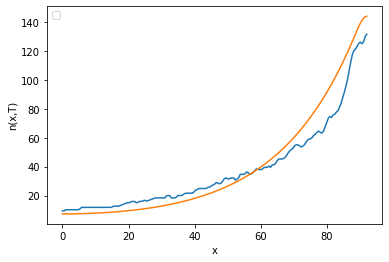

2
[[0.005016825084947657, 71.52913353745596, 21675.844909437394, 2.118595654471621, 31.46594353356737], [0.004664336316196857, 81.13403941855286, 23837.89046187527, 3.2685653593684125, 37.71238117752385], [0.0071835675835412, 98.46609330567307, 26929.9491820901, 2.021006784449663, 44.50288492603316], [0.008465000345998706, 119.67607205840292, 26234.63596110849, 3.448516887825983, 43.86700395931948], [0.00875082315366287, 147.38872420435902, 26218.902568353253, 2.371358673435046, 34.749240564879436]]
[[7.23226781e-06 1.07693048e-01 6.79243975e+00 8.57912962e-05
  9.07490612e-03]
 [1.07693048e-01 1.86775089e+03 9.80172681e+04 3.50582216e+00
  6.72559406e+01]
 [6.79243975e+00 9.80172681e+04 9.56657315e+06 2.39747262e+02
  1.89665896e+04]
 [8.57912962e-05 3.50582216e+00 2.39747262e+02 8.87909969e-01
  2.40241550e+00]
 [9.07490612e-03 6.72559406e+01 1.89665896e+04 2.40241550e+00
  6.44988220e+01]]
after perturb [0.010759180555420638, 171.30728247593842, 31829.774445838513, 2.730659469764370

oxigeno [6.89932004e-29 7.05059215e-29 7.51104195e-29 8.30090452e-29
 9.45496601e-29 1.10241358e-28 1.30777561e-28 1.57067583e-28
 1.90278183e-28 2.31887093e-28 2.83751118e-28 3.48192113e-28
 4.28105049e-28 5.27093497e-28 6.49639230e-28 8.01314444e-28
 9.89047264e-28 1.22145401e-27 1.50925521e-27 1.86579679e-27
 2.30770360e-27 2.85569939e-27 3.53563673e-27 4.37979174e-27
 5.42849323e-27 6.73217484e-27 8.35396242e-27 1.03729399e-26
 1.28882759e-26 1.60244434e-26 1.99378298e-26 2.48251171e-26
 3.09339175e-26 3.85762898e-26 4.81459340e-26 6.01400945e-26
 7.51874941e-26 9.40840047e-26 1.17838255e-25 1.47730019e-25
 1.85385066e-25 2.32871235e-25 2.92821932e-25 3.68595076e-25
 4.64477972e-25 5.85951738e-25 7.40033094e-25 9.35716789e-25
 1.18454912e-24 1.50137253e-24 1.90529368e-24 2.42094417e-24
 3.08012467e-24 3.92395262e-24 5.00567205e-24 6.39433564e-24
 8.17963753e-24 1.04782669e-23 1.34422752e-23 1.72701124e-23
 2.22212109e-23 2.86352877e-23 3.69579382e-23 4.77746307e-23
 6.18559399e-23 

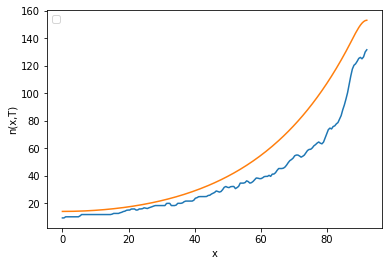

[[0.005016825084947657, 71.52913353745596, 21675.844909437394, 2.118595654471621, 31.46594353356737], [0.004664336316196857, 81.13403941855286, 23837.89046187527, 3.2685653593684125, 37.71238117752385], [0.0071835675835412, 98.46609330567307, 26929.9491820901, 2.021006784449663, 44.50288492603316], [0.008465000345998706, 119.67607205840292, 26234.63596110849, 3.448516887825983, 43.86700395931948], [0.00875082315366287, 147.38872420435902, 26218.902568353253, 2.371358673435046, 34.749240564879436]]
[[7.23226781e-06 1.07693048e-01 6.79243975e+00 8.57912962e-05
  9.07490612e-03]
 [1.07693048e-01 1.86775089e+03 9.80172681e+04 3.50582216e+00
  6.72559406e+01]
 [6.79243975e+00 9.80172681e+04 9.56657315e+06 2.39747262e+02
  1.89665896e+04]
 [8.57912962e-05 3.50582216e+00 2.39747262e+02 8.87909969e-01
  2.40241550e+00]
 [9.07490612e-03 6.72559406e+01 1.89665896e+04 2.40241550e+00
  6.44988220e+01]]
after perturb [0.009150744128202503, 148.8433436092253, 27786.830966277375, 3.330386902070352, 4

oxigeno [2.77366696e-30 2.84527472e-30 3.06379542e-30 3.44053080e-30
 3.99499838e-30 4.75596274e-30 5.76296011e-30 7.06840014e-30
 8.74036101e-30 1.08662330e-29 1.35574139e-29 1.69553191e-29
 2.12390458e-29 2.66351255e-29 3.34299217e-29 4.19853836e-29
 5.27590683e-29 6.63295953e-29 8.34290254e-29 1.04984076e-28
 1.32168621e-28 1.66470627e-28 2.09777559e-28 2.64485454e-28
 3.33638354e-28 4.21106719e-28 5.31815934e-28 6.72039275e-28
 8.49773906e-28 1.07522394e-27 1.36142172e-27 1.72502771e-27
 2.18736160e-27 2.77573275e-27 3.52515912e-27 4.48059047e-27
 5.69978750e-27 7.25705456e-27 9.24808547e-27 1.17962619e-26
 1.50608501e-26 1.92476828e-26 2.46230965e-26 3.15321423e-26
 4.04224118e-26 5.18752523e-26 6.66467212e-26 8.57213927e-26
 1.10383154e-25 1.42308487e-25 1.83689566e-25 2.37396936e-25
 3.07194832e-25 3.98026607e-25 5.16393689e-25 6.70859506e-25
 8.72720669e-25 1.13690236e-24 1.48315481e-24 1.93765470e-24
 2.53515223e-24 3.32185460e-24 4.35930523e-24 5.72961149e-24
 7.54250246e-24 

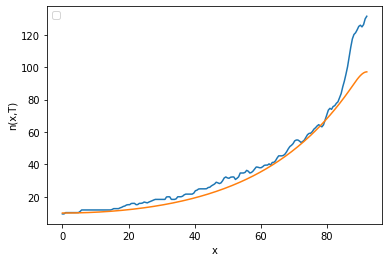

3
[[0.005016825084947657, 71.52913353745596, 21675.844909437394, 2.118595654471621, 31.46594353356737], [0.004664336316196857, 81.13403941855286, 23837.89046187527, 3.2685653593684125, 37.71238117752385], [0.0071835675835412, 98.46609330567307, 26929.9491820901, 2.021006784449663, 44.50288492603316], [0.008465000345998706, 119.67607205840292, 26234.63596110849, 3.448516887825983, 43.86700395931948], [0.00875082315366287, 147.38872420435902, 26218.902568353253, 2.371358673435046, 34.749240564879436]]
[[7.23226781e-06 1.07693048e-01 6.79243975e+00 8.57912962e-05
  9.07490612e-03]
 [1.07693048e-01 1.86775089e+03 9.80172681e+04 3.50582216e+00
  6.72559406e+01]
 [6.79243975e+00 9.80172681e+04 9.56657315e+06 2.39747262e+02
  1.89665896e+04]
 [8.57912962e-05 3.50582216e+00 2.39747262e+02 8.87909969e-01
  2.40241550e+00]
 [9.07490612e-03 6.72559406e+01 1.89665896e+04 2.40241550e+00
  6.44988220e+01]]
after perturb [0.003200915973902852, 102.31311587280933, 21935.109611617037, 3.929731963664881

oxigeno [3.60315254e-30 3.66022791e-30 3.83326222e-30 4.12774939e-30
 4.55305891e-30 5.12274200e-30 5.85497587e-30 6.77316154e-30
 7.90669584e-30 9.29194445e-30 1.09734501e-29 1.30054185e-29
 1.54535340e-29 1.83971708e-29 2.19320768e-29 2.61736295e-29
 3.12607797e-29 3.73608281e-29 4.46752110e-29 5.34465093e-29
 6.39669429e-29 7.65886708e-29 9.17362893e-29 1.09922006e-28
 1.31764076e-28 1.58009228e-28 1.89559946e-28 2.27507709e-28
 2.73173518e-28 3.28157342e-28 3.94398521e-28 4.74249612e-28
 5.70566770e-28 6.86820471e-28 8.27231299e-28 9.96936653e-28
 1.20219564e-27 1.45064116e-27 1.75159047e-27 2.11642814e-27
 2.55907893e-27 3.09659240e-27 3.74986649e-27 4.54454433e-27
 5.51212718e-27 6.69135730e-27 8.12993881e-27 9.88668176e-27
 1.20341776e-26 1.46621424e-26 1.78816001e-26 2.18301263e-26
 2.66784291e-26 3.26386228e-26 3.99746449e-26 4.90153947e-26
 6.01713291e-26 7.39554628e-26 9.10099856e-26 1.12140059e-25
 1.38356804e-25 1.70932076e-25 2.11468393e-25 2.61988367e-25
 3.25049305e-25 

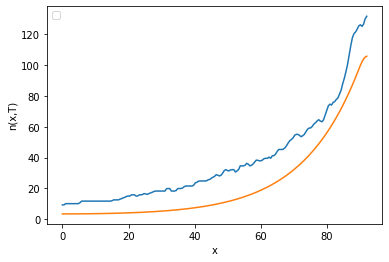

[[0.005016825084947657, 71.52913353745596, 21675.844909437394, 2.118595654471621, 31.46594353356737], [0.004664336316196857, 81.13403941855286, 23837.89046187527, 3.2685653593684125, 37.71238117752385], [0.0071835675835412, 98.46609330567307, 26929.9491820901, 2.021006784449663, 44.50288492603316], [0.008465000345998706, 119.67607205840292, 26234.63596110849, 3.448516887825983, 43.86700395931948], [0.00875082315366287, 147.38872420435902, 26218.902568353253, 2.371358673435046, 34.749240564879436]]
[[7.23226781e-06 1.07693048e-01 6.79243975e+00 8.57912962e-05
  9.07490612e-03]
 [1.07693048e-01 1.86775089e+03 9.80172681e+04 3.50582216e+00
  6.72559406e+01]
 [6.79243975e+00 9.80172681e+04 9.56657315e+06 2.39747262e+02
  1.89665896e+04]
 [8.57912962e-05 3.50582216e+00 2.39747262e+02 8.87909969e-01
  2.40241550e+00]
 [9.07490612e-03 6.72559406e+01 1.89665896e+04 2.40241550e+00
  6.44988220e+01]]
after perturb [0.0112433746736951, 184.80448713720602, 29753.164722761143, 2.500135701508876, 41

oxigeno [3.75471279e-30 3.82767071e-30 4.04937979e-30 4.42847871e-30
 4.97977637e-30 5.72484879e-30 6.69291256e-30 7.92201216e-30
 9.46057257e-30 1.13693843e-29 1.37241078e-29 1.66184061e-29
 2.01678466e-29 2.45147425e-29 2.98341542e-29 3.63413200e-29
 4.43008565e-29 5.40381511e-29 6.59534754e-29 8.05394813e-29
 9.84029051e-29 1.20291516e-28 1.47127608e-28 1.80049659e-28
 2.20464209e-28 2.70110529e-28 3.31141313e-28 4.06223493e-28
 4.98664315e-28 6.12569213e-28 7.53039713e-28 9.26421823e-28
 1.14061818e-27 1.40548081e-27 1.73330589e-27 2.13945794e-27
 2.64315821e-27 3.26848180e-27 4.04562062e-27 5.01248508e-27
 6.21673842e-27 7.71838404e-27 9.59306101e-27 1.19362478e-26
 1.48686327e-26 1.85429843e-26 2.31529558e-26 2.89443848e-26
 3.62298171e-26 4.54072074e-26 5.69840350e-26 7.16084542e-26
 9.01096010e-26 1.13549833e-25 1.43292552e-25 1.81090422e-25
 2.29200292e-25 2.90533216e-25 3.68850606e-25 4.69021203e-25
 5.97358334e-25 7.62063399e-25 9.73810137e-25 1.24651587e-24
 1.59836157e-24 

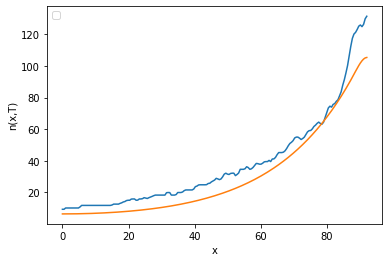

4
[[0.005016825084947657, 71.52913353745596, 21675.844909437394, 2.118595654471621, 31.46594353356737], [0.004664336316196857, 81.13403941855286, 23837.89046187527, 3.2685653593684125, 37.71238117752385], [0.0071835675835412, 98.46609330567307, 26929.9491820901, 2.021006784449663, 44.50288492603316], [0.008465000345998706, 119.67607205840292, 26234.63596110849, 3.448516887825983, 43.86700395931948], [0.00875082315366287, 147.38872420435902, 26218.902568353253, 2.371358673435046, 34.749240564879436]]
[[7.23226781e-06 1.07693048e-01 6.79243975e+00 8.57912962e-05
  9.07490612e-03]
 [1.07693048e-01 1.86775089e+03 9.80172681e+04 3.50582216e+00
  6.72559406e+01]
 [6.79243975e+00 9.80172681e+04 9.56657315e+06 2.39747262e+02
  1.89665896e+04]
 [8.57912962e-05 3.50582216e+00 2.39747262e+02 8.87909969e-01
  2.40241550e+00]
 [9.07490612e-03 6.72559406e+01 1.89665896e+04 2.40241550e+00
  6.44988220e+01]]
after perturb [0.007928688816199597, 119.45808137401085, 25938.937664520032, 2.692695184098399

oxigeno [1.85977380e-30 1.90290335e-30 2.03429242e-30 2.26004753e-30
 2.59068263e-30 3.04162091e-30 3.63393353e-30 4.39535250e-30
 5.36160855e-30 6.57816185e-30 8.10241374e-30 1.00065127e-29
 1.23808994e-29 1.53387743e-29 1.90217219e-29 2.36067870e-29
 2.93153787e-29 3.64244772e-29 4.52807478e-29 5.63183273e-29
 7.00812573e-29 8.72518018e-29 1.08686227e-28 1.35460049e-28
 1.68925323e-28 2.10783232e-28 2.63176184e-28 3.28804768e-28
 4.11076441e-28 5.14294793e-28 6.43900700e-28 8.06779996e-28
 1.01165644e-27 1.26959424e-27 1.59464156e-27 2.00465536e-27
 2.52236039e-27 3.17671018e-27 4.00463874e-27 5.05331807e-27
 6.38307140e-27 8.07113811e-27 1.02165457e-26 1.29464241e-26
 1.64241997e-26 2.08602468e-26 2.65257512e-26 3.37707841e-26
 4.30478998e-26 5.49429949e-26 7.02157247e-26 8.98525240e-26
 1.15136274e-25 1.47737991e-25 1.89837707e-25 2.44284083e-25
 3.14805561e-25 4.06290142e-25 5.25156767e-25 6.79849166e-25
 8.81493721e-25 1.14477744e-24 1.48912178e-24 1.94025509e-24
 2.53232269e-24 

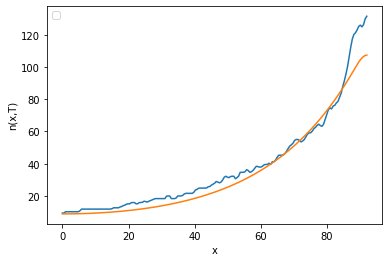

5
parameters [0.0045688674410533, 66.34244284695795, 24591.92293373773, 1.6195039589911917, 38.89883354944432]
parameters [0.006007864601589085, 136.15156951734843, 23286.15714841299, 2.3093231047002267, 22.93209700047468]
parameters [0.009150744128202503, 148.8433436092253, 27786.830966277375, 3.330386902070352, 42.375136835720646]
parameters [0.006199048141180635, 115.8227062537687, 23322.8964519126, 3.0028163392872087, 30.29580754351109]
parameters [0.007928688816199597, 119.45808137401085, 25938.937664520032, 2.692695184098399, 39.882064651563425]
SMC step with target distance: 130.0
[[0.0045688674410533, 66.34244284695795, 24591.92293373773, 1.6195039589911917, 38.89883354944432], [0.006007864601589085, 136.15156951734843, 23286.15714841299, 2.3093231047002267, 22.93209700047468], [0.009150744128202503, 148.8433436092253, 27786.830966277375, 3.330386902070352, 42.375136835720646], [0.006199048141180635, 115.8227062537687, 23322.8964519126, 3.0028163392872087, 30.29580754351109], [

oxigeno [5.18879479e-31 5.33403211e-31 5.77787462e-31 6.54520515e-31
 7.67910690e-31 9.24332464e-31 1.13259163e-30 1.40443116e-30
 1.75520773e-30 2.20477949e-30 2.77865812e-30 3.50949467e-30
 4.43898924e-30 5.62034070e-30 7.12138661e-30 9.02862677e-30
 1.14523799e-29 1.45333956e-29 1.84513356e-29 2.34356634e-29
 2.97796320e-29 3.78582704e-29 4.81515280e-29 6.12740836e-29
 7.80137744e-29 9.93811806e-29 1.26673669e-28 1.61558193e-28
 2.06178443e-28 2.63293660e-28 3.36458662e-28 4.30257536e-28
 5.50607378e-28 7.05153464e-28 9.03783987e-28 1.15930130e-27
 1.48829829e-27 1.91230388e-27 2.45928225e-27 3.16559726e-27
 4.07858979e-27 5.25996349e-27 6.79023825e-27 8.77461593e-27
 1.13507163e-26 1.46987936e-26 1.90552478e-26 2.47305171e-26
 3.21328082e-26 4.17996112e-26 5.44396174e-26 7.09885528e-26
 9.26836626e-26 1.21163225e-25 1.58599710e-25 2.07878244e-25
 2.72836156e-25 3.58585053e-25 4.71944538e-25 6.22027240e-25
 8.21029270e-25 1.08530001e-24 1.43679247e-24 1.90503290e-24
 2.52980039e-24 

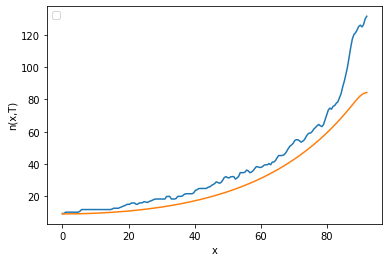

[[0.0045688674410533, 66.34244284695795, 24591.92293373773, 1.6195039589911917, 38.89883354944432], [0.006007864601589085, 136.15156951734843, 23286.15714841299, 2.3093231047002267, 22.93209700047468], [0.009150744128202503, 148.8433436092253, 27786.830966277375, 3.330386902070352, 42.375136835720646], [0.006199048141180635, 115.8227062537687, 23322.8964519126, 3.0028163392872087, 30.29580754351109], [0.007928688816199597, 119.45808137401085, 25938.937664520032, 2.692695184098399, 39.882064651563425]]
[[ 6.38115894e-06  8.81187025e-02  5.44235091e+00  1.99803229e-03
   1.32585719e-02]
 [ 8.81187025e-02  1.97693688e+03  4.04487795e+04  3.35644239e+01
  -8.80187734e+01]
 [ 5.44235091e+00  4.04487795e+04  7.28170902e+06  1.17228214e+03
   2.60545354e+04]
 [ 1.99803229e-03  3.35644239e+01  1.17228214e+03  8.74887007e-01
   1.81190650e+00]
 [ 1.32585719e-02 -8.80187734e+01  2.60545354e+04  1.81190650e+00
   1.30557953e+02]]
after perturb [0.007118811363539423, 120.57120429272551, 24734.1778

oxigeno [2.81785040e-30 2.87756701e-30 3.05924787e-30 3.37061162e-30
 3.82491712e-30 4.44154424e-30 5.24684606e-30 6.27531208e-30
 7.57109657e-30 9.18998369e-30 1.12018819e-29 1.36939658e-29
 1.67746154e-29 2.05783424e-29 2.52719408e-29 3.10621633e-29
 3.82052998e-29 4.70191331e-29 5.78978698e-29 7.13307978e-29
 8.79256210e-29 1.08437667e-28 1.33806483e-28 1.65201726e-28
 2.04080780e-28 2.52261157e-28 3.12011584e-28 3.86166720e-28
 4.78271805e-28 5.92765241e-28 7.35209345e-28 9.12582328e-28
 1.13364818e-27 1.40942584e-27 1.75378508e-27 2.18420424e-27
 2.72273510e-27 3.39723304e-27 4.24292775e-27 5.30443127e-27
 6.63830882e-27 8.31637489e-27 1.04299251e-26 1.30951775e-26
 1.64602795e-26 2.07143439e-26 2.60991202e-26 3.29240923e-26
 4.15860395e-26 5.25944209e-26 6.66043685e-26 8.44596416e-26
 1.07248643e-25 1.36377585e-25 1.73666235e-25 2.21473399e-25
 2.82861692e-25 3.61814266e-25 4.63520387e-25 5.94752425e-25
 7.64364430e-25 9.83952728e-25 1.26873284e-24 1.63870583e-24
 2.12021244e-24 

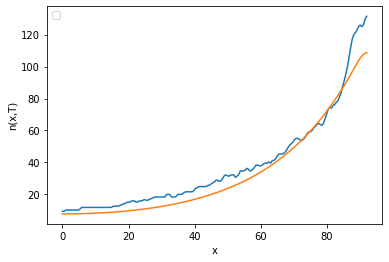

1
[[0.0045688674410533, 66.34244284695795, 24591.92293373773, 1.6195039589911917, 38.89883354944432], [0.006007864601589085, 136.15156951734843, 23286.15714841299, 2.3093231047002267, 22.93209700047468], [0.009150744128202503, 148.8433436092253, 27786.830966277375, 3.330386902070352, 42.375136835720646], [0.006199048141180635, 115.8227062537687, 23322.8964519126, 3.0028163392872087, 30.29580754351109], [0.007928688816199597, 119.45808137401085, 25938.937664520032, 2.692695184098399, 39.882064651563425]]
[[ 6.38115894e-06  8.81187025e-02  5.44235091e+00  1.99803229e-03
   1.32585719e-02]
 [ 8.81187025e-02  1.97693688e+03  4.04487795e+04  3.35644239e+01
  -8.80187734e+01]
 [ 5.44235091e+00  4.04487795e+04  7.28170902e+06  1.17228214e+03
   2.60545354e+04]
 [ 1.99803229e-03  3.35644239e+01  1.17228214e+03  8.74887007e-01
   1.81190650e+00]
 [ 1.32585719e-02 -8.80187734e+01  2.60545354e+04  1.81190650e+00
   1.30557953e+02]]
after perturb [0.007889596963161803, 150.06739082614956, 24215.64

oxigeno [3.53173963e-31 3.62124060e-31 3.89427974e-31 4.36472050e-31
 5.05649292e-31 6.00483718e-31 7.25814093e-31 8.88047011e-31
 1.09549314e-30 1.35880502e-30 1.69154061e-30 2.11088363e-30
 2.63856105e-30 3.30200893e-30 4.13585252e-30 5.18378474e-30
 6.50095024e-30 8.15697277e-30 1.02398013e-29 1.28605999e-29
 1.61599697e-29 2.03158730e-29 2.55537328e-29 3.21593196e-29
 4.04952092e-29 5.10218220e-29 6.43243495e-29 8.11472481e-29
 1.02438479e-28 1.29406307e-28 1.63592312e-28 2.06965334e-28
 2.62042527e-28 3.32045486e-28 4.21101900e-28 5.34506297e-28
 6.79057640e-28 8.63496981e-28 1.09907556e-27 1.40029325e-27
 1.78585962e-27 2.27994662e-27 2.91382343e-27 3.72799329e-27
 4.77499032e-27 6.12304552e-27 7.86089928e-27 1.01041283e-26
 1.30034766e-26 1.67558409e-26 2.16187818e-26 2.79297187e-26
 3.61313653e-26 4.68054864e-26 6.07177740e-26 7.88776056e-26
 1.02617754e-25 1.33700895e-25 1.74462167e-25 2.28000323e-25
 2.98434507e-25 3.91249788e-25 5.13763003e-25 6.75751954e-25
 8.90306843e-25 

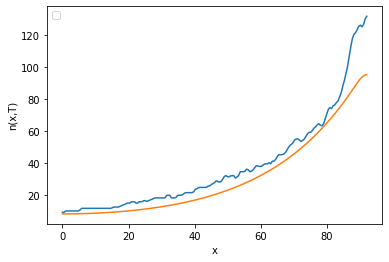

[[0.0045688674410533, 66.34244284695795, 24591.92293373773, 1.6195039589911917, 38.89883354944432], [0.006007864601589085, 136.15156951734843, 23286.15714841299, 2.3093231047002267, 22.93209700047468], [0.009150744128202503, 148.8433436092253, 27786.830966277375, 3.330386902070352, 42.375136835720646], [0.006199048141180635, 115.8227062537687, 23322.8964519126, 3.0028163392872087, 30.29580754351109], [0.007928688816199597, 119.45808137401085, 25938.937664520032, 2.692695184098399, 39.882064651563425]]
[[ 6.38115894e-06  8.81187025e-02  5.44235091e+00  1.99803229e-03
   1.32585719e-02]
 [ 8.81187025e-02  1.97693688e+03  4.04487795e+04  3.35644239e+01
  -8.80187734e+01]
 [ 5.44235091e+00  4.04487795e+04  7.28170902e+06  1.17228214e+03
   2.60545354e+04]
 [ 1.99803229e-03  3.35644239e+01  1.17228214e+03  8.74887007e-01
   1.81190650e+00]
 [ 1.32585719e-02 -8.80187734e+01  2.60545354e+04  1.81190650e+00
   1.30557953e+02]]
after perturb [0.005858461325487287, 101.38157517715261, 22361.2698

oxigeno [1.47684908e-30 1.50519556e-30 1.59132317e-30 1.73854706e-30
 1.95254885e-30 2.24160304e-30 2.61690827e-30 3.09303731e-30
 3.68852525e-30 4.42662095e-30 5.33623431e-30 6.45312057e-30
 7.82135346e-30 9.49515229e-30 1.15411442e-29 1.40411628e-29
 1.70957105e-29 2.08282411e-29 2.53904610e-29 3.09688946e-29
 3.77930216e-29 4.61453716e-29 5.63740579e-29 6.89083551e-29
 8.42780812e-29 1.03137736e-28 1.26296600e-28 1.54756300e-28
 1.89757763e-28 2.32839951e-28 2.85913444e-28 3.51352720e-28
 4.32112040e-28 5.31871145e-28 6.55218688e-28 8.07883472e-28
 9.97026331e-28 1.23160908e-27 1.52286149e-27 1.88487324e-27
 2.33534528e-27 2.89654491e-27 3.59652172e-27 4.47065784e-27
 5.56364741e-27 6.93202812e-27 8.64742373e-27 1.08007040e-26
 1.35073300e-26 1.69142339e-26 2.12086890e-26 2.66297634e-26
 3.34831374e-26 4.21603041e-26 5.31634938e-26 6.71380861e-26
 8.49148367e-26 1.07564989e-25 1.36472338e-25 1.73427637e-25
 2.20752508e-25 2.81462402e-25 3.59481310e-25 4.59925252e-25
 5.89477303e-25 

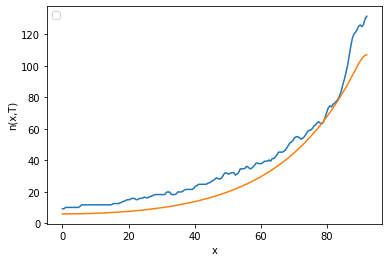

2
[[0.0045688674410533, 66.34244284695795, 24591.92293373773, 1.6195039589911917, 38.89883354944432], [0.006007864601589085, 136.15156951734843, 23286.15714841299, 2.3093231047002267, 22.93209700047468], [0.009150744128202503, 148.8433436092253, 27786.830966277375, 3.330386902070352, 42.375136835720646], [0.006199048141180635, 115.8227062537687, 23322.8964519126, 3.0028163392872087, 30.29580754351109], [0.007928688816199597, 119.45808137401085, 25938.937664520032, 2.692695184098399, 39.882064651563425]]
[[ 6.38115894e-06  8.81187025e-02  5.44235091e+00  1.99803229e-03
   1.32585719e-02]
 [ 8.81187025e-02  1.97693688e+03  4.04487795e+04  3.35644239e+01
  -8.80187734e+01]
 [ 5.44235091e+00  4.04487795e+04  7.28170902e+06  1.17228214e+03
   2.60545354e+04]
 [ 1.99803229e-03  3.35644239e+01  1.17228214e+03  8.74887007e-01
   1.81190650e+00]
 [ 1.32585719e-02 -8.80187734e+01  2.60545354e+04  1.81190650e+00
   1.30557953e+02]]
after perturb [0.010615050348830818, 182.99822862860964, 26149.41

oxigeno [1.10641286e-29 1.12898837e-29 1.19763615e-29 1.31516490e-29
 1.48639553e-29 1.71836512e-29 2.02062595e-29 2.40565308e-29
 2.88937883e-29 3.49187857e-29 4.23823911e-29 5.15964984e-29
 6.29476710e-29 7.69141568e-29 9.40870744e-29 1.15196779e-28
 1.41145668e-28 1.73049011e-28 2.12285796e-28 2.60562088e-28
 3.19990048e-28 3.93186564e-28 4.83396486e-28 5.94646755e-28
 7.31939377e-28 9.01493276e-28 1.11104777e-27 1.37024380e-27
 1.69110330e-27 2.08863293e-27 2.58158500e-27 3.19341797e-27
 3.95351034e-27 4.89869661e-27 6.07521334e-27 7.54116814e-27
 9.36967612e-27 1.16528498e-26 1.45068817e-26 1.80785275e-26
 2.25533883e-26 2.81665058e-26 3.52159362e-26 4.40801661e-26
 5.52404917e-26 6.93098197e-26 8.70697885e-26 1.09518691e-25
 1.37933439e-25 1.73949809e-25 2.19666538e-25 2.77780583e-25
 3.51763155e-25 4.46089221e-25 5.66537222e-25 7.20581174e-25
 9.17904519e-25 1.17107475e-24 1.49643066e-24 1.91525151e-24
 2.45530022e-24 3.15286448e-24 4.05546113e-24 5.22542653e-24
 6.74469210e-24 

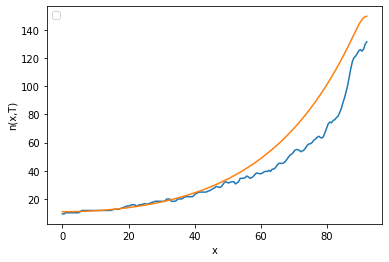

[[0.0045688674410533, 66.34244284695795, 24591.92293373773, 1.6195039589911917, 38.89883354944432], [0.006007864601589085, 136.15156951734843, 23286.15714841299, 2.3093231047002267, 22.93209700047468], [0.009150744128202503, 148.8433436092253, 27786.830966277375, 3.330386902070352, 42.375136835720646], [0.006199048141180635, 115.8227062537687, 23322.8964519126, 3.0028163392872087, 30.29580754351109], [0.007928688816199597, 119.45808137401085, 25938.937664520032, 2.692695184098399, 39.882064651563425]]
[[ 6.38115894e-06  8.81187025e-02  5.44235091e+00  1.99803229e-03
   1.32585719e-02]
 [ 8.81187025e-02  1.97693688e+03  4.04487795e+04  3.35644239e+01
  -8.80187734e+01]
 [ 5.44235091e+00  4.04487795e+04  7.28170902e+06  1.17228214e+03
   2.60545354e+04]
 [ 1.99803229e-03  3.35644239e+01  1.17228214e+03  8.74887007e-01
   1.81190650e+00]
 [ 1.32585719e-02 -8.80187734e+01  2.60545354e+04  1.81190650e+00
   1.30557953e+02]]
after perturb [0.008194681347801996, 136.4838231087201, 26213.07397

oxigeno [2.22626878e-29 2.27348549e-29 2.41713846e-29 2.66333530e-29
 3.02256741e-29 3.51016966e-29 4.14699489e-29 4.96033457e-29
 5.98512835e-29 7.26551923e-29 8.85682747e-29 1.08280367e-28
 1.32649108e-28 1.62738910e-28 1.99869620e-28 2.45677232e-28
 3.02189645e-28 3.71921197e-28 4.57990714e-28 5.64268991e-28
 6.95563205e-28 8.57847699e-28 1.05855306e-27 1.30692853e-27
 1.61449690e-27 1.99562594e-27 2.46824709e-27 3.05476022e-27
 3.78317410e-27 4.68854529e-27 5.81479595e-27 7.21701277e-27
 8.96435798e-27 1.11437598e-26 1.38645970e-26 1.72646522e-26
 2.15176876e-26 2.68430987e-26 3.35182297e-26 4.18941076e-26
 5.24155709e-26 6.56470546e-26 8.23056680e-26 1.03303688e-25
 1.29803225e-25 1.63286654e-25 2.05647488e-25 2.59307801e-25
 3.27370196e-25 4.13814772e-25 5.23754820e-25 6.63769285e-25
 8.42335720e-25 1.07039503e-24 1.36208936e-24 1.73572770e-24
 2.21505182e-24 2.83089851e-24 3.62338621e-24 4.64479623e-24
 5.96337614e-24 7.66836935e-24 9.87667810e-24 1.27417068e-23
 1.64651205e-23 

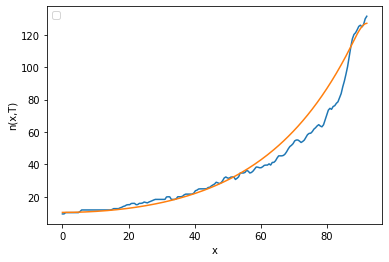

3
[[0.0045688674410533, 66.34244284695795, 24591.92293373773, 1.6195039589911917, 38.89883354944432], [0.006007864601589085, 136.15156951734843, 23286.15714841299, 2.3093231047002267, 22.93209700047468], [0.009150744128202503, 148.8433436092253, 27786.830966277375, 3.330386902070352, 42.375136835720646], [0.006199048141180635, 115.8227062537687, 23322.8964519126, 3.0028163392872087, 30.29580754351109], [0.007928688816199597, 119.45808137401085, 25938.937664520032, 2.692695184098399, 39.882064651563425]]
[[ 6.38115894e-06  8.81187025e-02  5.44235091e+00  1.99803229e-03
   1.32585719e-02]
 [ 8.81187025e-02  1.97693688e+03  4.04487795e+04  3.35644239e+01
  -8.80187734e+01]
 [ 5.44235091e+00  4.04487795e+04  7.28170902e+06  1.17228214e+03
   2.60545354e+04]
 [ 1.99803229e-03  3.35644239e+01  1.17228214e+03  8.74887007e-01
   1.81190650e+00]
 [ 1.32585719e-02 -8.80187734e+01  2.60545354e+04  1.81190650e+00
   1.30557953e+02]]
after perturb [0.012306993457881566, 203.51127825920975, 30702.71

oxigeno [6.67622022e-32 6.81829269e-32 7.25055680e-32 7.99145481e-32
 9.07267259e-32 1.05405346e-31 1.24580519e-31 1.49077187e-31
 1.79951885e-31 2.18540034e-31 2.66516010e-31 3.25968857e-31
 3.99497289e-31 4.90328577e-31 6.02467133e-31 7.40880094e-31
 9.11729124e-31 1.12266003e-30 1.38316478e-30 1.70503447e-30
 2.10292634e-30 2.59507443e-30 3.20418101e-30 3.95853593e-30
 4.89342373e-30 6.05289428e-30 7.49199359e-30 9.27957755e-30
 1.15018650e-29 1.42669301e-29 1.77103893e-29 2.20026091e-29
 2.73578539e-29 3.40459112e-29 4.24068837e-29 5.28700377e-29
 6.59778535e-29 8.24167548e-29 1.03056431e-28 1.29000224e-28
 1.61649795e-28 2.02788233e-28 2.54687040e-28 3.20244051e-28
 4.03161527e-28 5.08176482e-28 6.41359056e-28 8.10499651e-28
 1.02561212e-27 1.29958884e-27 1.64905508e-27 2.09548517e-27
 2.66666321e-27 3.39859838e-27 4.33804054e-27 5.54579070e-27
 7.10106544e-27 9.10726200e-27 1.16995880e-26 1.50551788e-26
 1.94065401e-26 2.50594442e-26 3.24168048e-26 4.20105924e-26
 5.45445868e-26 

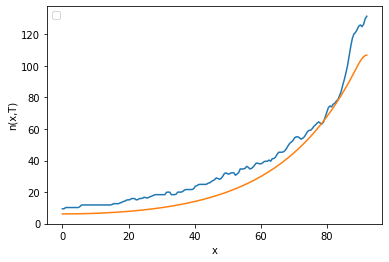

4
[[0.0045688674410533, 66.34244284695795, 24591.92293373773, 1.6195039589911917, 38.89883354944432], [0.006007864601589085, 136.15156951734843, 23286.15714841299, 2.3093231047002267, 22.93209700047468], [0.009150744128202503, 148.8433436092253, 27786.830966277375, 3.330386902070352, 42.375136835720646], [0.006199048141180635, 115.8227062537687, 23322.8964519126, 3.0028163392872087, 30.29580754351109], [0.007928688816199597, 119.45808137401085, 25938.937664520032, 2.692695184098399, 39.882064651563425]]
[[ 6.38115894e-06  8.81187025e-02  5.44235091e+00  1.99803229e-03
   1.32585719e-02]
 [ 8.81187025e-02  1.97693688e+03  4.04487795e+04  3.35644239e+01
  -8.80187734e+01]
 [ 5.44235091e+00  4.04487795e+04  7.28170902e+06  1.17228214e+03
   2.60545354e+04]
 [ 1.99803229e-03  3.35644239e+01  1.17228214e+03  8.74887007e-01
   1.81190650e+00]
 [ 1.32585719e-02 -8.80187734e+01  2.60545354e+04  1.81190650e+00
   1.30557953e+02]]
after perturb [0.006907976349089914, 72.50481322524588, 27330.137

oxigeno [3.94376929e-29 4.00922353e-29 4.20775893e-29 4.54598826e-29
 5.03521384e-29 5.69182099e-29 6.53785137e-29 7.60177793e-29
 8.91951066e-29 1.05356716e-28 1.25051883e-28 1.48952664e-28
 1.77878200e-28 2.12824528e-28 2.55001111e-28 3.05875513e-28
 3.67228058e-28 4.41218666e-28 5.30468638e-28 6.38160775e-28
 7.68162039e-28 9.25173958e-28 1.11491722e-27 1.34435843e-27
 1.62198903e-27 1.95816863e-27 2.36554821e-27 2.85959230e-27
 3.45922414e-27 4.18762356e-27 5.07321517e-27 6.15089363e-27
 7.46354486e-27 9.06393703e-27 1.10170746e-26 1.34031322e-26
 1.63211167e-26 1.98934444e-26 2.42716693e-26 2.96436633e-26
 3.62426291e-26 4.43584289e-26 5.43518468e-26 6.66725715e-26
 8.18819026e-26 1.00681469e-25 1.23949605e-25 1.52787505e-25
 1.88577871e-25 2.33059565e-25 2.88422799e-25 3.57430691e-25
 4.43574787e-25 5.51274370e-25 6.86132323e-25 8.55264205e-25
 1.06772222e-24 1.33504249e-24 1.67195268e-24 2.09728889e-24
 2.63518574e-24 3.31662407e-24 4.18144777e-24 5.28099688e-24
 6.68155244e-24 

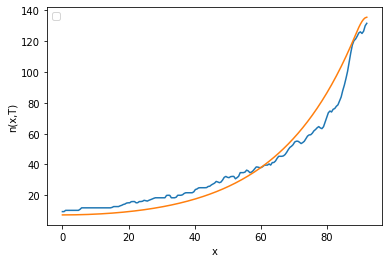

5
parameters [0.007118811363539423, 120.57120429272551, 24734.177815104038, 2.8303614520436686, 34.74121139000783]
parameters [0.005858461325487287, 101.38157517715261, 22361.269807567034, 2.7576110565760525, 29.657085934099435]
parameters [0.008194681347801996, 136.4838231087201, 26213.073971323054, 2.4122419070642787, 36.3212762997626]
parameters [0.005929856486794324, 62.99020185358995, 24696.17186751144, 1.8694284075078396, 43.61947538102198]
parameters [0.0061168085209431546, 117.48801757080317, 24585.17292902007, 2.3144404135897827, 31.527252142822363]
SMC step with target distance: 110.0
[[0.007118811363539423, 120.57120429272551, 24734.177815104038, 2.8303614520436686, 34.74121139000783], [0.005858461325487287, 101.38157517715261, 22361.269807567034, 2.7576110565760525, 29.657085934099435], [0.008194681347801996, 136.4838231087201, 26213.073971323054, 2.4122419070642787, 36.3212762997626], [0.005929856486794324, 62.99020185358995, 24696.17186751144, 1.8694284075078396, 43.61947

oxigeno [1.39620563e-29 1.42201518e-29 1.50039805e-29 1.63426069e-29
 1.82858087e-29 2.09059941e-29 2.43010041e-29 2.85979148e-29
 3.39579989e-29 4.05830514e-29 4.87233479e-29 5.86875696e-29
 7.08551197e-29 8.56913602e-29 1.03766427e-28 1.25778448e-28
 1.52582180e-28 1.85224352e-28 2.24987276e-28 2.73442727e-28
 3.32518538e-28 4.04580986e-28 4.92536822e-28 5.99959739e-28
 7.31247306e-28 8.91815914e-28 1.08834321e-27 1.32906993e-27
 1.62417614e-27 1.98625075e-27 2.43087815e-27 2.97737218e-27
 3.64969538e-27 4.47761203e-27 5.49813611e-27 6.75735220e-27
 8.31270824e-27 1.02359066e-26 1.26165546e-26 1.55667804e-26
 1.92270777e-26 2.37737182e-26 2.94281643e-26 3.64690417e-26
 4.52473900e-26 5.62061191e-26 6.99048704e-26 8.70518332e-26
 1.08544530e-25 1.35522181e-25 1.69433050e-25 2.12121198e-25
 2.65938430e-25 3.33889002e-25 4.19816996e-25 5.28649366e-25
 6.66711782e-25 8.42139783e-25 1.06541502e-24 1.35006590e-24
 1.71358481e-24 2.17863108e-24 2.77461181e-24 3.53976323e-24
 4.52389656e-24 

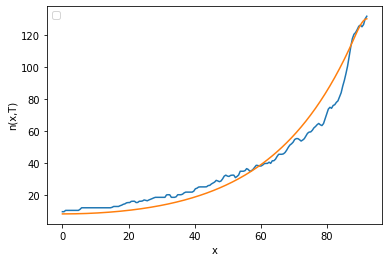

1
[[0.007118811363539423, 120.57120429272551, 24734.177815104038, 2.8303614520436686, 34.74121139000783], [0.005858461325487287, 101.38157517715261, 22361.269807567034, 2.7576110565760525, 29.657085934099435], [0.008194681347801996, 136.4838231087201, 26213.073971323054, 2.4122419070642787, 36.3212762997626], [0.005929856486794324, 62.99020185358995, 24696.17186751144, 1.8694284075078396, 43.61947538102198], [0.0061168085209431546, 117.48801757080317, 24585.17292902007, 2.3144404135897827, 31.527252142822363]]
[[ 2.01753046e-06  4.12392331e-02  2.13135247e+00  1.83233939e-04
   8.99284144e-04]
 [ 4.12392331e-02  1.56441789e+03  2.89458942e+04  1.32505591e+01
  -1.75489465e+02]
 [ 2.13135247e+00  2.89458942e+04  3.80387558e+06 -3.78880163e+02
   7.50471866e+03]
 [ 1.83233939e-04  1.32505591e+01 -3.78880163e+02  2.97647921e-01
  -3.15694953e+00]
 [ 8.99284144e-04 -1.75489465e+02  7.50471866e+03 -3.15694953e+00
   5.82823557e+01]]
after perturb [0.0070671899761962425, 168.19570982379332, 

oxigeno [5.55654504e-31 5.68257315e-31 6.06637437e-31 6.72539622e-31
 7.68966212e-31 9.00317483e-31 1.07259811e-30 1.29369990e-30
 1.57377487e-30 1.92571702e-30 2.36577721e-30 2.91434175e-30
 3.59691440e-30 4.44535165e-30 5.49941493e-30 6.80871976e-30
 8.43518382e-30 1.04561023e-29 1.29680135e-29 1.60915614e-29
 1.99776169e-29 2.48149909e-29 3.08401606e-29 3.83495503e-29
 4.77150481e-29 5.94036370e-29 7.40022545e-29 9.22493093e-29
 1.15074684e-28 1.43650565e-28 1.79456108e-28 2.24359803e-28
 2.80724511e-28 3.51541582e-28 4.40602319e-28 5.52717471e-28
 6.93998585e-28 8.72219113e-28 1.09727853e-27 1.38179967e-27
 1.74189853e-27 2.19817793e-27 2.77701168e-27 3.51220695e-27
 4.44715920e-27 5.63764988e-27 7.15548430e-27 9.09322923e-27
 1.15703924e-26 1.47414959e-26 1.88066404e-26 2.40253524e-26
 3.07347643e-26 3.93735232e-26 5.05132891e-26 6.49003013e-26
 8.35103298e-26 1.07621451e-25 1.38910602e-25 1.79581920e-25
 2.32537646e-25 3.01606130e-25 3.91846613e-25 5.09957393e-25
 6.64823544e-25 

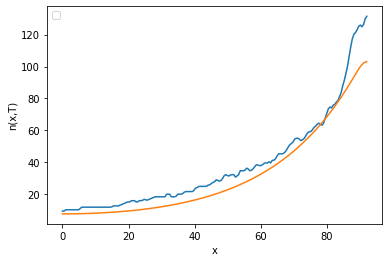

[[0.007118811363539423, 120.57120429272551, 24734.177815104038, 2.8303614520436686, 34.74121139000783], [0.005858461325487287, 101.38157517715261, 22361.269807567034, 2.7576110565760525, 29.657085934099435], [0.008194681347801996, 136.4838231087201, 26213.073971323054, 2.4122419070642787, 36.3212762997626], [0.005929856486794324, 62.99020185358995, 24696.17186751144, 1.8694284075078396, 43.61947538102198], [0.0061168085209431546, 117.48801757080317, 24585.17292902007, 2.3144404135897827, 31.527252142822363]]
[[ 2.01753046e-06  4.12392331e-02  2.13135247e+00  1.83233939e-04
   8.99284144e-04]
 [ 4.12392331e-02  1.56441789e+03  2.89458942e+04  1.32505591e+01
  -1.75489465e+02]
 [ 2.13135247e+00  2.89458942e+04  3.80387558e+06 -3.78880163e+02
   7.50471866e+03]
 [ 1.83233939e-04  1.32505591e+01 -3.78880163e+02  2.97647921e-01
  -3.15694953e+00]
 [ 8.99284144e-04 -1.75489465e+02  7.50471866e+03 -3.15694953e+00
   5.82823557e+01]]
after perturb [0.007487353847020377, 186.7773678154282, 2389

oxigeno [2.43081036e-29 2.46217198e-29 2.55706608e-29 2.71795360e-29
 2.94902623e-29 3.25632226e-29 3.64789475e-29 4.13403703e-29
 4.72757274e-29 5.44421918e-29 6.30303584e-29 7.32697194e-29
 8.54353096e-29 9.98557341e-29 1.16922842e-28 1.37103366e-28
 1.60952915e-28 1.89132799e-28 2.22430248e-28 2.61782738e-28
 3.08307264e-28 3.63335605e-28 4.28456833e-28 5.05568625e-28
 5.96939241e-28 7.05282496e-28 8.33848541e-28 9.86533917e-28
 1.16801515e-27 1.38391114e-27 1.64098071e-27 1.94736348e-27
 2.31287365e-27 2.74935904e-27 3.27114042e-27 3.89554986e-27
 4.64359131e-27 5.54075245e-27 6.61800390e-27 7.91303079e-27
 9.47175330e-27 1.13502066e-26 1.36168691e-26 1.63555502e-26
 1.96689788e-26 2.36832678e-26 2.85534812e-26 3.44705843e-26
 4.16701383e-26 5.04431949e-26 6.11499723e-26 7.42370538e-26
 9.02590553e-26 1.09905975e-25 1.34037777e-25 1.63728213e-25
 2.00320450e-25 2.45497820e-25 3.01373999e-25 3.70608163e-25
 4.56552349e-25 5.63440424e-25 6.96630900e-25 8.62919628e-25
 1.07094333e-24 

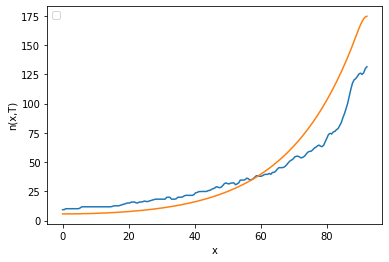

[[0.007118811363539423, 120.57120429272551, 24734.177815104038, 2.8303614520436686, 34.74121139000783], [0.005858461325487287, 101.38157517715261, 22361.269807567034, 2.7576110565760525, 29.657085934099435], [0.008194681347801996, 136.4838231087201, 26213.073971323054, 2.4122419070642787, 36.3212762997626], [0.005929856486794324, 62.99020185358995, 24696.17186751144, 1.8694284075078396, 43.61947538102198], [0.0061168085209431546, 117.48801757080317, 24585.17292902007, 2.3144404135897827, 31.527252142822363]]
[[ 2.01753046e-06  4.12392331e-02  2.13135247e+00  1.83233939e-04
   8.99284144e-04]
 [ 4.12392331e-02  1.56441789e+03  2.89458942e+04  1.32505591e+01
  -1.75489465e+02]
 [ 2.13135247e+00  2.89458942e+04  3.80387558e+06 -3.78880163e+02
   7.50471866e+03]
 [ 1.83233939e-04  1.32505591e+01 -3.78880163e+02  2.97647921e-01
  -3.15694953e+00]
 [ 8.99284144e-04 -1.75489465e+02  7.50471866e+03 -3.15694953e+00
   5.82823557e+01]]
after perturb [0.005089168130831244, 77.29174241058635, 2393

oxigeno [1.22368642e-30 1.24424848e-30 1.30662570e-30 1.41292136e-30
 1.56673100e-30 1.77326895e-30 2.03955282e-30 2.37465292e-30
 2.79001614e-30 3.29987681e-30 3.92177042e-30 4.67717023e-30
 5.59227193e-30 6.69895725e-30 8.03597535e-30 9.65038938e-30
 1.15993473e-29 1.39522499e-29 1.67934055e-29 2.02252835e-29
 2.43725038e-29 2.93867337e-29 3.54527041e-29 4.27956068e-29
 5.16902029e-29 6.24720472e-29 7.55513375e-29 9.14300223e-29
 1.10722959e-28 1.34184116e-28 1.62739052e-28 1.97525246e-28
 2.39942221e-28 2.91713934e-28 3.54966538e-28 4.32325435e-28
 5.27036565e-28 6.43118223e-28 7.85551334e-28 9.60518300e-28
 1.17570325e-27 1.44067004e-27 1.76733897e-27 2.17058869e-27
 2.66901774e-27 3.28590923e-27 4.05045521e-27 4.99931288e-27
 6.17858622e-27 7.64635344e-27 9.47589631e-27 1.17598335e-26
 1.46154203e-26 1.81913572e-26 2.26765507e-26 2.83114100e-26
 3.54024394e-26 4.43411242e-26 5.56284222e-26 6.99065850e-26
 8.80005888e-26 1.10972183e-25 1.40190544e-25 1.77424840e-25
 2.24965726e-25 

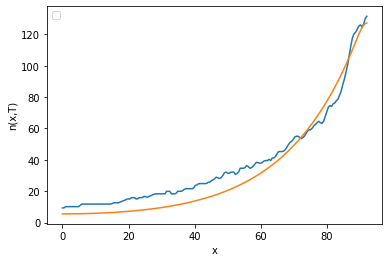

2
[[0.007118811363539423, 120.57120429272551, 24734.177815104038, 2.8303614520436686, 34.74121139000783], [0.005858461325487287, 101.38157517715261, 22361.269807567034, 2.7576110565760525, 29.657085934099435], [0.008194681347801996, 136.4838231087201, 26213.073971323054, 2.4122419070642787, 36.3212762997626], [0.005929856486794324, 62.99020185358995, 24696.17186751144, 1.8694284075078396, 43.61947538102198], [0.0061168085209431546, 117.48801757080317, 24585.17292902007, 2.3144404135897827, 31.527252142822363]]
[[ 2.01753046e-06  4.12392331e-02  2.13135247e+00  1.83233939e-04
   8.99284144e-04]
 [ 4.12392331e-02  1.56441789e+03  2.89458942e+04  1.32505591e+01
  -1.75489465e+02]
 [ 2.13135247e+00  2.89458942e+04  3.80387558e+06 -3.78880163e+02
   7.50471866e+03]
 [ 1.83233939e-04  1.32505591e+01 -3.78880163e+02  2.97647921e-01
  -3.15694953e+00]
 [ 8.99284144e-04 -1.75489465e+02  7.50471866e+03 -3.15694953e+00
   5.82823557e+01]]
after perturb [0.00622880687978545, 160.69163028710523, 25

oxigeno [9.33197923e-31 9.50192687e-31 1.00179598e-30 1.08989279e-30
 1.21771021e-30 1.38993978e-30 1.61291627e-30 1.89486010e-30
 2.24619322e-30 2.67994158e-30 3.21224072e-30 3.86296554e-30
 4.65651071e-30 5.62275462e-30 6.79824805e-30 8.22767843e-30
 9.96567338e-30 1.20790221e-29 1.46494130e-29 1.77768089e-29
 2.15836129e-29 2.62198122e-29 3.18693374e-29 3.87579326e-29
 4.71629023e-29 5.74251993e-29 6.99644307e-29 8.52975078e-29
 1.04061851e-28 1.27044301e-28 1.55217175e-28 1.89783298e-28
 2.32232312e-28 2.84411178e-28 3.48612557e-28 4.27685771e-28
 5.25176281e-28 6.45501265e-28 7.94170954e-28 9.78068041e-28
 1.20580092e-27 1.48815089e-27 1.83863931e-27 2.27424767e-27
 2.81633364e-27 3.49179792e-27 4.33457304e-27 5.38752617e-27
 6.70489486e-27 8.35541025e-27 1.04263087e-26 1.30284931e-26
 1.63031858e-26 2.04305177e-26 2.56406391e-26 3.22281172e-26
 4.05706274e-26 5.11532658e-26 6.46002303e-26 8.17161870e-26
 1.03540385e-25 1.31417594e-25 1.67091267e-25 2.12826167e-25
 2.71570079e-25 

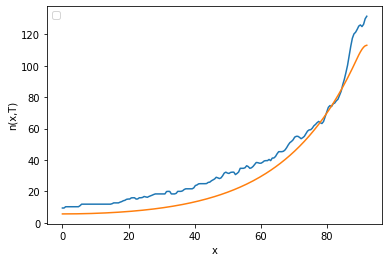

[[0.007118811363539423, 120.57120429272551, 24734.177815104038, 2.8303614520436686, 34.74121139000783], [0.005858461325487287, 101.38157517715261, 22361.269807567034, 2.7576110565760525, 29.657085934099435], [0.008194681347801996, 136.4838231087201, 26213.073971323054, 2.4122419070642787, 36.3212762997626], [0.005929856486794324, 62.99020185358995, 24696.17186751144, 1.8694284075078396, 43.61947538102198], [0.0061168085209431546, 117.48801757080317, 24585.17292902007, 2.3144404135897827, 31.527252142822363]]
[[ 2.01753046e-06  4.12392331e-02  2.13135247e+00  1.83233939e-04
   8.99284144e-04]
 [ 4.12392331e-02  1.56441789e+03  2.89458942e+04  1.32505591e+01
  -1.75489465e+02]
 [ 2.13135247e+00  2.89458942e+04  3.80387558e+06 -3.78880163e+02
   7.50471866e+03]
 [ 1.83233939e-04  1.32505591e+01 -3.78880163e+02  2.97647921e-01
  -3.15694953e+00]
 [ 8.99284144e-04 -1.75489465e+02  7.50471866e+03 -3.15694953e+00
   5.82823557e+01]]
after perturb [0.0034438439678962348, 12.931198354441804, 22

oxigeno [5.10295699e-38 5.29866357e-38 5.90079459e-38 6.95556305e-38
 8.54397594e-38 1.07881001e-37 1.38605171e-37 1.79977097e-37
 2.35184341e-37 3.08485277e-37 4.05541152e-37 5.33858474e-37
 7.03376922e-37 9.27249713e-37 1.22287890e-36 1.61328882e-36
 2.12894839e-36 2.81018982e-36 3.71042025e-36 4.90038827e-36
 6.47385490e-36 8.55513557e-36 1.13091362e-35 1.49547164e-35
 1.97824949e-35 2.61785879e-35 3.46562811e-35 4.58983150e-35
 6.08133823e-35 8.06116704e-35 1.06905947e-34 1.41846935e-34
 1.88304753e-34 2.50112310e-34 3.32392082e-34 4.41995233e-34
 5.88092250e-34 7.82968104e-34 1.04309382e-33 1.39057193e-33
 1.85508834e-33 2.47655061e-33 3.30865813e-33 4.42373835e-33
 5.91930575e-33 7.92696712e-33 1.06245271e-32 1.42524641e-32
 1.91363809e-32 2.57176385e-32 3.45952060e-32 4.65829135e-32
 6.27878794e-32 8.47180979e-32 1.14430233e-31 1.54732947e-31
 2.09467038e-31 2.83891998e-31 3.85220247e-31 5.23356622e-31
 7.11923658e-31 9.69685447e-31 1.32252840e-30 1.80622144e-30
 2.47026919e-30 

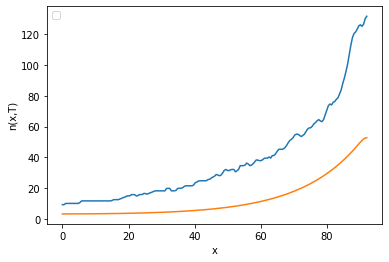

[[0.007118811363539423, 120.57120429272551, 24734.177815104038, 2.8303614520436686, 34.74121139000783], [0.005858461325487287, 101.38157517715261, 22361.269807567034, 2.7576110565760525, 29.657085934099435], [0.008194681347801996, 136.4838231087201, 26213.073971323054, 2.4122419070642787, 36.3212762997626], [0.005929856486794324, 62.99020185358995, 24696.17186751144, 1.8694284075078396, 43.61947538102198], [0.0061168085209431546, 117.48801757080317, 24585.17292902007, 2.3144404135897827, 31.527252142822363]]
[[ 2.01753046e-06  4.12392331e-02  2.13135247e+00  1.83233939e-04
   8.99284144e-04]
 [ 4.12392331e-02  1.56441789e+03  2.89458942e+04  1.32505591e+01
  -1.75489465e+02]
 [ 2.13135247e+00  2.89458942e+04  3.80387558e+06 -3.78880163e+02
   7.50471866e+03]
 [ 1.83233939e-04  1.32505591e+01 -3.78880163e+02  2.97647921e-01
  -3.15694953e+00]
 [ 8.99284144e-04 -1.75489465e+02  7.50471866e+03 -3.15694953e+00
   5.82823557e+01]]
after perturb [0.005994680896967491, 118.32569243249623, 232

oxigeno [2.11071979e-29 2.14739236e-29 2.25868443e-29 2.44847526e-29
 2.72339996e-29 3.09309016e-29 3.57052513e-29 4.17250701e-29
 4.92027877e-29 5.84030926e-29 6.96527661e-29 8.33528919e-29
 9.99939345e-29 1.20174296e-28 1.44623117e-28 1.74228248e-28
 2.10070581e-28 2.53466157e-28 3.06017849e-28 3.69678841e-28
 4.46830628e-28 5.40378963e-28 6.53871968e-28 7.91645690e-28
 9.59003646e-28 1.16243853e-27 1.40990629e-27 1.71116533e-27
 2.07819678e-27 2.52572580e-27 3.07186903e-27 3.73893973e-27
 4.55445004e-27 5.55236055e-27 6.77463987e-27 8.27321388e-27
 1.01124052e-26 1.23719901e-26 1.51510350e-26 1.85727174e-26
 2.27903921e-26 2.79952376e-26 3.44259048e-26 4.23807137e-26
 5.22330924e-26 6.44511503e-26 7.96225316e-26 9.84860227e-26
 1.21971814e-25 1.51252864e-25 1.87810548e-25 2.33518679e-25
 2.90751254e-25 3.62520835e-25 4.52656599e-25 5.66033825e-25
 7.08870204e-25 8.89109114e-25 1.11691631e-24 1.40532473e-24
 1.77107328e-24 2.23569978e-24 2.82696816e-24 3.58073541e-24
 4.54339895e-24 

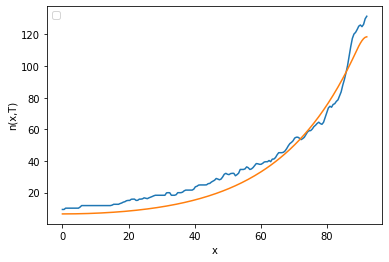

3
[[0.007118811363539423, 120.57120429272551, 24734.177815104038, 2.8303614520436686, 34.74121139000783], [0.005858461325487287, 101.38157517715261, 22361.269807567034, 2.7576110565760525, 29.657085934099435], [0.008194681347801996, 136.4838231087201, 26213.073971323054, 2.4122419070642787, 36.3212762997626], [0.005929856486794324, 62.99020185358995, 24696.17186751144, 1.8694284075078396, 43.61947538102198], [0.0061168085209431546, 117.48801757080317, 24585.17292902007, 2.3144404135897827, 31.527252142822363]]
[[ 2.01753046e-06  4.12392331e-02  2.13135247e+00  1.83233939e-04
   8.99284144e-04]
 [ 4.12392331e-02  1.56441789e+03  2.89458942e+04  1.32505591e+01
  -1.75489465e+02]
 [ 2.13135247e+00  2.89458942e+04  3.80387558e+06 -3.78880163e+02
   7.50471866e+03]
 [ 1.83233939e-04  1.32505591e+01 -3.78880163e+02  2.97647921e-01
  -3.15694953e+00]
 [ 8.99284144e-04 -1.75489465e+02  7.50471866e+03 -3.15694953e+00
   5.82823557e+01]]
after perturb [0.005257039205971734, 88.62926137452413, 26

oxigeno [2.83270069e-29 2.87236903e-29 2.99248505e-29 3.19642845e-29
 3.48996205e-29 3.88140378e-29 4.38187654e-29 5.00564421e-29
 5.77054487e-29 6.69853597e-29 7.81636963e-29 9.15642115e-29
 1.07576992e-28 1.26670726e-28 1.49407567e-28 1.76461118e-28
 2.08638179e-28 2.46905038e-28 2.92419276e-28 3.46568243e-28
 4.11015659e-28 4.87758084e-28 5.79193425e-28 6.88204128e-28
 8.18258309e-28 9.73532840e-28 1.15906332e-27 1.38092706e-27
 1.64646655e-27 1.96456282e-27 2.34597020e-27 2.80372681e-27
 3.35365860e-27 4.01499917e-27 4.81115297e-27 5.77063632e-27
 6.92823952e-27 8.32646395e-27 1.00173020e-26 1.20644447e-26
 1.45460245e-26 1.75580275e-26 2.12185463e-26 2.56730873e-26
 3.11012073e-26 3.77248231e-26 4.58186352e-26 5.57232253e-26
 6.78615408e-26 8.27596799e-26 1.01073144e-25 1.23620057e-25
 1.51423271e-25 1.85763847e-25 2.28249093e-25 2.80899295e-25
 3.46258495e-25 4.27536244e-25 5.28789353e-25 6.55155402e-25
 8.13153338e-25 1.01107123e-24 1.25946752e-24 1.57182027e-24
 1.96537001e-24 

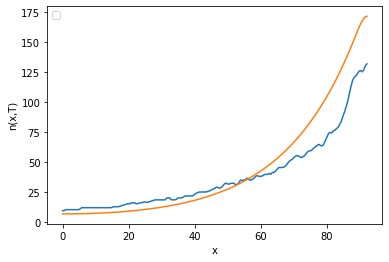

[[0.007118811363539423, 120.57120429272551, 24734.177815104038, 2.8303614520436686, 34.74121139000783], [0.005858461325487287, 101.38157517715261, 22361.269807567034, 2.7576110565760525, 29.657085934099435], [0.008194681347801996, 136.4838231087201, 26213.073971323054, 2.4122419070642787, 36.3212762997626], [0.005929856486794324, 62.99020185358995, 24696.17186751144, 1.8694284075078396, 43.61947538102198], [0.0061168085209431546, 117.48801757080317, 24585.17292902007, 2.3144404135897827, 31.527252142822363]]
[[ 2.01753046e-06  4.12392331e-02  2.13135247e+00  1.83233939e-04
   8.99284144e-04]
 [ 4.12392331e-02  1.56441789e+03  2.89458942e+04  1.32505591e+01
  -1.75489465e+02]
 [ 2.13135247e+00  2.89458942e+04  3.80387558e+06 -3.78880163e+02
   7.50471866e+03]
 [ 1.83233939e-04  1.32505591e+01 -3.78880163e+02  2.97647921e-01
  -3.15694953e+00]
 [ 8.99284144e-04 -1.75489465e+02  7.50471866e+03 -3.15694953e+00
   5.82823557e+01]]
after perturb [0.005030938545418969, 98.84522170297157, 2198

oxigeno [5.87065385e-30 5.96756585e-30 6.26150144e-30 6.76219633e-30
 7.48628490e-30 8.45787450e-30 9.70938173e-30 1.12826621e-29
 1.32304747e-29 1.56183384e-29 1.85268478e-29 2.20545393e-29
 2.63214166e-29 3.14732716e-29 3.76869711e-29 4.51769153e-29
 5.42029272e-29 6.50798871e-29 7.81895045e-29 9.39947066e-29
 1.13057239e-28 1.36059214e-28 1.63829509e-28 1.97376147e-28
 2.37926049e-28 2.86973884e-28 3.46342181e-28 4.18255347e-28
 5.05430959e-28 6.11192453e-28 7.39608409e-28 8.95664920e-28
 1.08547916e-27 1.31656436e-27 1.59815890e-27 1.94163575e-27
 2.36101235e-27 2.87358654e-27 3.50073082e-27 4.26888566e-27
 5.21080362e-27 6.36710982e-27 7.78826198e-27 9.53701633e-27
 1.16915343e-26 1.43493026e-26 1.76320884e-26 2.16922103e-26
 2.67204909e-26 3.29563557e-26 4.07006797e-26 5.03321576e-26
 6.23281991e-26 7.72916471e-26 9.59850008e-26 1.19374332e-25
 1.48685742e-25 1.85478070e-25 2.31736714e-25 2.89994919e-25
 3.63490874e-25 4.56371588e-25 5.73958003e-25 7.23090420e-25
 9.12579482e-25 

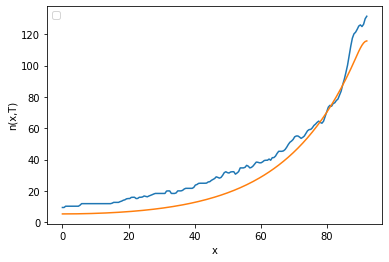

[[0.007118811363539423, 120.57120429272551, 24734.177815104038, 2.8303614520436686, 34.74121139000783], [0.005858461325487287, 101.38157517715261, 22361.269807567034, 2.7576110565760525, 29.657085934099435], [0.008194681347801996, 136.4838231087201, 26213.073971323054, 2.4122419070642787, 36.3212762997626], [0.005929856486794324, 62.99020185358995, 24696.17186751144, 1.8694284075078396, 43.61947538102198], [0.0061168085209431546, 117.48801757080317, 24585.17292902007, 2.3144404135897827, 31.527252142822363]]
[[ 2.01753046e-06  4.12392331e-02  2.13135247e+00  1.83233939e-04
   8.99284144e-04]
 [ 4.12392331e-02  1.56441789e+03  2.89458942e+04  1.32505591e+01
  -1.75489465e+02]
 [ 2.13135247e+00  2.89458942e+04  3.80387558e+06 -3.78880163e+02
   7.50471866e+03]
 [ 1.83233939e-04  1.32505591e+01 -3.78880163e+02  2.97647921e-01
  -3.15694953e+00]
 [ 8.99284144e-04 -1.75489465e+02  7.50471866e+03 -3.15694953e+00
   5.82823557e+01]]
after perturb [0.005873367857425793, 119.58936233292765, 226

oxigeno [8.34639504e-30 8.49895939e-30 8.96222991e-30 9.75319063e-30
 1.09009176e-29 1.24476845e-29 1.44505766e-29 1.69836804e-29
 2.01409359e-29 2.40397713e-29 2.88256682e-29 3.46778489e-29
 4.18163230e-29 5.05105909e-29 6.10903759e-29 7.39588431e-29
 8.96088780e-29 1.08643136e-28 1.31798746e-28 1.59977757e-28
 1.94284716e-28 2.36073047e-28 2.87002380e-28 3.49109467e-28
 4.24895980e-28 5.17437361e-28 6.30517872e-28 7.68798367e-28
 9.38024939e-28 1.14528870e-27 1.39934958e-27 1.71104053e-27
 2.09377243e-27 2.56416597e-27 3.14284304e-27 3.85541955e-27
 4.73375217e-27 5.81750645e-27 7.15613147e-27 8.81135012e-27
 1.08603038e-26 1.33995293e-26 1.65499955e-26 2.04634912e-26
 2.53307392e-26 3.13917178e-26 3.89488120e-26 4.83835944e-26
 6.01782720e-26 7.49431414e-26 9.34517910e-26 1.16686312e-25
 1.45895457e-25 1.82669594e-25 2.29037448e-25 2.87591207e-25
 3.61648578e-25 4.55463091e-25 5.74497499e-25 7.25779876e-25
 9.18368273e-25 1.16395819e-24 1.47767825e-24 1.87913445e-24
 2.39378328e-24 

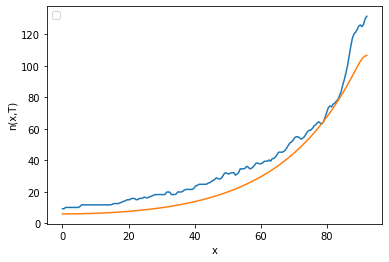

[[0.007118811363539423, 120.57120429272551, 24734.177815104038, 2.8303614520436686, 34.74121139000783], [0.005858461325487287, 101.38157517715261, 22361.269807567034, 2.7576110565760525, 29.657085934099435], [0.008194681347801996, 136.4838231087201, 26213.073971323054, 2.4122419070642787, 36.3212762997626], [0.005929856486794324, 62.99020185358995, 24696.17186751144, 1.8694284075078396, 43.61947538102198], [0.0061168085209431546, 117.48801757080317, 24585.17292902007, 2.3144404135897827, 31.527252142822363]]
[[ 2.01753046e-06  4.12392331e-02  2.13135247e+00  1.83233939e-04
   8.99284144e-04]
 [ 4.12392331e-02  1.56441789e+03  2.89458942e+04  1.32505591e+01
  -1.75489465e+02]
 [ 2.13135247e+00  2.89458942e+04  3.80387558e+06 -3.78880163e+02
   7.50471866e+03]
 [ 1.83233939e-04  1.32505591e+01 -3.78880163e+02  2.97647921e-01
  -3.15694953e+00]
 [ 8.99284144e-04 -1.75489465e+02  7.50471866e+03 -3.15694953e+00
   5.82823557e+01]]
after perturb [0.006705080111302701, 116.47729455307213, 247

oxigeno [9.99400130e-30 1.01820632e-29 1.07533267e-29 1.17293529e-29
 1.31470819e-29 1.50602796e-29 1.75416530e-29 2.06857229e-29
 2.46125752e-29 2.94726485e-29 3.54527648e-29 4.27836582e-29
 5.17493319e-29 6.26986465e-29 7.60596522e-29 9.23572974e-29
 1.12235306e-28 1.36483210e-28 1.66069762e-28 2.02184271e-28
 2.46287771e-28 3.00176410e-28 3.66060081e-28 4.46660016e-28
 5.45330073e-28 6.66207631e-28 8.14401496e-28 9.96226210e-28
 1.21949453e-27 1.49388293e-27 1.83138901e-27 2.24690450e-27
 2.75893406e-27 3.39049804e-27 4.17026798e-27 5.13399633e-27
 6.32631955e-27 7.80303470e-27 9.63397831e-27 1.19066716e-26
 1.47309428e-26 1.82447974e-26 2.26218834e-26 2.80809993e-26
 3.48982236e-26 4.34224101e-26 5.40950152e-26 6.74755092e-26
 8.42739940e-26 1.05393142e-25 1.31982207e-25 1.65506698e-25
 2.07838412e-25 2.61371973e-25 3.29175942e-25 4.15189109e-25
 5.24475909e-25 6.63559394e-25 8.40856100e-25 1.06724503e-24
 1.35681355e-24 1.72783698e-24 2.20406769e-24 2.81643477e-24
 3.60528930e-24 

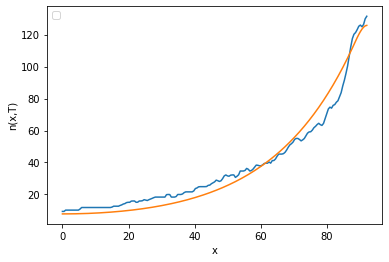

4
[[0.007118811363539423, 120.57120429272551, 24734.177815104038, 2.8303614520436686, 34.74121139000783], [0.005858461325487287, 101.38157517715261, 22361.269807567034, 2.7576110565760525, 29.657085934099435], [0.008194681347801996, 136.4838231087201, 26213.073971323054, 2.4122419070642787, 36.3212762997626], [0.005929856486794324, 62.99020185358995, 24696.17186751144, 1.8694284075078396, 43.61947538102198], [0.0061168085209431546, 117.48801757080317, 24585.17292902007, 2.3144404135897827, 31.527252142822363]]
[[ 2.01753046e-06  4.12392331e-02  2.13135247e+00  1.83233939e-04
   8.99284144e-04]
 [ 4.12392331e-02  1.56441789e+03  2.89458942e+04  1.32505591e+01
  -1.75489465e+02]
 [ 2.13135247e+00  2.89458942e+04  3.80387558e+06 -3.78880163e+02
   7.50471866e+03]
 [ 1.83233939e-04  1.32505591e+01 -3.78880163e+02  2.97647921e-01
  -3.15694953e+00]
 [ 8.99284144e-04 -1.75489465e+02  7.50471866e+03 -3.15694953e+00
   5.82823557e+01]]
after perturb [0.0078082303939271975, 163.41914501774284, 

oxigeno [8.38138067e-31 8.51077823e-31 8.90296634e-31 9.57009545e-31
 1.05328991e-30 1.18213648e-30 1.34757091e-30 1.55476908e-30
 1.81023096e-30 2.12199486e-30 2.49990385e-30 2.95593385e-30
 3.50459525e-30 4.16342275e-30 4.95357133e-30 5.90054056e-30
 7.03505429e-30 8.39412889e-30 1.00223709e-29 1.19735541e-29
 1.43125369e-29 1.71175964e-29 2.04832705e-29 2.45238239e-29
 2.93774770e-29 3.52115720e-29 4.22288922e-29 5.06753967e-29
 6.08497027e-29 7.31147204e-29 8.79119488e-29 1.05779061e-28
 1.27371562e-28 1.53489501e-28 1.85110456e-28 2.23430311e-28
 2.69913761e-28 3.26356914e-28 3.94965024e-28 4.78449144e-28
 5.80146473e-28 7.04170426e-28 8.55598059e-28 1.04070450e-27
 1.26725661e-27 1.54488148e-27 1.88552951e-27 2.30405729e-27
 2.81896265e-27 3.45331288e-27 4.23591925e-27 5.20282541e-27
 6.39919723e-27 7.88172640e-27 9.72169324e-27 1.20088766e-26
 1.48565548e-26 1.84079138e-26 2.28442750e-26 2.83956809e-26
 3.53545388e-26 4.40932462e-26 5.50870031e-26 6.89434005e-26
 8.64408816e-26 

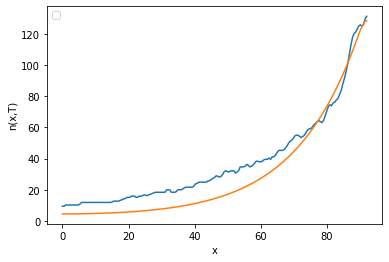

[[0.007118811363539423, 120.57120429272551, 24734.177815104038, 2.8303614520436686, 34.74121139000783], [0.005858461325487287, 101.38157517715261, 22361.269807567034, 2.7576110565760525, 29.657085934099435], [0.008194681347801996, 136.4838231087201, 26213.073971323054, 2.4122419070642787, 36.3212762997626], [0.005929856486794324, 62.99020185358995, 24696.17186751144, 1.8694284075078396, 43.61947538102198], [0.0061168085209431546, 117.48801757080317, 24585.17292902007, 2.3144404135897827, 31.527252142822363]]
[[ 2.01753046e-06  4.12392331e-02  2.13135247e+00  1.83233939e-04
   8.99284144e-04]
 [ 4.12392331e-02  1.56441789e+03  2.89458942e+04  1.32505591e+01
  -1.75489465e+02]
 [ 2.13135247e+00  2.89458942e+04  3.80387558e+06 -3.78880163e+02
   7.50471866e+03]
 [ 1.83233939e-04  1.32505591e+01 -3.78880163e+02  2.97647921e-01
  -3.15694953e+00]
 [ 8.99284144e-04 -1.75489465e+02  7.50471866e+03 -3.15694953e+00
   5.82823557e+01]]
after perturb [0.004284436998198988, 73.1449161040443, 22465

oxigeno [3.05991490e-30 3.10518428e-30 3.24233188e-30 3.47543055e-30
 3.81142620e-30 4.26035396e-30 4.83565226e-30 5.55458536e-30
 6.43878869e-30 7.51495587e-30 8.81569092e-30 1.03805554e-29
 1.22573473e-29 1.45036563e-29 1.71887517e-29 2.03958703e-29
 2.42249870e-29 2.87961706e-29 3.42536476e-29 4.07707279e-29
 4.85557763e-29 5.78594591e-29 6.89835459e-29 8.22916093e-29
 9.82220446e-29 1.17303931e-28 1.40176375e-28 1.67612120e-28
 2.00546414e-28 2.40112324e-28 2.87684013e-28 3.44929820e-28
 4.13877459e-28 4.96994207e-28 5.97285644e-28 7.18417412e-28
 8.64865563e-28 1.04210245e-27 1.25682691e-27 1.51724970e-27
 1.83344789e-27 2.21780570e-27 2.68556348e-27 3.25550254e-27
 3.95080077e-27 4.80010327e-27 5.83886426e-27 7.11103163e-27
 8.67116532e-27 1.05871055e-26 1.29433392e-26 1.58452556e-26
 1.94245340e-26 2.38459775e-26 2.93161985e-26 3.60946742e-26
 4.45078493e-26 5.49671575e-26 6.79920961e-26 8.42398284e-26
 1.04543236e-25 1.29959934e-25 1.61835528e-25 2.01885441e-25
 2.52300957e-25 

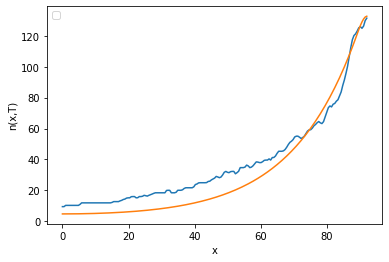

[[0.007118811363539423, 120.57120429272551, 24734.177815104038, 2.8303614520436686, 34.74121139000783], [0.005858461325487287, 101.38157517715261, 22361.269807567034, 2.7576110565760525, 29.657085934099435], [0.008194681347801996, 136.4838231087201, 26213.073971323054, 2.4122419070642787, 36.3212762997626], [0.005929856486794324, 62.99020185358995, 24696.17186751144, 1.8694284075078396, 43.61947538102198], [0.0061168085209431546, 117.48801757080317, 24585.17292902007, 2.3144404135897827, 31.527252142822363]]
[[ 2.01753046e-06  4.12392331e-02  2.13135247e+00  1.83233939e-04
   8.99284144e-04]
 [ 4.12392331e-02  1.56441789e+03  2.89458942e+04  1.32505591e+01
  -1.75489465e+02]
 [ 2.13135247e+00  2.89458942e+04  3.80387558e+06 -3.78880163e+02
   7.50471866e+03]
 [ 1.83233939e-04  1.32505591e+01 -3.78880163e+02  2.97647921e-01
  -3.15694953e+00]
 [ 8.99284144e-04 -1.75489465e+02  7.50471866e+03 -3.15694953e+00
   5.82823557e+01]]
after perturb [0.007557610101651693, 93.56901556697761, 2687

oxigeno [1.20487576e-30 1.23138230e-30 1.31206818e-30 1.45049175e-30
 1.65277177e-30 1.92786551e-30 2.28797749e-30 2.74911843e-30
 3.33184160e-30 4.06219209e-30 4.97291553e-30 6.10498569e-30
 7.50952637e-30 9.25022364e-30 1.14063493e-29 1.40765487e-29
 1.73835862e-29 2.14802920e-29 2.65570192e-29 3.28510011e-29
 4.06581026e-29 5.03475910e-29 6.23807225e-29 7.73341486e-29
 9.59294298e-29 1.19070283e-28 1.47889651e-28 1.83809233e-28
 2.28614896e-28 2.84552269e-28 3.54448118e-28 4.41864605e-28
 5.51295605e-28 6.88416861e-28 8.60405156e-28 1.07634608e-27
 1.34775565e-27 1.68924861e-27 2.11939556e-27 2.66182419e-27
 3.34663585e-27 4.21223048e-27 5.30766118e-27 6.69567656e-27
 8.45665766e-27 1.06937206e-26 1.35393398e-26 1.71639599e-26
 2.17872089e-26 2.76925249e-26 3.52462655e-26 4.49227142e-26
 5.73368622e-26 7.32874533e-26 9.38136058e-26 1.20269423e-25
 1.54422483e-25 1.98584089e-25 2.55781824e-25 3.29988593e-25
 4.26427197e-25 5.51976118e-25 7.15711201e-25 9.29630117e-25
 1.20962323e-24 

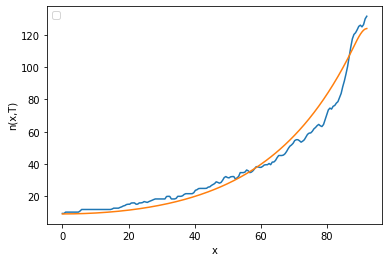

5
parameters [0.006720228973910154, 116.91744832998852, 24732.24771765912, 2.3235347719704316, 33.41541578758007]
parameters [0.005089168130831244, 77.29174241058635, 23931.07221817587, 2.005294072048146, 36.449118077950146]
parameters [0.005994680896967491, 118.32569243249623, 23254.893080203794, 2.6935432464120703, 28.215781665154996]
parameters [0.006705080111302701, 116.47729455307213, 24782.502658652138, 2.4084977469969298, 33.86451002109304]
parameters [0.007557610101651693, 93.56901556697761, 26875.9054953776, 1.9455435639987808, 46.148539735679584]
SMC step with target distance: 100.0
[[0.006720228973910154, 116.91744832998852, 24732.24771765912, 2.3235347719704316, 33.41541578758007], [0.005089168130831244, 77.29174241058635, 23931.07221817587, 2.005294072048146, 36.449118077950146], [0.005994680896967491, 118.32569243249623, 23254.893080203794, 2.6935432464120703, 28.215781665154996], [0.006705080111302701, 116.47729455307213, 24782.502658652138, 2.4084977469969298, 33.864510

oxigeno [1.20965399e-30 1.23505119e-30 1.31230924e-30 1.44468039e-30
 1.63775060e-30 1.89968244e-30 2.24157144e-30 2.67793241e-30
 3.22733833e-30 3.91324145e-30 4.76501534e-30 5.81926693e-30
 7.12148110e-30 8.72807644e-30 1.07089716e-29 1.31507868e-29
 1.61608383e-29 1.98721227e-29 2.44495401e-29 3.00976700e-29
 3.70704950e-29 4.56835705e-29 5.63292725e-29 6.94959183e-29
 8.57917725e-29 1.05975217e-28 1.30992710e-28 1.62026606e-28
 2.00555450e-28 2.48430125e-28 3.07970099e-28 3.82085257e-28
 4.74430301e-28 5.89600683e-28 7.33381557e-28 9.13064534e-28
 1.13785125e-27 1.41936821e-27 1.77232460e-27 2.21535386e-27
 2.77209193e-27 3.47256084e-27 4.35494665e-27 5.46788758e-27
 6.87342338e-27 8.65080279e-27 1.09014065e-26 1.37551230e-26
 1.73786184e-26 2.19860822e-26 2.78532121e-26 3.53354452e-26
 4.48917669e-26 5.71158559e-26 7.27768996e-26 9.28731755e-26
 1.18702522e-25 1.51955186e-25 1.94836388e-25 2.50228409e-25
 3.21905365e-25 4.14818320e-25 5.35474540e-25 6.92442944e-25
 8.97029100e-25 

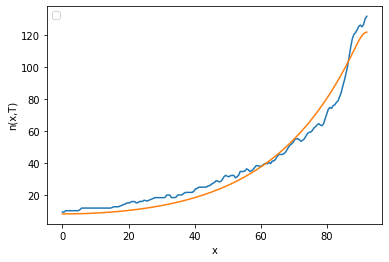

1
[[0.006720228973910154, 116.91744832998852, 24732.24771765912, 2.3235347719704316, 33.41541578758007], [0.005089168130831244, 77.29174241058635, 23931.07221817587, 2.005294072048146, 36.449118077950146], [0.005994680896967491, 118.32569243249623, 23254.893080203794, 2.6935432464120703, 28.215781665154996], [0.006705080111302701, 116.47729455307213, 24782.502658652138, 2.4084977469969298, 33.86451002109304], [0.007557610101651693, 93.56901556697761, 26875.9054953776, 1.9455435639987808, 46.148539735679584]]
[[ 1.70867689e-06  1.25185964e-02  2.07349403e+00 -7.06178361e-05
   6.43036623e-03]
 [ 1.25185964e-02  6.74286381e+02 -1.07279295e+04  9.46387932e+00
  -1.44207915e+02]
 [ 2.07349403e+00 -1.07279295e+04  3.71041056e+06 -5.50882017e+02
   1.63778195e+04]
 [-7.06178361e-05  9.46387932e+00 -5.50882017e+02  1.88319076e-01
  -3.56632495e+00]
 [ 6.43036623e-03 -1.44207915e+02  1.63778195e+04 -3.56632495e+00
   8.71509814e+01]]
after perturb [0.008929611300383678, 130.1219450961734, 2736

oxigeno [5.13999634e-30 5.26307952e-30 5.63822382e-30 6.28343031e-30
 7.22971889e-30 8.52265426e-30 1.02245952e-29 1.24177828e-29
 1.52084283e-29 1.87320122e-29 2.31600725e-29 2.87088393e-29
 3.56501720e-29 4.43253825e-29 5.51626840e-29 6.86992101e-29
 8.56087974e-29 1.06737058e-28 1.33145673e-28 1.66168376e-28
 2.07481760e-28 2.59194912e-28 3.23962983e-28 4.05131227e-28
 5.06917839e-28 6.34646304e-28 7.95040948e-28 9.96603282e-28
 1.25009174e-27 1.56913389e-27 1.97100857e-27 2.47764625e-27
 3.11691000e-27 3.92423766e-27 4.94474972e-27 6.23595813e-27
 7.87125177e-27 9.94438699e-27 1.25752803e-26 1.59174906e-26
 2.01678969e-26 2.55792317e-26 3.24763361e-26 4.12772694e-26
 5.25207635e-26 6.69019780e-26 8.53191345e-26 1.08934429e-25
 1.39253713e-25 1.78230881e-25 2.28404838e-25 2.93079493e-25
 3.76560662e-25 4.84468374e-25 6.24149238e-25 8.05221826e-25
 1.04029916e-24 1.34594744e-24 1.74396034e-24 2.26305579e-24
 2.94113904e-24 3.82832651e-24 4.99099316e-24 6.51719971e-24
 8.52398326e-24 

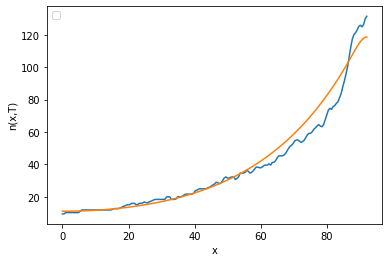

2
[[0.006720228973910154, 116.91744832998852, 24732.24771765912, 2.3235347719704316, 33.41541578758007], [0.005089168130831244, 77.29174241058635, 23931.07221817587, 2.005294072048146, 36.449118077950146], [0.005994680896967491, 118.32569243249623, 23254.893080203794, 2.6935432464120703, 28.215781665154996], [0.006705080111302701, 116.47729455307213, 24782.502658652138, 2.4084977469969298, 33.86451002109304], [0.007557610101651693, 93.56901556697761, 26875.9054953776, 1.9455435639987808, 46.148539735679584]]
[[ 1.70867689e-06  1.25185964e-02  2.07349403e+00 -7.06178361e-05
   6.43036623e-03]
 [ 1.25185964e-02  6.74286381e+02 -1.07279295e+04  9.46387932e+00
  -1.44207915e+02]
 [ 2.07349403e+00 -1.07279295e+04  3.71041056e+06 -5.50882017e+02
   1.63778195e+04]
 [-7.06178361e-05  9.46387932e+00 -5.50882017e+02  1.88319076e-01
  -3.56632495e+00]
 [ 6.43036623e-03 -1.44207915e+02  1.63778195e+04 -3.56632495e+00
   8.71509814e+01]]
after perturb [0.007401412628693389, 65.8096472844137, 27926

oxigeno [5.50106496e-30 5.62012016e-30 5.98243901e-30 6.60374095e-30
 7.51104402e-30 8.74387300e-30 1.03560339e-29 1.24180389e-29
 1.50202962e-29 1.82772187e-29 2.23324474e-29 2.73654433e-29
 3.35997677e-29 4.13134586e-29 5.08520135e-29 6.26446267e-29
 7.72244949e-29 9.52542184e-29 1.17557593e-28 1.45159431e-28
 1.79335471e-28 2.21675002e-28 2.74159501e-28 3.39261476e-28
 4.20068856e-28 5.20441657e-28 6.45209558e-28 8.00421309e-28
 9.93659945e-28 1.23444163e-27 1.53472093e-27 1.90953160e-27
 2.37780042e-27 2.96338180e-27 3.69637510e-27 4.61480366e-27
 5.76675801e-27 7.21313504e-27 9.03114361e-27 1.13187973e-26
 1.42006803e-26 1.78353574e-26 2.24249109e-26 2.82272333e-26
 3.55718938e-26 4.48806508e-26 5.66940089e-26 7.17056560e-26
 9.08071882e-26 1.15146288e-25 1.46202524e-25 1.85886269e-25
 2.36668004e-25 3.01747621e-25 3.85276475e-25 4.92649113e-25
 6.30887223e-25 8.09145829e-25 1.03938184e-24 1.33723865e-24
 1.72321864e-24 2.22424037e-24 2.87571017e-24 3.72428371e-24
 4.83155400e-24 

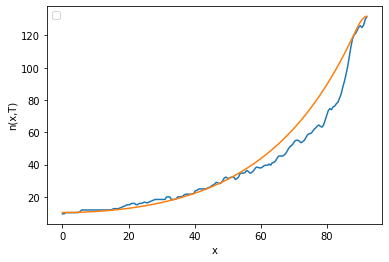

[[0.006720228973910154, 116.91744832998852, 24732.24771765912, 2.3235347719704316, 33.41541578758007], [0.005089168130831244, 77.29174241058635, 23931.07221817587, 2.005294072048146, 36.449118077950146], [0.005994680896967491, 118.32569243249623, 23254.893080203794, 2.6935432464120703, 28.215781665154996], [0.006705080111302701, 116.47729455307213, 24782.502658652138, 2.4084977469969298, 33.86451002109304], [0.007557610101651693, 93.56901556697761, 26875.9054953776, 1.9455435639987808, 46.148539735679584]]
[[ 1.70867689e-06  1.25185964e-02  2.07349403e+00 -7.06178361e-05
   6.43036623e-03]
 [ 1.25185964e-02  6.74286381e+02 -1.07279295e+04  9.46387932e+00
  -1.44207915e+02]
 [ 2.07349403e+00 -1.07279295e+04  3.71041056e+06 -5.50882017e+02
   1.63778195e+04]
 [-7.06178361e-05  9.46387932e+00 -5.50882017e+02  1.88319076e-01
  -3.56632495e+00]
 [ 6.43036623e-03 -1.44207915e+02  1.63778195e+04 -3.56632495e+00
   8.71509814e+01]]
after perturb [0.009652571233466089, 117.4301077772317, 29360.

oxigeno [8.96617359e-29 9.11934595e-29 9.58409644e-29 1.03763535e-28
 1.15233504e-28 1.30645974e-28 1.50532972e-28 1.75582608e-28
 2.06663960e-28 2.44858647e-28 2.91500339e-28 3.48223741e-28
 4.17025004e-28 5.00335963e-28 6.01115192e-28 7.22959573e-28
 8.70240938e-28 1.04827343e-27 1.26351857e-27 1.52383660e-27
 1.83879487e-27 2.22004643e-27 2.68179524e-27 3.24136835e-27
 3.91992041e-27 4.74330192e-27 5.74313049e-27 6.95811396e-27
 8.43568651e-27 1.02340340e-26 1.24246045e-26 1.50952226e-26
 1.83539602e-26 2.23339497e-26 2.71993798e-26 3.31529728e-26
 4.04453208e-26 4.93865597e-26 6.03609855e-26 7.38453784e-26
 9.04320096e-26 1.10857564e-25 1.36039559e-25 1.67122253e-25
 2.05534631e-25 2.53063713e-25 3.11947410e-25 3.84992307e-25
 4.75723283e-25 5.88573901e-25 7.29129041e-25 9.04434623e-25
 1.12339362e-24 1.39727324e-24 1.74035557e-24 2.17077375e-24
 2.71158828e-24 3.39217512e-24 4.25001878e-24 5.33303295e-24
 6.70256929e-24 8.43732555e-24 1.06384315e-23 1.34360800e-23
 1.69981894e-23 

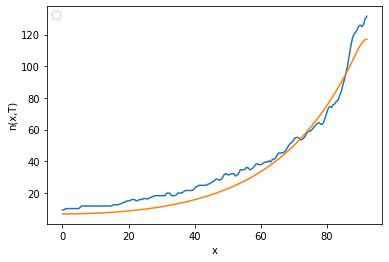

3
[[0.006720228973910154, 116.91744832998852, 24732.24771765912, 2.3235347719704316, 33.41541578758007], [0.005089168130831244, 77.29174241058635, 23931.07221817587, 2.005294072048146, 36.449118077950146], [0.005994680896967491, 118.32569243249623, 23254.893080203794, 2.6935432464120703, 28.215781665154996], [0.006705080111302701, 116.47729455307213, 24782.502658652138, 2.4084977469969298, 33.86451002109304], [0.007557610101651693, 93.56901556697761, 26875.9054953776, 1.9455435639987808, 46.148539735679584]]
[[ 1.70867689e-06  1.25185964e-02  2.07349403e+00 -7.06178361e-05
   6.43036623e-03]
 [ 1.25185964e-02  6.74286381e+02 -1.07279295e+04  9.46387932e+00
  -1.44207915e+02]
 [ 2.07349403e+00 -1.07279295e+04  3.71041056e+06 -5.50882017e+02
   1.63778195e+04]
 [-7.06178361e-05  9.46387932e+00 -5.50882017e+02  1.88319076e-01
  -3.56632495e+00]
 [ 6.43036623e-03 -1.44207915e+02  1.63778195e+04 -3.56632495e+00
   8.71509814e+01]]
after perturb [0.0073784225942921675, 75.26385463275389, 270

oxigeno [3.02121555e-31 3.08987483e-31 3.29897335e-31 3.65803636e-31
 4.18345741e-31 4.89926723e-31 5.83826521e-31 7.04356954e-31
 8.57066315e-31 1.04900378e-30 1.28905692e-30 1.58837948e-30
 1.96093109e-30 2.42415679e-30 2.99984137e-30 3.71518317e-30
 4.60414363e-30 5.70914425e-30 7.08320136e-30 8.79261405e-30
 1.09203510e-29 1.35703225e-29 1.68727730e-29 2.09910973e-29
 2.61304630e-29 3.25487309e-29 4.05703018e-29 5.06036923e-29
 6.31638726e-29 7.89006874e-29 9.86350634e-29 1.23405192e-28
 1.54525513e-28 1.93662136e-28 2.42929424e-28 3.05013823e-28
 3.83332849e-28 4.82239494e-28 6.07285403e-28 7.65560178e-28
 9.66129500e-28 1.22060164e-27 1.54386109e-27 1.95502013e-27
 2.47865475e-27 3.14641270e-27 3.99910880e-27 5.08945967e-27
 6.48565868e-27 8.27605713e-27 1.05753042e-26 1.35324140e-26
 1.73413823e-26 2.22551841e-26 2.86042601e-26 3.68209766e-26
 4.74720468e-26 6.13015829e-26 7.92883741e-26 1.02722231e-25
 1.33305940e-25 1.73291683e-25 2.25663918e-25 2.94385057e-25
 3.84726129e-25 

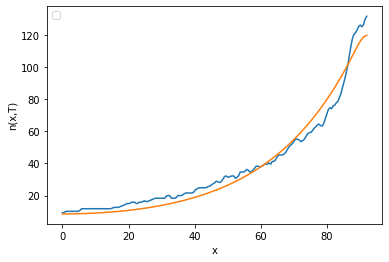

4
[[0.006720228973910154, 116.91744832998852, 24732.24771765912, 2.3235347719704316, 33.41541578758007], [0.005089168130831244, 77.29174241058635, 23931.07221817587, 2.005294072048146, 36.449118077950146], [0.005994680896967491, 118.32569243249623, 23254.893080203794, 2.6935432464120703, 28.215781665154996], [0.006705080111302701, 116.47729455307213, 24782.502658652138, 2.4084977469969298, 33.86451002109304], [0.007557610101651693, 93.56901556697761, 26875.9054953776, 1.9455435639987808, 46.148539735679584]]
[[ 1.70867689e-06  1.25185964e-02  2.07349403e+00 -7.06178361e-05
   6.43036623e-03]
 [ 1.25185964e-02  6.74286381e+02 -1.07279295e+04  9.46387932e+00
  -1.44207915e+02]
 [ 2.07349403e+00 -1.07279295e+04  3.71041056e+06 -5.50882017e+02
   1.63778195e+04]
 [-7.06178361e-05  9.46387932e+00 -5.50882017e+02  1.88319076e-01
  -3.56632495e+00]
 [ 6.43036623e-03 -1.44207915e+02  1.63778195e+04 -3.56632495e+00
   8.71509814e+01]]
after perturb [0.00946562678019381, 96.49843828058786, 29827

oxigeno [3.04669709e-30 3.12389761e-30 3.35941158e-30 3.76519519e-30
 4.36188521e-30 5.17987053e-30 6.26087516e-30 7.66013842e-30
 9.44931099e-30 1.17202251e-29 1.45897463e-29 1.82059740e-29
 2.27561367e-29 2.84766216e-29 3.56657036e-29 4.46996947e-29
 5.60534339e-29 7.03262933e-29 8.82752065e-29 1.10856640e-28
 1.39279973e-28 1.75075446e-28 2.20180721e-28 2.77051264e-28
 3.48801227e-28 4.39383457e-28 5.53819687e-28 6.98495251e-28
 8.81536765e-28 1.11329667e-27 1.40697557e-27 1.77942233e-27
 2.25216412e-27 2.85273372e-27 3.61638214e-27 4.58829082e-27
 5.82643294e-27 7.40527854e-27 9.42059849e-27 1.19957013e-26
 1.52895404e-26 1.95072669e-26 2.49139836e-26 3.18526970e-26
 4.07677783e-26 5.22356705e-26 6.70051329e-26 8.60500648e-26
 1.10638939e-25 1.42426202e-25 1.83572780e-25 2.36905186e-25
 3.06125927e-25 3.96092190e-25 5.13185536e-25 6.65803120e-25
 8.65011431e-25 1.12541777e-24 1.46633392e-24 1.91333253e-24
 2.50033244e-24 3.27239734e-24 4.28949855e-24 5.63158278e-24
 7.40540976e-24 

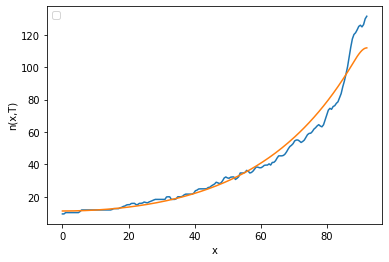

5
parameters [0.007049090938336662, 96.01253560520095, 25981.85387914363, 2.115428342336973, 42.31739218472538]
parameters [0.008929611300383678, 130.1219450961734, 27367.896814027663, 2.430552725801225, 42.86162532155905]
parameters [0.006220718901872365, 131.43124163274484, 23034.145687837372, 2.8229335979632784, 25.193938401633506]
parameters [0.0073784225942921675, 75.26385463275389, 27009.52592088794, 1.706101845276988, 49.99839948737975]
parameters [0.009317505047591068, 130.57613724264993, 27447.069045209162, 2.54346670111937, 44.116759054456516]
SMC step with target distance: 90.0
[[0.007049090938336662, 96.01253560520095, 25981.85387914363, 2.115428342336973, 42.31739218472538], [0.008929611300383678, 130.1219450961734, 27367.896814027663, 2.430552725801225, 42.86162532155905], [0.006220718901872365, 131.43124163274484, 23034.145687837372, 2.8229335979632784, 25.193938401633506], [0.0073784225942921675, 75.26385463275389, 27009.52592088794, 1.706101845276988, 49.99839948737975

oxigeno [1.75566472e-29 1.79391841e-29 1.91034648e-29 2.11003357e-29
 2.40171916e-29 2.79819008e-29 3.31685699e-29 3.98054206e-29
 4.81851530e-29 5.86782906e-29 7.17501496e-29 8.79822504e-29
 1.08099215e-28 1.33002465e-28 1.63812386e-28 2.01921048e-28
 2.49058120e-28 3.07373307e-28 3.79539500e-28 4.68881911e-28
 5.79539893e-28 7.16669844e-28 8.86699894e-28 1.09764985e-27
 1.35953353e-27 1.68486524e-27 2.08929788e-27 2.59242794e-27
 3.21881191e-27 3.99925122e-27 4.97241832e-27 6.18691694e-27
 7.70389535e-27 9.60036524e-27 1.19734214e-26 1.49456137e-26
 1.86717943e-26 2.33478560e-26 2.92218993e-26 3.66085204e-26
 4.59071178e-26 5.76253794e-26 7.24094551e-26 9.10827757e-26
 1.14696061e-25 1.44591840e-25 1.82487808e-25 2.30584686e-25
 2.91705985e-25 3.69479390e-25 4.68572525e-25 5.94999853e-25
 7.56522833e-25 9.63172483e-25 1.22793289e-24 1.56763673e-24
 2.00414042e-24 2.56586890e-24 3.28984973e-24 4.22439600e-24
 5.43265122e-24 6.99728148e-24 9.02669703e-24 1.16633167e-23
 1.50945664e-23 

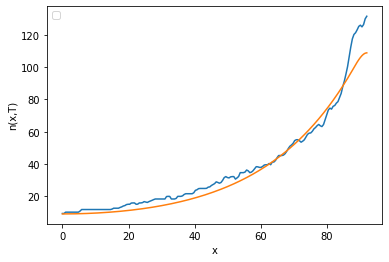

1
[[0.007049090938336662, 96.01253560520095, 25981.85387914363, 2.115428342336973, 42.31739218472538], [0.008929611300383678, 130.1219450961734, 27367.896814027663, 2.430552725801225, 42.86162532155905], [0.006220718901872365, 131.43124163274484, 23034.145687837372, 2.8229335979632784, 25.193938401633506], [0.0073784225942921675, 75.26385463275389, 27009.52592088794, 1.706101845276988, 49.99839948737975], [0.009317505047591068, 130.57613724264993, 27447.069045209162, 2.54346670111937, 44.116759054456516]]
[[ 3.40618680e-06  2.27681433e-02  4.01533420e+00  4.12635457e-05
   1.35006737e-02]
 [ 2.27681433e-02  1.32693727e+03 -2.16644014e+04  2.08687235e+01
  -2.83388696e+02]
 [ 4.01533420e+00 -2.16644014e+04  6.81981452e+06 -8.18086114e+02
   3.15407059e+04]
 [ 4.12635457e-05  2.08687235e+01 -8.18086114e+02  3.66876829e-01
  -6.41940475e+00]
 [ 1.35006737e-02 -2.83388696e+02  3.15407059e+04 -6.41940475e+00
   1.72832865e+02]]
after perturb [0.009055550592121004, 120.31674129797989, 27494.

oxigeno [1.37199097e-30 1.40702521e-30 1.51391712e-30 1.69813532e-30
 1.96912127e-30 2.34078341e-30 2.83222740e-30 3.46876232e-30
 4.28323819e-30 5.31778829e-30 6.62607312e-30 8.27615060e-30
 1.03541337e-29 1.29688413e-29 1.62577063e-29 2.03942785e-29
 2.55977534e-29 3.21450785e-29 4.03863439e-29 5.07643615e-29
 6.38395917e-29 8.03219061e-29 1.01111096e-28 1.27348584e-28
 1.60483500e-28 2.02357200e-28 2.55311473e-28 3.22327237e-28
 4.07202488e-28 5.14780877e-28 6.51245624e-28 8.24497891e-28
 1.04464443e-27 1.32462684e-27 1.68103443e-27 2.13515567e-27
 2.71433989e-27 3.45376285e-27 4.39871919e-27 5.60760253e-27
 7.15578487e-27 9.14067324e-27 1.16883100e-26 1.49619997e-26
 1.91736009e-26 2.45983270e-26 3.15941740e-26 4.06274607e-26
 5.23064519e-26 6.74256918e-26 8.70245465e-26 1.12464630e-25
 1.45532368e-25 1.88575068e-25 2.44681749e-25 3.17923825e-25
 4.13676002e-25 5.39044825e-25 7.03441958e-25 9.19352406e-25
 1.20336573e-24 1.57756276e-24 2.07138360e-24 2.72414858e-24
 3.58846659e-24 

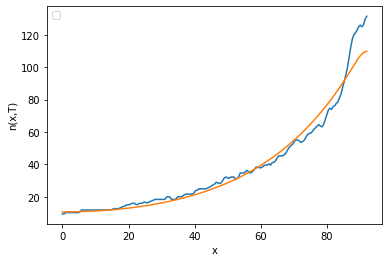

2
[[0.007049090938336662, 96.01253560520095, 25981.85387914363, 2.115428342336973, 42.31739218472538], [0.008929611300383678, 130.1219450961734, 27367.896814027663, 2.430552725801225, 42.86162532155905], [0.006220718901872365, 131.43124163274484, 23034.145687837372, 2.8229335979632784, 25.193938401633506], [0.0073784225942921675, 75.26385463275389, 27009.52592088794, 1.706101845276988, 49.99839948737975], [0.009317505047591068, 130.57613724264993, 27447.069045209162, 2.54346670111937, 44.116759054456516]]
[[ 3.40618680e-06  2.27681433e-02  4.01533420e+00  4.12635457e-05
   1.35006737e-02]
 [ 2.27681433e-02  1.32693727e+03 -2.16644014e+04  2.08687235e+01
  -2.83388696e+02]
 [ 4.01533420e+00 -2.16644014e+04  6.81981452e+06 -8.18086114e+02
   3.15407059e+04]
 [ 4.12635457e-05  2.08687235e+01 -8.18086114e+02  3.66876829e-01
  -6.41940475e+00]
 [ 1.35006737e-02 -2.83388696e+02  3.15407059e+04 -6.41940475e+00
   1.72832865e+02]]
after perturb [0.009644313475251977, 151.951639619893, 27174.03

oxigeno [6.05124387e-30 6.17097615e-30 6.53491112e-30 7.15748876e-30
 8.06347486e-30 9.28897777e-30 1.08829372e-29 1.29091502e-29
 1.54489233e-29 1.86044679e-29 2.25031905e-29 2.73030682e-29
 3.31993536e-29 4.04329122e-29 4.93005739e-29 6.01679766e-29
 7.34854980e-29 8.98080238e-29 1.09819488e-28 1.34363354e-28
 1.64480512e-28 2.01456429e-28 2.46879867e-28 3.02716094e-28
 3.71398233e-28 4.55941390e-28 5.60085382e-28 6.88473436e-28
 8.46876190e-28 1.04247280e-27 1.28420411e-27 1.58321700e-27
 1.95342398e-27 2.41220897e-27 2.98131848e-27 3.68798848e-27
 4.56637106e-27 5.65934316e-27 7.02080277e-27 8.71858818e-27
 1.08381944e-26 1.34875113e-26 1.68028733e-26 2.09567949e-26
 2.61678767e-26 3.27135106e-26 4.09461993e-26 5.13145535e-26
 6.43903465e-26 8.09034346e-26 1.01786900e-25 1.28235507e-25
 1.61781526e-25 2.04393249e-25 2.58603212e-25 3.27675372e-25
 4.15823455e-25 5.28496664e-25 6.72754175e-25 8.57756953e-25
 1.09541481e-24 1.40123936e-24 1.79547041e-24 2.30456655e-24
 2.96318125e-24 

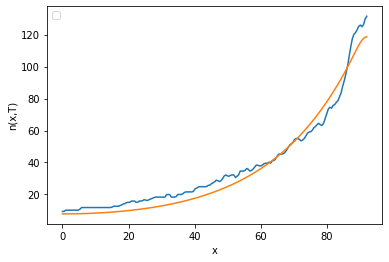

3
[[0.007049090938336662, 96.01253560520095, 25981.85387914363, 2.115428342336973, 42.31739218472538], [0.008929611300383678, 130.1219450961734, 27367.896814027663, 2.430552725801225, 42.86162532155905], [0.006220718901872365, 131.43124163274484, 23034.145687837372, 2.8229335979632784, 25.193938401633506], [0.0073784225942921675, 75.26385463275389, 27009.52592088794, 1.706101845276988, 49.99839948737975], [0.009317505047591068, 130.57613724264993, 27447.069045209162, 2.54346670111937, 44.116759054456516]]
[[ 3.40618680e-06  2.27681433e-02  4.01533420e+00  4.12635457e-05
   1.35006737e-02]
 [ 2.27681433e-02  1.32693727e+03 -2.16644014e+04  2.08687235e+01
  -2.83388696e+02]
 [ 4.01533420e+00 -2.16644014e+04  6.81981452e+06 -8.18086114e+02
   3.15407059e+04]
 [ 4.12635457e-05  2.08687235e+01 -8.18086114e+02  3.66876829e-01
  -6.41940475e+00]
 [ 1.35006737e-02 -2.83388696e+02  3.15407059e+04 -6.41940475e+00
   1.72832865e+02]]
after perturb [0.007209478024186974, 127.26800315183272, 24618.

oxigeno [8.75298760e-30 8.93117020e-30 9.47297245e-30 1.04005080e-29
 1.17517264e-29 1.35820127e-29 1.59665318e-29 1.90034216e-29
 2.28179796e-29 2.75680319e-29 3.34507281e-29 4.07110736e-29
 4.96525921e-29 6.06506135e-29 7.41688075e-29 9.07797429e-29
 1.11190448e-28 1.36274195e-28 1.67110053e-28 2.05032115e-28
 2.51690850e-28 3.09129594e-28 3.79880033e-28 4.67081492e-28
 5.74630119e-28 7.07365663e-28 8.71305550e-28 1.07393858e-27
 1.32459383e-27 1.63490456e-27 2.01939225e-27 2.49620285e-27
 3.08803585e-27 3.82331834e-27 4.73769039e-27 5.87588674e-27
 7.29412369e-27 9.06313069e-27 1.12720062e-26 1.40331284e-26
 1.74884180e-26 2.18173367e-26 2.72471175e-26 3.40658672e-26
 4.26393738e-26 5.34326975e-26 6.70379491e-26 8.42100838e-26
 1.05913096e-25 1.33379728e-25 1.68188779e-25 2.12365348e-25
 2.68511046e-25 3.39973410e-25 4.31066689e-25 5.47360087e-25
 6.96054702e-25 8.86477348e-25 1.13072862e-24 1.44453496e-24
 1.84837088e-24 2.36893989e-24 3.04113230e-24 3.91061831e-24
 5.03728934e-24 

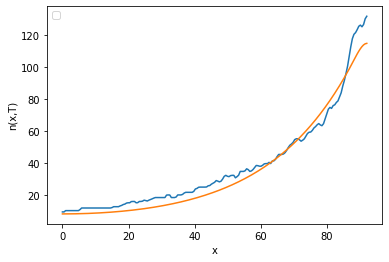

4
[[0.007049090938336662, 96.01253560520095, 25981.85387914363, 2.115428342336973, 42.31739218472538], [0.008929611300383678, 130.1219450961734, 27367.896814027663, 2.430552725801225, 42.86162532155905], [0.006220718901872365, 131.43124163274484, 23034.145687837372, 2.8229335979632784, 25.193938401633506], [0.0073784225942921675, 75.26385463275389, 27009.52592088794, 1.706101845276988, 49.99839948737975], [0.009317505047591068, 130.57613724264993, 27447.069045209162, 2.54346670111937, 44.116759054456516]]
[[ 3.40618680e-06  2.27681433e-02  4.01533420e+00  4.12635457e-05
   1.35006737e-02]
 [ 2.27681433e-02  1.32693727e+03 -2.16644014e+04  2.08687235e+01
  -2.83388696e+02]
 [ 4.01533420e+00 -2.16644014e+04  6.81981452e+06 -8.18086114e+02
   3.15407059e+04]
 [ 4.12635457e-05  2.08687235e+01 -8.18086114e+02  3.66876829e-01
  -6.41940475e+00]
 [ 1.35006737e-02 -2.83388696e+02  3.15407059e+04 -6.41940475e+00
   1.72832865e+02]]
after perturb [0.008424508854695563, 155.07660186769687, 25449.

oxigeno [5.49093709e-30 5.62086894e-30 6.01681362e-30 6.69754579e-30
 7.69540673e-30 9.05787673e-30 1.08498915e-29 1.31570204e-29
 1.60896699e-29 1.97885273e-29 2.44315274e-29 3.02427032e-29
 3.75033851e-29 4.65663364e-29 5.78735750e-29 7.19788334e-29
 8.95758612e-29 1.11534106e-28 1.38943714e-28 1.73172335e-28
 2.15936858e-28 2.69394116e-28 3.36255639e-28 4.19932986e-28
 5.24721990e-28 6.56036540e-28 8.20705552e-28 1.02735058e-27
 1.28686646e-27 1.61303386e-27 2.02330066e-27 2.53977989e-27
 3.19052579e-27 4.01116728e-27 5.04700154e-27 6.35568051e-27
 8.01066256e-27 1.01056527e-26 1.27603218e-26 1.61276832e-26
 2.04036181e-26 2.58391951e-26 3.27566206e-26 4.15699237e-26
 5.28118147e-26 6.71686107e-26 8.55257169e-26 1.09026940e-25
 1.39151953e-25 1.77817628e-25 2.27510768e-25 2.91462274e-25
 3.73876000e-25 4.80229970e-25 6.17673460e-25 7.95551319e-25
 1.02609742e-24 1.32535334e-24 1.71438748e-24 2.22091564e-24
 2.88145894e-24 3.74422236e-24 4.87294122e-24 6.35203054e-24
 8.29349070e-24 

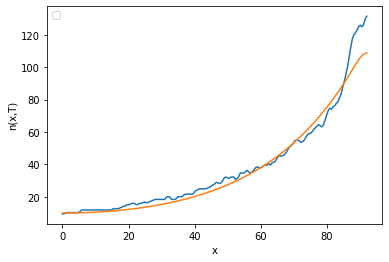

5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [46]:
sample,weight,dist,data2=principal(epsilons,params_tumor,5,datosdia6)

In [47]:
print("min accepted distance: ",np.min(dist[-1,:]))

min accepted distance:  74.16216578625183


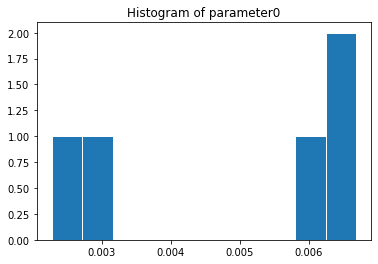

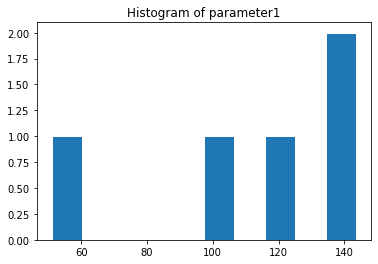

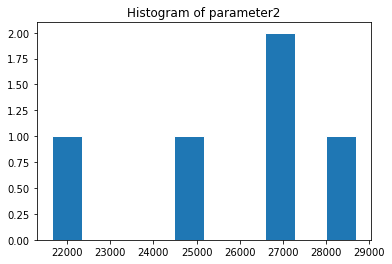

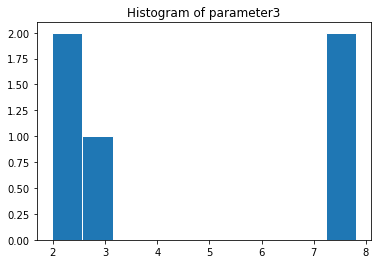

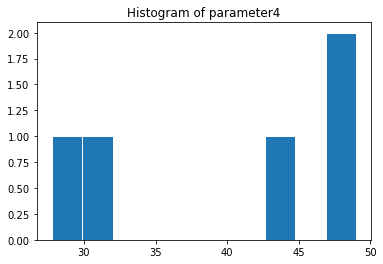

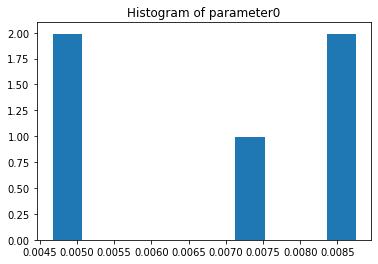

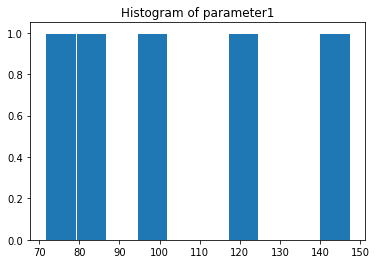

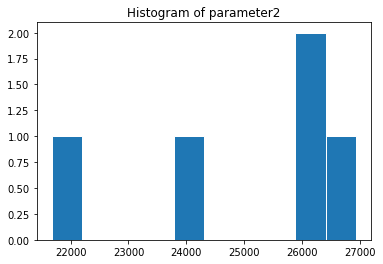

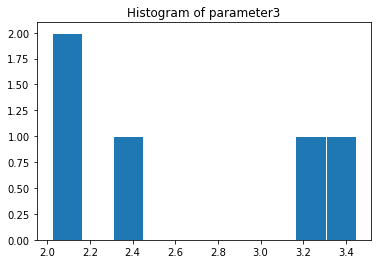

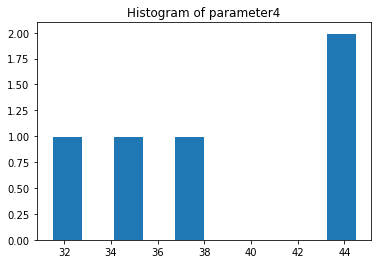

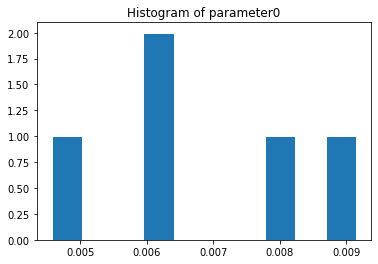

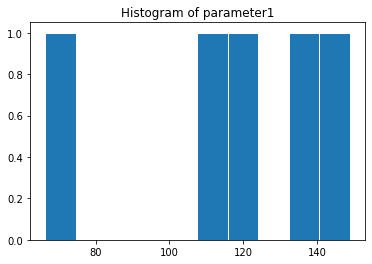

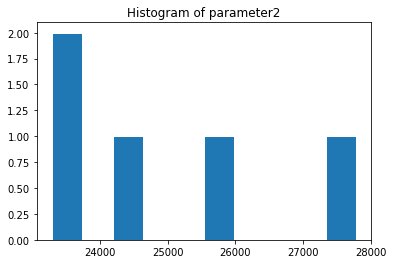

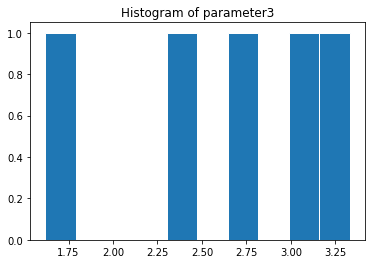

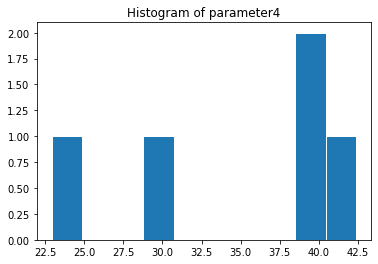

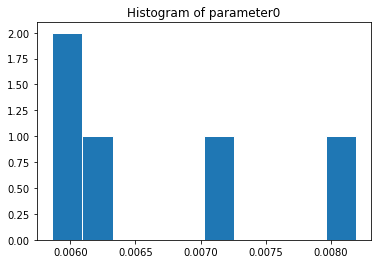

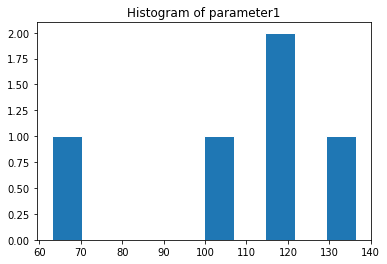

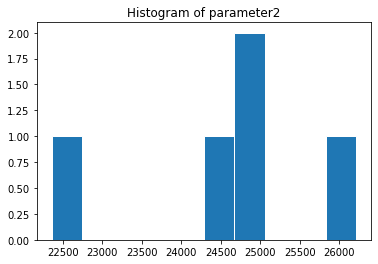

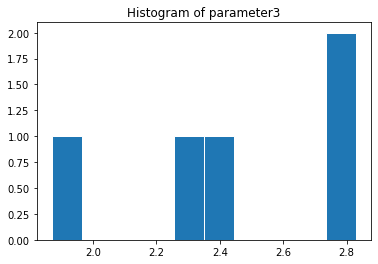

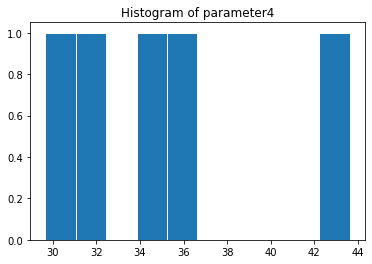

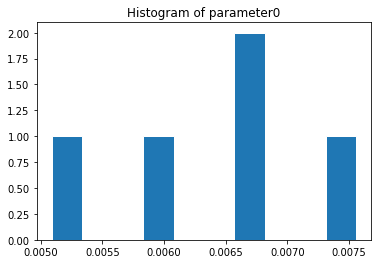

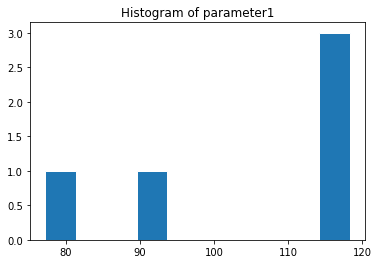

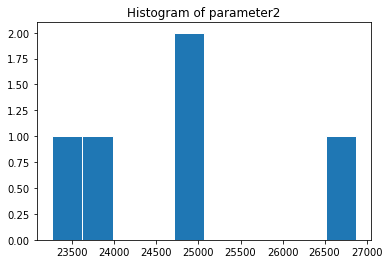

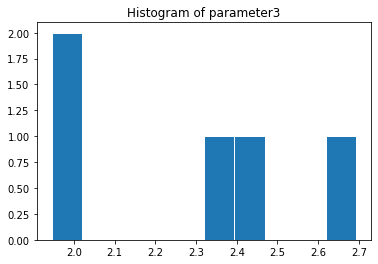

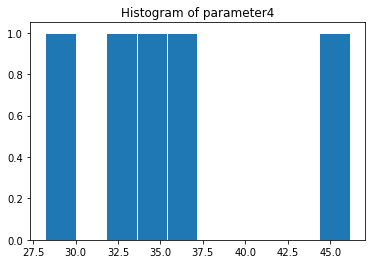

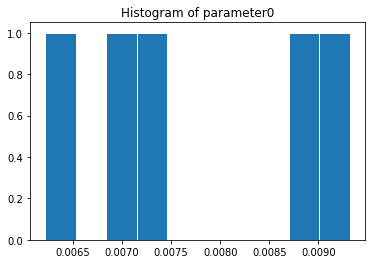

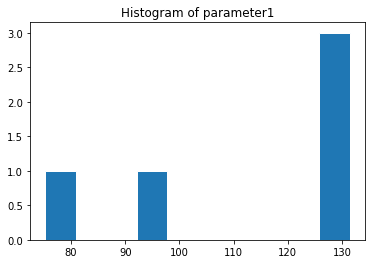

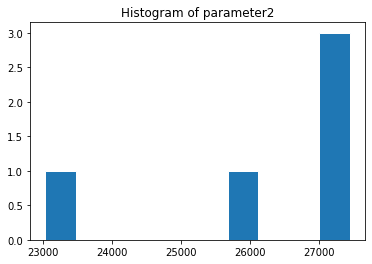

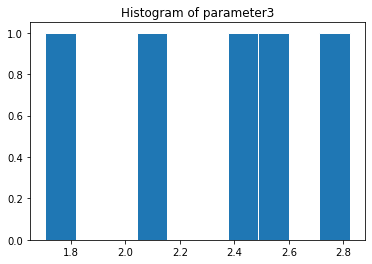

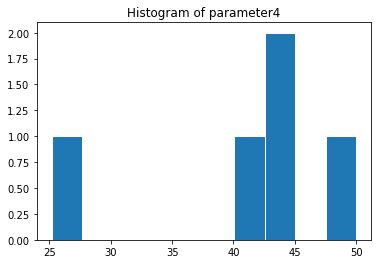

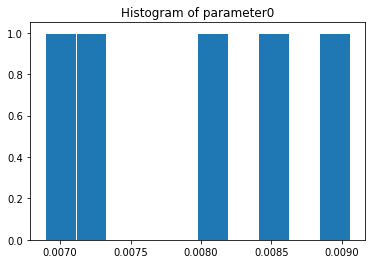

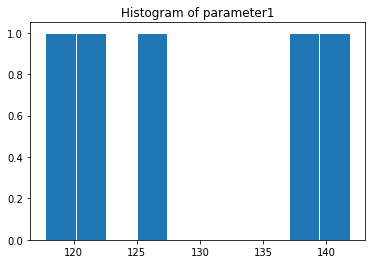

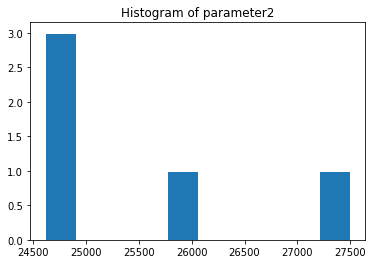

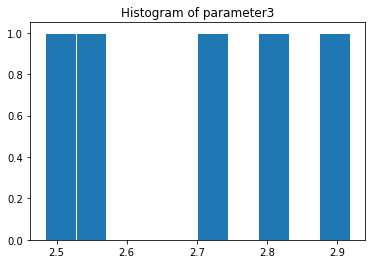

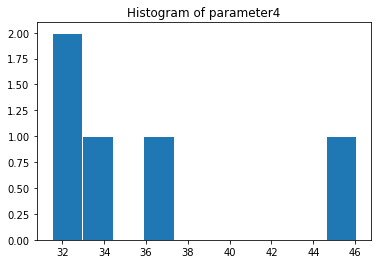

In [48]:
for k in range(len(epsilons)):
    for j in range(len(params_tumor)):
        plt.figure()
        b=[]
        for i in sample[k,:]:
            b.append(i[j])
        al=np.histogram(b)
        n,bins,patches=plt.hist(b,edgecolor='white')
        plt.title('Histogram of parameter'+str(j))
    plt.show()
plt.show()

In [49]:
data2=euler_imp(0.0073784225942921675, 75.26385463275389, 27009.52592088794, 1.706101845276988, 49.99839948737975)

In [78]:
print(data2)

[8.57883576e+00 8.58006982e+00 8.58377244e+00 8.58994497e+00
 8.59858963e+00 8.60970955e+00 8.62330875e+00 8.63939214e+00
 8.65796555e+00 8.67903568e+00 8.70261015e+00 8.72869748e+00
 8.75730709e+00 8.78844933e+00 8.82213545e+00 8.85837761e+00
 8.89718891e+00 8.93858336e+00 8.98257591e+00 9.02918245e+00
 9.07841979e+00 9.13030571e+00 9.18485894e+00 9.24209914e+00
 9.30204698e+00 9.36472407e+00 9.43015301e+00 9.49835738e+00
 9.56936176e+00 9.64319175e+00 9.71987393e+00 9.79943592e+00
 9.88190636e+00 9.96731493e+00 1.00556924e+01 1.01470705e+01
 1.02414821e+01 1.03389612e+01 1.04395428e+01 1.05432631e+01
 1.06501593e+01 1.07602697e+01 1.08736339e+01 1.09902927e+01
 1.11102877e+01 1.12336622e+01 1.13604602e+01 1.14907272e+01
 1.16245100e+01 1.17618564e+01 1.19028155e+01 1.20474378e+01
 1.21957751e+01 1.23478803e+01 1.25038079e+01 1.26636136e+01
 1.28273544e+01 1.29950888e+01 1.31668766e+01 1.33427792e+01
 1.35228592e+01 1.37071809e+01 1.38958099e+01 1.40888134e+01
 1.42862602e+01 1.448822

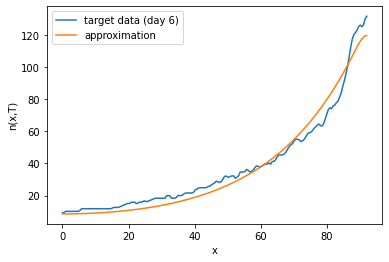

In [68]:
plt.figure()
plt.plot(x_grid,datosdia6,label='target data (day 6)')
plt.plot(x_grid,data2[0:191],label='approximation')
plt.xlabel('x')
plt.ylabel('n(x,T)')
plt.legend(loc="upper left")
plt.show()

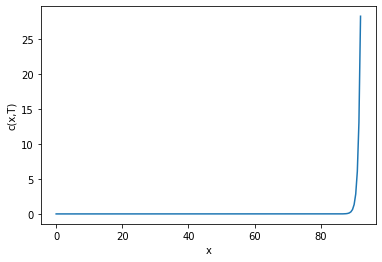

In [53]:
plt.figure()
#plt.plot(x_grid,datosdia6)
plt.plot(x_grid,data2[191:])
plt.xlabel('x')
plt.ylabel('c(x,T)')
plt.show()

In [88]:
from operator import xor
def euler_impl(Dn,Dc,am,k1,betaf):
  x0=data2
  prev_iter=x0
  x=x0
  #dt=1000 #TIME STEP IN SECONDS
  sol=np.zeros(382)
  #T=259200; #NUMBER OF SECONDS IN THREE DAYS


  #nsteps=round((1/dt)*T); #%VOY A DAR 867 pasos

  func=lambda x: x-dt*eval_function(x0,Dn,Dc,k1,am,betaf)-prev_iter

  for i in range(0,N):
    sol=fsolve(func,prev_iter)
    prev_iter=sol
    x0=x
  return(sol)



In [89]:
data3=euler_impl(0.0073784225942921675, 75.26385463275389, 27009.52592088794, 1.706101845276988, 49.99839948737975)

In [90]:
print(data3[0:191])

[  4.51479622   4.51619579   4.52039488   4.5273947    4.53719726
   4.54980536   4.56522261   4.58345342   4.60450301   4.62837742
   4.65508349   4.68462886   4.71702202   4.75227225   4.79038967
   4.83138521   4.87527066   4.92205863   4.97176256   5.02439676
   5.07997638   5.13851742   5.20003675   5.26455213   5.33208217
   5.40264637   5.47626514   5.55295977   5.63275247   5.71566637
   5.80172551   5.89095488   5.98338041   6.07902898   6.17792845
   6.28010764   6.38559637   6.49442544   6.60662669   6.72223296
   6.84127813   6.96379713   7.08982596   7.21940167   7.35256244
   7.48934752   7.62979729   7.77395328   7.92185814   8.07355572
   8.22909104   8.38851031   8.55186098   8.71919172   8.89055247
   9.06599443   9.2455701    9.4293333    9.61733917   9.80964423
  10.00630634  10.20738479  10.41294028  10.62303496  10.83773243
  11.0570978   11.28119769  11.51010025  11.74387522  11.98259391
  12.22632926  12.47515586  12.72914997  12.98838955  13.25295431
  13.52292

In [65]:
print(datosdia9)

[  5.7179   8.7232   8.7232   8.7232   8.7232   8.7232   8.7232   8.7232
   8.7232   8.7232   9.3191   9.5524  10.252   11.133   11.211   11.211
  11.211   11.211   11.211   11.211   11.211   11.211   11.211   11.211
  11.211   11.211   11.211   11.858   12.739   12.869   12.869   12.894
  13.698   13.827   14.527   14.295   13.698   13.698   14.474   15.357
  15.357   15.357   15.357   15.357   15.357   15.357   16.961   17.015
  17.015   17.015   17.195   17.612   17.299   18.18    19.061   19.503
  19.503   20.589   21.756   21.343   21.161   21.161   21.161   21.185
  21.99    21.99    22.35    23.648   23.648   23.648   23.648   23.648
  23.648   23.648   23.648   24.941   25.307   26.057   26.136   26.136
  26.06    25.562   27.145   28.026   29.19    28.942   26.965   27.842
  28.623   30.25    32.101   32.062   31.242   30.362   30.282   30.282
  30.509   32.642   33.016   37.377   38.574   38.574   38.187   37.306
  37.895   38.574   37.98    37.099   38.31    39.572   40.213 

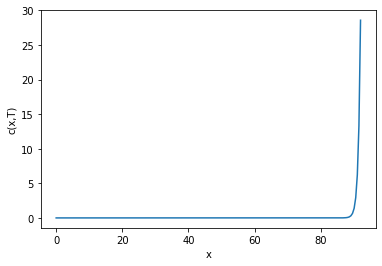

In [74]:
plt.figure()
#plt.plot(x_grid,datosdia6)
plt.plot(x_grid,data3[191:])
plt.xlabel('x')
plt.ylabel('c(x,T)')
plt.show()

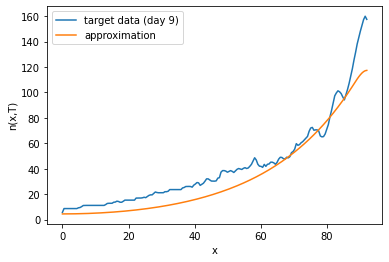

In [91]:
plt.figure()
plt.plot(x_grid,datosdia9,label='target data (day 9)')
plt.plot(x_grid,data3[0:191],label='approximation')
plt.xlabel('x')
plt.ylabel('n(x,T)')
plt.legend(loc="upper left")
plt.show()

In [93]:
data4=euler_imp(0.006066950183550362,146.79606476000794,21713.805172516404,2.739918202870899,24.759673174062115)

In [98]:
euc_disti(data3[0:191],datosdia9)

157.13650773110896

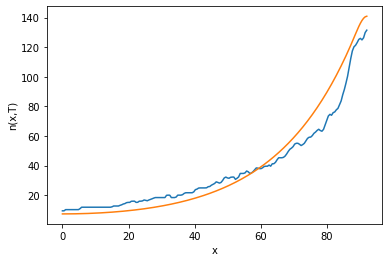

In [41]:
plt.figure()
plt.plot(x_grid,datosdia6)
plt.plot(x_grid,data4[0:191])
plt.xlabel('x')
plt.ylabel('n(x,T)')
plt.show()

In [42]:
data5=euler_impl(0.006066950183550362,146.79606476000794,21713.805172516404,2.739918202870899,24.759673174062115)

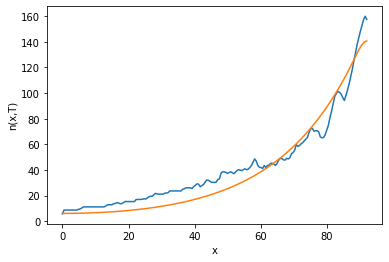

In [43]:
plt.figure()
plt.plot(x_grid,datosdia9)
plt.plot(x_grid,data5[0:191])
plt.xlabel('x')
plt.ylabel('n(x,T)')
plt.show()

In [109]:
second_best_ap=euler_imp(0.007049090938336662, 96.01253560520095, 25981.85387914363, 2.115428342336973, 42.31739218472538)

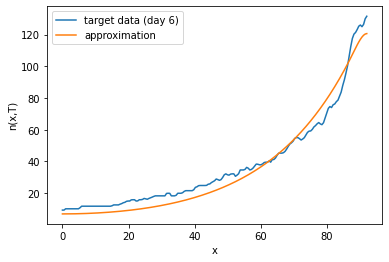

In [110]:
plt.figure()
plt.plot(x_grid,datosdia6,label='target data (day 6)')
plt.plot(x_grid,second_best_ap[0:191],label='approximation')
plt.xlabel('x')
plt.ylabel('n(x,T)')
plt.legend(loc="upper left")
plt.show()

In [111]:
third_best_ap=euler_imp(0.009317505047591068,130.57613724264993,27447.069045209162,2.54346670111937,44.116759054456516)